In [1]:

import pandas as pd
import numpy as np
from pytrendline_updated import util
from pytrendline_updated.detect import detect as base_detect_trendlines

In [2]:


# Wrapper per rendere il DataFrame compatibile con util.avg_candle_range
class CandlestickData:
    def __init__(self, df):
        self.df = df

# Funzione migliorata per il rilevamento delle trendline
def improved_detect_trendlines(
    df,
    min_points_required=3,
    scoring_function=None,
    adapt_to_volatility=True,
    debug=False,
    **kwargs
):
    """
    Migliora il rilevamento delle trendline aggiungendo configurazioni adattive e ottimizzazioni.

    Args:
        df (pd.DataFrame): Dati delle candele con colonne ["Date", "Open", "High", "Low", "Close"].
        min_points_required (int): Numero minimo di punti richiesti per una trendline valida.
        scoring_function (callable): Funzione personalizzata per il punteggio delle trendline.
        adapt_to_volatility (bool): Se True, adatta dinamicamente le configurazioni basandosi sulla volatilità.
        debug (bool): Se True, stampa informazioni di debug.
        **kwargs: Altri parametri passati al rilevamento base delle trendline.

    Returns:
        dict: Risultati del rilevamento delle trendline migliorate.
    """
    # Creare un oggetto CandlestickData
    candles = CandlestickData(df)

    # Calcola la volatilità media se richiesto
    if adapt_to_volatility:
        avg_volatility = util.avg_candle_range(candles)
        kwargs.update({
            "pivot_seperation_threshold": avg_volatility * 0.25,
            "breakout_tolerance": avg_volatility * 0.1,
        })

    # Configura i parametri supportati per base_detect_trendlines
    supported_kwargs = {
        "min_points_required": min_points_required,
        "debug": debug,
    }

    # Rileva trendline utilizzando la funzione base
    results = base_detect_trendlines(candles.df, **supported_kwargs)

    # Pulizia dei risultati: rimuove duplicati
    results["support_trendlines"] = results["support_trendlines"][
        results["support_trendlines"].is_best_from_duplicate_group == True
    ]
    results["resistance_trendlines"] = results["resistance_trendlines"][
        results["resistance_trendlines"].is_best_from_duplicate_group == True
    ]

    # Analisi delle intersezioni con i box di accumulo
    def analyze_intersections(trendlines, boxes):
        intersections = []
        for _, trendline in trendlines.iterrows():
            for box in boxes:
                if trendline['starts_at_price'] <= box['upper'] and trendline['ends_at_price'] >= box['lower']:
                    intersections.append((trendline['id'], box))
        return intersections

    return results


In [3]:
# !python --version

In [4]:

import pandas as pd
import numpy as np
from pytrendline_updated import util
from pytrendline_updated.detect import detect as base_detect_trendlines

# Funzione migliorata per il rilevamento delle trendline
def improved_detect_trendlines(
    df,
    time_interval="1h",
    min_points_required=3,
    scoring_function=None,
    adapt_to_volatility=True,
    debug=False,
    **kwargs
):
    """
    Migliora il rilevamento delle trendline aggiungendo configurazioni adattive e ottimizzazioni.

    Args:
        df (pd.DataFrame): Dati delle candele con colonne ["Date", "Open", "High", "Low", "Close"].
        time_interval (str): Intervallo temporale dei dati.
        min_points_required (int): Numero minimo di punti richiesti per una trendline valida.
        scoring_function (callable): Funzione personalizzata per il punteggio delle trendline.
        adapt_to_volatility (bool): Se True, adatta dinamicamente le configurazioni basandosi sulla volatilità.
        debug (bool): Se True, stampa informazioni di debug.
        **kwargs: Altri parametri passati al rilevamento base delle trendline.

    Returns:
        dict: Risultati del rilevamento delle trendline migliorate.
    """
    # Calcola la volatilità media se richiesto
    if adapt_to_volatility:
        avg_volatility = util.avg_candle_range(df)
        kwargs.update({
            "config": {
                "pivot_seperation_threshold": lambda candles: avg_volatility * 0.25,
                "breakout_tolerance": lambda candles: avg_volatility * 0.1,
                "scoring_function": scoring_function
                or (lambda candles, err_distances, num_points, slope: (
                    (avg_volatility / (np.mean(err_distances) + 1e-6)) * (2.5 ** num_points)
                )),
            }
        })

    # Aggiungere parametri generali
    kwargs.update({
        "time_interval": time_interval,
        "min_points_required": min_points_required,
        "debug": debug,
    })

    # Rileva trendline utilizzando la funzione base
    results = base_detect_trendlines(df=df, **kwargs)

    # Pulizia dei risultati: rimuove duplicati
    results["support_trendlines"] = results["support_trendlines"][
        results["support_trendlines"].is_best_from_duplicate_group == True
    ]
    results["resistance_trendlines"] = results["resistance_trendlines"][
        results["resistance_trendlines"].is_best_from_duplicate_group == True
    ]

    return results


In [5]:
# ! pip install lightweight_charts

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
# !pip install plotly --break-system-packages

In [8]:
import re
import requests
import ccxt
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
## load lunacrush top trending and historicla top trending
from pipeline_extract import get_top_trending_cryptos, get_top_trending_cryptos_hist, get_ticker_ids, get_id2symbol,get_trending_crypto_orderbooks, insert_data, get_klines, get_klines_from_until, get_crypto_price, calculate_percentage_range, get_coinglass_data, get_live_coinglass_data, get_whale_data, classify_transaction, get_crypto_price_at, process_hist_coinglass_data, calculate_scores
from pipeline_analyze import add_future_periods, project_into_future_n_hours, categorize_prices_with_bins, detect_trendlines, merge_same_end_trendlines, find_main_support_resistance, find_n_main_support_resistance, find_n_main_support_resistance_median
from utils import *

import pytrendline_updated
from pytrendline_updated import util

In [9]:
from pipeline_bigquery import *

In [10]:
client = get_client(path_to_creds='propane-service-439710-v9-2a139c50ba5c.json')

In [11]:
top_20_df = query_last_20_data(client, table_id='top_trending_cryptos', timestamp_col_name="timestamp_extracted")

In [12]:
FIAT_COINS = [
    'USDC',
    'USDT'
]

In [13]:
## skip fiat coins

In [14]:
top_20_df = top_20_df[~top_20_df.symbol.isin(FIAT_COINS)].reset_index(drop=True)

In [15]:
top_20_df.columns

Index(['symbol', 'name', 'social_dominance', 'market_cap', 'price',
       'volume_24h', 'galaxy_score', 'bullish_sentiment', 'bearish_sentiment',
       'alt_rank', 'id', 'price_btc', 'volatility', 'circulating_supply',
       'max_supply', 'percent_change_1h', 'percent_change_24h',
       'percent_change_7d', 'market_cap_rank', 'interactions_24h',
       'social_volume_24h', 'market_dominance', 'market_dominance_prev',
       'galaxy_score_previous', 'alt_rank_previous', 'categories',
       'percent_change_30d', 'last_updated_price', 'last_updated_price_by',
       'topic', 'logo', 'timestamp_extracted'],
      dtype='object')

In [16]:
top_20_df.sort_values('social_dominance', ascending=False)

,symbol,name,social_dominance,market_cap,price,volume_24h,galaxy_score,bullish_sentiment,bearish_sentiment,alt_rank,...,market_dominance_prev,galaxy_score_previous,alt_rank_previous,categories,percent_change_30d,last_updated_price,last_updated_price_by,topic,logo,timestamp_extracted
8,BTC,Bitcoin,17.286845,2.063819e+12,104168.880155,5.516948e+10,68,1,0,75,...,58.373655,79,50,"layer-1,bitcoin-ecosystem",12.005700,1737287842,cmc_stream,btc bitcoin,https://cdn.lunarcrush.com/bitcoin.png,2025-01-19 12:00:04+00:00
4,SOL,Solana,15.171334,1.403008e+11,288.289503,2.950737e+10,83,1,0,2,...,4.027027,77,4,"defi,layer-1,solana-ecosystem",62.110452,1737287843,cmc_stream,sol solana,https://cdn.lunarcrush.com/solana.png,2025-01-19 12:00:04+00:00
16,ETH,Ethereum,9.929190,3.778873e+11,3135.906659,3.443691e+10,75,1,0,268,...,10.680671,75,259,layer-1,0.176566,1737287843,cmc_stream,eth ethereum,https://cdn.lunarcrush.com/ethereum.png,2025-01-19 12:00:04+00:00
13,TRUMP,Official Trump,7.320607,1.487863e+10,74.393144,1.859661e+10,87,1,0,4,...,0.419367,0,0,meme,0.000000,0,,trump official trump,https://cdn.lunarcrush.com/official-trump.png,2025-01-19 12:00:04+00:00
0,XRP,XRP,4.362788,1.751767e+11,3.043142,1.131868e+10,43,1,0,143,...,4.986731,44,484,defi,53.076573,1737287843,cmc_stream,xrp xrp,https://cdn.lunarcrush.com/xrp.png,2025-01-19 12:00:04+00:00
7,DOGE,Dogecoin,3.041921,5.312510e+10,0.359714,6.863306e+09,48,1,0,356,...,1.515443,53,420,"meme,meme",33.629298,1737287839,cmc_stream,doge dogecoin,https://cdn.lunarcrush.com/dogecoin.png,2025-01-19 12:00:04+00:00
5,PEPE,Pepe,2.040729,6.485983e+09,0.000015,1.944679e+09,47,1,0,1442,...,0.186528,50,443,meme,5.028055,1737287843,cmc_stream,pepe pepe,https://cdn.lunarcrush.com/pepe.png,2025-01-19 12:00:04+00:00
12,ADA,Cardano,1.957239,3.577930e+10,1.017490,2.132381e+09,47,1,0,92,...,1.012906,43,372,layer-1,31.869719,1737287841,cmc_stream,ada cardano,https://cdn.lunarcrush.com/cardano.png,2025-01-19 12:00:04+00:00
14,SUI,Sui,1.366317,1.415508e+10,4.703358,2.297181e+09,46,1,0,84,...,0.400742,56,222,layer-1,33.195041,1737287839,cmc_stream,sui sui,https://cdn.lunarcrush.com/sui.png,2025-01-19 12:00:04+00:00
6,SHIB,Shiba Inu,1.258994,1.204670e+10,0.000020,8.931814e+08,49,1,0,408,...,0.342236,51,424,"meme,meme",8.712562,1737287843,cmc_stream,shib shiba inu,https://cdn.lunarcrush.com/shiba-inu.png,2025-01-19 12:00:04+00:00


In [17]:
top_20_df[top_20_df.symbol == 'XRP']

,symbol,name,social_dominance,market_cap,price,volume_24h,galaxy_score,bullish_sentiment,bearish_sentiment,alt_rank,...,market_dominance_prev,galaxy_score_previous,alt_rank_previous,categories,percent_change_30d,last_updated_price,last_updated_price_by,topic,logo,timestamp_extracted
0,XRP,XRP,4.362788,1.751767e+11,3.043142,1.131868e+10,43,1,0,143,...,4.986731,44,484,defi,53.076573,1737287843,cmc_stream,xrp xrp,https://cdn.lunarcrush.com/xrp.png,2025-01-19 12:00:04+00:00


### Get all ordebook from coinglass

Futures Exchange(Binance,OKX) Spot Exchange(Binance,OKX,Coinbase,Bitfinex,Karan)

### Orderbook Heatmap

In [21]:
symbol = 'XRP/USDT'

In [22]:
symbol

'XRP/USDT'

In [23]:
days_back = 7

In [24]:
COINGLASS_API_KEY = "ba7779aec97349a6b494ca718b539093"

In [25]:
df_1h = get_klines_from_until(exchange_id= "binance", symbol=symbol, interval='1h', start_time=(datetime.now()-pd.Timedelta(days=days_back)).strftime("%Y-%m-%d %H:%M:%S")) #  end_date="2024-11-30 10:00:00"
df_1h

,timestamp,open,high,low,close,volume,exchange,symbol,interval,timestamp_readable
0,1736708400000,2.5438,2.5550,2.5349,2.5487,6933108.0,binance,XRP/USDT,1h,2025-01-12 19:00:00
1,1736712000000,2.5488,2.5492,2.5272,2.5412,6018458.0,binance,XRP/USDT,1h,2025-01-12 20:00:00
2,1736715600000,2.5412,2.5431,2.5141,2.5192,8593103.0,binance,XRP/USDT,1h,2025-01-12 21:00:00
3,1736719200000,2.5192,2.5201,2.4892,2.4964,12273541.0,binance,XRP/USDT,1h,2025-01-12 22:00:00
4,1736722800000,2.4963,2.5098,2.4847,2.5046,6783591.0,binance,XRP/USDT,1h,2025-01-12 23:00:00
...,...,...,...,...,...,...,...,...,...,...
159,1737280800000,3.1361,3.1393,3.1042,3.1166,24480960.0,binance,XRP/USDT,1h,2025-01-19 10:00:00
160,1737284400000,3.1167,3.1225,3.0351,3.0540,38529634.0,binance,XRP/USDT,1h,2025-01-19 11:00:00
161,1737288000000,3.0541,3.1136,3.0535,3.1094,20507056.0,binance,XRP/USDT,1h,2025-01-19 12:00:00
162,1737291600000,3.1094,3.1350,3.0967,3.1350,16869274.0,binance,XRP/USDT,1h,2025-01-19 13:00:00


In [26]:
df_1h.high.max()

3.4

In [27]:
# UPPER_BOUND=300 ### NOTE!!! SUBJECT TO CHANGE!!! this value is used to cut off outlier signals to make heatmap more granular for true distibution of XRP VALUE

In [28]:
PROJECT_INTO_N_FUTURE_PERIODS = 12 ### NOTE!!! SUBJECT TO CHANGE Based on daily, hourly, 15minutes!!! this value is used to add more dates into future to detect optimal point on line with highest orderbook 

In [29]:
# get current price for symbol from binance
price = get_crypto_price(symbol=symbol)
# 10 % +- from current price
# lower, _ = calculate_percentage_range(df_1h.low.min(), percentage=20)
# _, upper = calculate_percentage_range(df_1h.high.max(), percentage=20)


lower, upper = calculate_percentage_range(df_1h.close.tolist()[-1], percentage=33)

In [30]:
upper

4.165

In [31]:
lower

2.098

In [32]:
# print(f"Price of {symbol}: {price}")

## functions

In [34]:
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

In [35]:
symbol

'XRP/USDT'

In [36]:
live_ord = get_live_coinglass_data(symbol=symbol.replace('/', ''), order_type="spot", lower=lower, UPPER_BOUND=upper)

In [37]:
live_ord.info()

<class 'pandas.core.frame.DataFrame'>
Index: 298 entries, 70 to 367
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   exName         298 non-null    object        
 1   symbol         298 non-null    object        
 2   baseAsset      298 non-null    object        
 3   quoteAsset     298 non-null    object        
 4   price          298 non-null    float64       
 5   startTime      298 non-null    int64         
 6   startAmount    298 non-null    float64       
 7   startUsd       298 non-null    float64       
 8   currentAmount  298 non-null    float64       
 9   currentUsd     298 non-null    float64       
 10  currentTime    298 non-null    int64         
 11  vol            298 non-null    float64       
 12  volUsd         298 non-null    float64       
 13  count          298 non-null    int64         
 14  side           298 non-null    int64         
 15  state          298 non-null

In [38]:
live_ord.date.max()

Timestamp('2025-01-19 14:00:12')

In [39]:
(live_ord.date.max() - live_ord.date.min())

Timedelta('88 days 02:21:26')

In [40]:
((live_ord.date.max() - live_ord.date.min()).total_seconds() / 3600) + 10

2124.3572222222224

In [41]:
live_ord.date.min()

Timestamp('2024-10-23 11:38:46')

In [42]:
live_ord.info()

<class 'pandas.core.frame.DataFrame'>
Index: 298 entries, 70 to 367
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   exName         298 non-null    object        
 1   symbol         298 non-null    object        
 2   baseAsset      298 non-null    object        
 3   quoteAsset     298 non-null    object        
 4   price          298 non-null    float64       
 5   startTime      298 non-null    int64         
 6   startAmount    298 non-null    float64       
 7   startUsd       298 non-null    float64       
 8   currentAmount  298 non-null    float64       
 9   currentUsd     298 non-null    float64       
 10  currentTime    298 non-null    int64         
 11  vol            298 non-null    float64       
 12  volUsd         298 non-null    float64       
 13  count          298 non-null    int64         
 14  side           298 non-null    int64         
 15  state          298 non-null

In [43]:
live_ord['date'] = live_ord['date'].apply(lambda x: hour_rounder(x))

side	Trade direction, e.g., 2 (1-Buy/2-Sell)


state	Trade status, e.g., 1 (1-In Progress/2-Completed)

In [45]:
live_ord.state.value_counts()

state
1    298
Name: count, dtype: int64

In [46]:
live_ord.side.value_counts()

side
1    170
2    128
Name: count, dtype: int64

In [47]:
live_ord["order_type"] = live_ord.side.replace({1: "bid", 2: 'ask'})

side	Trade direction, e.g., 2 (1-Buy/2-Sell)

state	Trade status, e.g., 1 (1-In Progress/2-Completed)

In [49]:
live_ord.order_type.value_counts()

order_type
bid    170
ask    128
Name: count, dtype: int64

In [50]:
# def process_live_coinglass_data(df):
    
#     df['time'] = df["startTime"]
#     df["quantity"] = df["currentAmount"]
# #     df["total_value"] = df["price"] * df["quantity"]
#     df["total_value"] = df["currentUsd"]
    
# #     max_date = df['date'].max()
#     max_date = hour_rounder(get_current_utc())

    
    
#     print("max_date>>", max_date)
#     ## append orders with state in Progress until last date
#     open_orders_l = []


#     for ind, row in df.iterrows():
#         if row['date']< max_date:
#             for i in range(1, (days_back*24)+1):
#                 new_date = row["date"] + pd.Timedelta(hours=i)
#                 if new_date <= max_date:
#                     open_orders_l.append(pd.DataFrame({"time": [row["time"]], "date": [row["date"] + pd.Timedelta(hours=i)], "price": [row["price"]], "order_type": [row["order_type"]], "quantity": [row["quantity"]], "total_value": [row["total_value"]]}))
    
#     df = pd.concat([df, pd.concat(open_orders_l)])
    
#     df = df[df['date'] <= max_date]
#     return df[["time", 'date', 'order_type', 'price', 'quantity', "total_value", ]].reset_index(drop=True)

In [51]:
# large_live_ord = process_live_coinglass_data(df=larg_ord)

In [52]:
# large_live_ord.info()

In [53]:
# large_live_ord.head()

In [54]:
# large_live_ord.groupby("total_value").date.max()

In [55]:
live_ord['date'].min()

Timestamp('2024-10-23 12:00:00')

In [56]:
live_ord['date'].max()

Timestamp('2025-01-19 14:00:00')

In [57]:
today = hour_rounder(get_current_utc())

In [58]:
today

datetime.datetime(2025, 1, 19, 14, 0)

In [59]:
max(today, live_ord['date'].max())

datetime.datetime(2025, 1, 19, 14, 0)

## Project 12 hours into future with current open (in progress/not completed orders)

In [61]:
PROJECT_INTO_N_FUTURE_PERIODS

12

In [62]:
live_ord['date'].min()

Timestamp('2024-10-23 12:00:00')

In [63]:

live_ord['date'].max()

Timestamp('2025-01-19 14:00:00')

In [64]:
len(live_ord)

298

In [65]:
large_live_ord_projected = project_into_future_n_hours(df=live_ord, n = PROJECT_INTO_N_FUTURE_PERIODS)

max_date>> 2025-01-19 14:00:00
after interpolating old unfilled orders 109742
after interpolating into 12 hours 113318
after check 113318


In [66]:
large_live_ord_projected['date'].min()

Timestamp('2024-10-23 12:00:00')

In [67]:

large_live_ord_projected['date'].max()

Timestamp('2025-01-20 02:00:00')

In [68]:
large_live_ord_projected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113318 entries, 0 to 113317
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   exName         298 non-null     object        
 1   symbol         298 non-null     object        
 2   baseAsset      298 non-null     object        
 3   quoteAsset     298 non-null     object        
 4   price          113318 non-null  float64       
 5   startTime      298 non-null     float64       
 6   startAmount    298 non-null     float64       
 7   startUsd       298 non-null     float64       
 8   currentAmount  298 non-null     float64       
 9   currentUsd     298 non-null     float64       
 10  currentTime    298 non-null     float64       
 11  vol            298 non-null     float64       
 12  volUsd         298 non-null     float64       
 13  count          298 non-null     float64       
 14  side           298 non-null     float64       
 15  

In [69]:
hist_df = get_coinglass_data(symbol=symbol.replace('/', ''), order_type="spot", interval="1h", limit=days_back*24)

<Response [200]>
json keys>> dict_keys(['code', 'msg', 'data', 'success'])


In [70]:
hist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   0       168 non-null    int64         
 1   1       168 non-null    object        
 2   2       168 non-null    object        
 3   date    168 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 5.4+ KB


In [71]:
hist_df.head()

,0,1,2,date
0,1736694000,"[[1.845, 2933.0], [2.05, 321604.0], [2.255, 17...","[[10.398, 50.0], [6.019, 5.0], [7.249, 18.0], ...",2025-01-12 15:00:00
1,1736697600,"[[1.845, 2933.0], [2.05, 319824.0], [2.255, 16...","[[10.398, 50.0], [6.019, 5.0], [7.249, 18.0], ...",2025-01-12 16:00:00
2,1736701200,"[[1.845, 2933.0], [2.05, 325706.0], [2.255, 16...","[[10.398, 50.0], [6.019, 5.0], [7.249, 18.0], ...",2025-01-12 17:00:00
3,1736704800,"[[1.845, 2933.0], [2.05, 324403.0], [2.255, 16...","[[10.398, 50.0], [6.019, 5.0], [7.249, 18.0], ...",2025-01-12 18:00:00
4,1736708400,"[[1.845, 2933.0], [2.05, 323695.0], [2.255, 16...","[[10.398, 50.0], [6.019, 5.0], [7.249, 18.0], ...",2025-01-12 19:00:00


In [72]:
df_final_hist = process_hist_coinglass_data(hist_df, interval='1h', symbol=symbol.replace('/', ''))


In [73]:
df_final = pd.concat([df_final_hist, large_live_ord_projected]).reset_index(drop=True)

In [74]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1466820 entries, 0 to 1466819
Data columns (total 23 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   price                1466820 non-null  float64
 1   quantity             1466820 non-null  float64
 2   time                 1466820 non-null  int64  
 3   date                 1466820 non-null  object 
 4   order_type           1466820 non-null  object 
 5   interval             1353502 non-null  object 
 6   symbol               1353800 non-null  object 
 7   timestamp_extracted  1353502 non-null  float64
 8   exName               298 non-null      object 
 9   baseAsset            298 non-null      object 
 10  quoteAsset           298 non-null      object 
 11  startTime            298 non-null      float64
 12  startAmount          298 non-null      float64
 13  startUsd             298 non-null      float64
 14  currentAmount        298 non-null      float64
 15

In [75]:
df_final["total_value"] = df_final["price"] * df_final["quantity"]

In [76]:
df_final["date"] = pd.to_datetime(df_final["date"])

In [77]:
df_final.head()

,price,quantity,time,date,order_type,interval,symbol,timestamp_extracted,exName,baseAsset,...,startUsd,currentAmount,currentUsd,currentTime,vol,volUsd,count,side,state,total_value
0,1.845,2933.0,1736694000,2025-01-12 15:00:00,bid,1h,XRPUSDT,1.737295e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5411.385
1,2.050,321604.0,1736694000,2025-01-12 15:00:00,bid,1h,XRPUSDT,1.737295e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,659288.200
2,2.255,17518.0,1736694000,2025-01-12 15:00:00,bid,1h,XRPUSDT,1.737295e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39503.090
3,2.460,251308.0,1736694000,2025-01-12 15:00:00,bid,1h,XRPUSDT,1.737295e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,618217.680
4,0.205,20692.0,1736694000,2025-01-12 15:00:00,bid,1h,XRPUSDT,1.737295e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4241.860


In [78]:
df_final.date.max()

Timestamp('2025-01-20 02:00:00')

In [79]:
df_final[df_final.date> datetime.now()]

,price,quantity,time,date,order_type,interval,symbol,timestamp_extracted,exName,baseAsset,...,startUsd,currentAmount,currentUsd,currentTime,vol,volUsd,count,side,state,total_value
1464436,2.8446,28220.0,1737293571000,2025-01-19 19:00:00,ask,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80274.6120
1464437,3.0520,119813.0,1737294568000,2025-01-19 19:00:00,ask,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,365669.2760
1464438,3.0710,32767.0,1737295027000,2025-01-19 19:00:00,ask,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100627.4570
1464439,3.0722,45123.0,1737295007000,2025-01-19 19:00:00,ask,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138626.8806
1464440,3.0836,16337.0,1737295168000,2025-01-19 19:00:00,ask,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50376.7732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466815,4.1200,15999.0,1732280067000,2025-01-20 02:00:00,bid,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65915.8800
1466816,4.1300,168213.8,1732985631000,2025-01-20 02:00:00,bid,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,694722.9940
1466817,4.1400,15402.0,1732280067000,2025-01-20 02:00:00,bid,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63764.2800
1466818,4.1500,12796.0,1731764153000,2025-01-20 02:00:00,bid,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53103.4000


In [80]:
df_final.groupby("order_type").price.describe()

,count,mean,std,min,25%,50%,75%,max
order_type,,,,,,,,
ask,899789.0,6.538794,2.955459,2.10,4.204,5.760,8.453,16.942
bid,567031.0,1.962195,1.146009,0.07,1.002,1.846,2.777,4.160


In [81]:
df_final.order_type.value_counts().sum()

1466820

In [82]:
df_final.order_type.isna().sum()

0

In [83]:
df_final.order_type.value_counts()

order_type
ask    899789
bid    567031
Name: count, dtype: int64

In [84]:
# df_final_asks_cleaned = df_final_asks_cleaned[df_final_asks_cleaned.date > (datetime.now()-pd.Timedelta(days=days_back))]
# df_final_bids_cleaned = df_final_bids_cleaned[df_final_bids_cleaned.date > (datetime.now()-pd.Timedelta(days=days_back))]

In [85]:

lower_bound = lower
upper_bound = upper 

interval_range_price=int((upper - lower)/100)
if interval_range_price == 0:
    interval_range_price=round((upper - lower)/100, 3)


df_final = categorize_prices_with_bins(df_final, 'price', lower_bound, upper_bound, interval_range_price=interval_range_price)

In [86]:
df_final.date.max()

Timestamp('2025-01-20 02:00:00')

In [87]:
interval_range_price

0.021

In [88]:
df_final.head()

,price,quantity,time,date,order_type,interval,symbol,timestamp_extracted,exName,baseAsset,...,currentAmount,currentUsd,currentTime,vol,volUsd,count,side,state,total_value,category
0,1.845,2933.0,1736694000,2025-01-12 15:00:00,bid,1h,XRPUSDT,1.737295e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5411.385,NaN
1,2.050,321604.0,1736694000,2025-01-12 15:00:00,bid,1h,XRPUSDT,1.737295e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,659288.200,NaN
2,2.255,17518.0,1736694000,2025-01-12 15:00:00,bid,1h,XRPUSDT,1.737295e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39503.090,"(2.244999999999999, 2.265999999999999]"
3,2.460,251308.0,1736694000,2025-01-12 15:00:00,bid,1h,XRPUSDT,1.737295e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,618217.680,"(2.4549999999999983, 2.475999999999998]"
4,0.205,20692.0,1736694000,2025-01-12 15:00:00,bid,1h,XRPUSDT,1.737295e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4241.860,NaN


In [89]:
df_final.date.max()

Timestamp('2025-01-20 02:00:00')

In [90]:
df_final.iloc[-12:, :]

,price,quantity,time,date,order_type,interval,symbol,timestamp_extracted,exName,baseAsset,...,currentAmount,currentUsd,currentTime,vol,volUsd,count,side,state,total_value,category
1466808,4.0600,20594.00,1730327031000,2025-01-20 02:00:00,bid,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83611.640,"(4.050999999999991, 4.071999999999991]"
1466809,4.0700,37746.00,1733156366000,2025-01-20 02:00:00,bid,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,153626.220,"(4.050999999999991, 4.071999999999991]"
1466810,4.0800,16522.00,1732280054000,2025-01-20 02:00:00,bid,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67409.760,"(4.071999999999991, 4.092999999999991]"
1466811,4.0900,12823.00,1733088401000,2025-01-20 02:00:00,bid,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52446.070,"(4.071999999999991, 4.092999999999991]"
1466812,4.1000,31017.39,1731532430000,2025-01-20 02:00:00,bid,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127171.299,"(4.092999999999991, 4.113999999999991]"
1466813,4.1100,13020.20,1732383512000,2025-01-20 02:00:00,bid,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53513.022,"(4.092999999999991, 4.113999999999991]"
1466814,4.1195,50008.00,1737105225000,2025-01-20 02:00:00,bid,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206007.956,"(4.113999999999991, 4.134999999999991]"
1466815,4.1200,15999.00,1732280067000,2025-01-20 02:00:00,bid,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65915.880,"(4.113999999999991, 4.134999999999991]"
1466816,4.1300,168213.80,1732985631000,2025-01-20 02:00:00,bid,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,694722.994,"(4.113999999999991, 4.134999999999991]"
1466817,4.1400,15402.00,1732280067000,2025-01-20 02:00:00,bid,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63764.280,"(4.134999999999991, 4.155999999999991]"


In [91]:
df_final_cleaned = df_final.dropna(subset=['category'])

In [92]:
df_final_cleaned.date = pd.to_datetime(df_final_cleaned.date)

In [93]:
df_final_cleaned.date.max()

Timestamp('2025-01-20 02:00:00')

In [94]:
df_final_cleaned.date.min()

Timestamp('2024-10-23 12:00:00')

In [95]:
# df_final_cleaned = df_final_cleaned[df_final_cleaned.date > (datetime.now()-pd.Timedelta(days=days_back))]

In [96]:
df_final_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456662 entries, 2 to 1466818
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   price                456662 non-null  float64       
 1   quantity             456662 non-null  float64       
 2   time                 456662 non-null  int64         
 3   date                 456662 non-null  datetime64[ns]
 4   order_type           456662 non-null  object        
 5   interval             344750 non-null  object        
 6   symbol               345047 non-null  object        
 7   timestamp_extracted  344750 non-null  float64       
 8   exName               297 non-null     object        
 9   baseAsset            297 non-null     object        
 10  quoteAsset           297 non-null     object        
 11  startTime            297 non-null     float64       
 12  startAmount          297 non-null     float64       
 13  startUsd          

In [97]:
df_final_cleaned.date.max()

Timestamp('2025-01-20 02:00:00')

In [98]:
df_final_cleaned.groupby('order_type')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
order_type,,,,,,,,
ask,216954.0,3.445447,0.470540,2.100,3.139,3.505,3.828,4.155
bid,239708.0,3.084764,0.663361,2.099,2.458,2.989,3.740,4.150


In [99]:
df_final_cleaned.groupby("category").total_value.sum()

category
(2.098, 2.1189999999999998]                 2.706135e+08
(2.1189999999999998, 2.1399999999999997]    6.082591e+07
(2.1399999999999997, 2.1609999999999996]    2.163301e+08
(2.1609999999999996, 2.1819999999999995]    4.245760e+08
(2.1819999999999995, 2.2029999999999994]    3.937419e+08
                                                ...     
(4.050999999999991, 4.071999999999991]      3.835622e+08
(4.071999999999991, 4.092999999999991]      2.202926e+08
(4.092999999999991, 4.113999999999991]      5.068606e+08
(4.113999999999991, 4.134999999999991]      1.062939e+09
(4.134999999999991, 4.155999999999991]      2.633356e+08
Name: total_value, Length: 98, dtype: float64

In [100]:
large_live_ord_projected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113318 entries, 0 to 113317
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   exName         298 non-null     object        
 1   symbol         298 non-null     object        
 2   baseAsset      298 non-null     object        
 3   quoteAsset     298 non-null     object        
 4   price          113318 non-null  float64       
 5   startTime      298 non-null     float64       
 6   startAmount    298 non-null     float64       
 7   startUsd       298 non-null     float64       
 8   currentAmount  298 non-null     float64       
 9   currentUsd     298 non-null     float64       
 10  currentTime    298 non-null     float64       
 11  vol            298 non-null     float64       
 12  volUsd         298 non-null     float64       
 13  count          298 non-null     float64       
 14  side           298 non-null     float64       
 15  

In [101]:
 df_final_cleaned[((df_final_cleaned.order_type == "ask") & (df_final_cleaned.price > price))]

,price,quantity,time,date,order_type,interval,symbol,timestamp_extracted,exName,baseAsset,...,currentAmount,currentUsd,currentTime,vol,volUsd,count,side,state,total_value,category
465176,3.2800,263582.24,1736694000,2025-01-12 15:00:00,ask,1h,XRPUSDT,1.737295e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.645497e+05,"(3.2739999999999947, 3.2949999999999946]"
465187,3.6900,58643.00,1736694000,2025-01-12 15:00:00,ask,1h,XRPUSDT,1.737295e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.163927e+05,"(3.672999999999993, 3.693999999999993]"
465189,4.1000,255022.39,1736694000,2025-01-12 15:00:00,ask,1h,XRPUSDT,1.737295e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.045592e+06,"(4.092999999999991, 4.113999999999991]"
465200,3.5420,975.00,1736694000,2025-01-12 15:00:00,ask,1h,XRPUSDT,1.737295e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.453450e+03,"(3.5259999999999936, 3.5469999999999935]"
465203,3.9520,453.00,1736694000,2025-01-12 15:00:00,ask,1h,XRPUSDT,1.737295e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.790256e+03,"(3.9459999999999917, 3.9669999999999916]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465949,3.1327,16255.00,1737295212000,2025-01-20 00:00:00,ask,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.092204e+04,"(3.1269999999999953, 3.1479999999999952]"
1466246,3.1306,15988.00,1737295212000,2025-01-20 01:00:00,ask,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.005203e+04,"(3.1269999999999953, 3.1479999999999952]"
1466247,3.1327,16255.00,1737295212000,2025-01-20 01:00:00,ask,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.092204e+04,"(3.1269999999999953, 3.1479999999999952]"
1466544,3.1306,15988.00,1737295212000,2025-01-20 02:00:00,ask,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.005203e+04,"(3.1269999999999953, 3.1479999999999952]"


In [102]:
df_final_cleaned.order_type.isna().sum()

0

In [103]:
df_final_cleaned.price.isna().sum()

0

In [104]:
df_final_cleaned.date.max()

Timestamp('2025-01-20 02:00:00')

In [105]:
df_final_cleaned[df_final_cleaned.date>= '2024-12-25 09:00:00']

,price,quantity,time,date,order_type,interval,symbol,timestamp_extracted,exName,baseAsset,...,currentAmount,currentUsd,currentTime,vol,volUsd,count,side,state,total_value,category
2,2.2550,17518.0,1736694000,2025-01-12 15:00:00,bid,1h,XRPUSDT,1.737295e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39503.090,"(2.244999999999999, 2.265999999999999]"
3,2.4600,251308.0,1736694000,2025-01-12 15:00:00,bid,1h,XRPUSDT,1.737295e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,618217.680,"(2.4549999999999983, 2.475999999999998]"
18,2.1810,8671.0,1736694000,2025-01-12 15:00:00,bid,1h,XRPUSDT,1.737295e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18911.451,"(2.1609999999999996, 2.1819999999999995]"
19,2.3860,12590.0,1736694000,2025-01-12 15:00:00,bid,1h,XRPUSDT,1.737295e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30039.740,"(2.3709999999999987, 2.3919999999999986]"
31,2.4030,4758.0,1736694000,2025-01-12 15:00:00,bid,1h,XRPUSDT,1.737295e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11433.474,"(2.3919999999999986, 2.4129999999999985]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466814,4.1195,50008.0,1737105225000,2025-01-20 02:00:00,bid,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206007.956,"(4.113999999999991, 4.134999999999991]"
1466815,4.1200,15999.0,1732280067000,2025-01-20 02:00:00,bid,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65915.880,"(4.113999999999991, 4.134999999999991]"
1466816,4.1300,168213.8,1732985631000,2025-01-20 02:00:00,bid,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,694722.994,"(4.113999999999991, 4.134999999999991]"
1466817,4.1400,15402.0,1732280067000,2025-01-20 02:00:00,bid,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63764.280,"(4.134999999999991, 4.155999999999991]"


In [106]:
price

3.1299

In [107]:
df_final_cleaned2 = df_final_cleaned[((df_final_cleaned.order_type == "ask") & (df_final_cleaned.price > price))|((df_final_cleaned.order_type == "bid") & (df_final_cleaned.price < price))]

In [108]:
df_final_cleaned2.date.max()

Timestamp('2025-01-20 02:00:00')

In [109]:
# df_final_cleaned = df_final_cleaned[((df_final_cleaned.order_type == "ask") & (df_final_cleaned.price > price))|((df_final_cleaned.order_type == "bid") & (df_final_cleaned.price < price))]

In [110]:
df_final_cleaned.date.max()

Timestamp('2025-01-20 02:00:00')

In [111]:
# print(f'Out of {len(df_final_asks_cleaned)} asks {len(df_final_asks_cleaned[df_final_asks_cleaned.price < price])} are below price!')
# df_final_asks_cleaned = df_final_asks_cleaned[df_final_asks_cleaned.price > price]
# print(f'After cleanup ut of {len(df_final_asks_cleaned)} asks {len(df_final_asks_cleaned[df_final_asks_cleaned.price < price])} are below price!')

# print(f'Out of {len(df_final_bids_cleaned)} bids {len(df_final_bids_cleaned[df_final_bids_cleaned.price > price])} are above price!')
# df_final_bids_cleaned = df_final_bids_cleaned[df_final_bids_cleaned.price < price]
# print(f'After cleanup ut of {len(df_final_bids_cleaned)} bids {len(df_final_bids_cleaned[df_final_bids_cleaned.price > price])} are below price!')

In [112]:
# Pivot the DataFrame
matrix = df_final_cleaned.pivot_table(
    values='total_value',               # Values to fill the matrix
    index='category',             # Categories as the index
    columns='date',       # Rounded 5-minute intervals as columns
    aggfunc='sum'                 # Aggregate function (e.g., sum if duplicates exist)
)

# Display the resulting matrix
matrix.head()

date,2024-10-23 12:00:00,2024-10-23 13:00:00,2024-10-23 14:00:00,2024-10-23 15:00:00,2024-10-23 16:00:00,2024-10-23 17:00:00,2024-10-23 18:00:00,2024-10-23 19:00:00,2024-10-23 20:00:00,2024-10-23 21:00:00,...,2025-01-19 17:00:00,2025-01-19 18:00:00,2025-01-19 19:00:00,2025-01-19 20:00:00,2025-01-19 21:00:00,2025-01-19 22:00:00,2025-01-19 23:00:00,2025-01-20 00:00:00,2025-01-20 01:00:00,2025-01-20 02:00:00
category,,,,,,,,,,,,,,,,,,,,,
"(2.098, 2.1189999999999998]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,194361.5200,194361.5200,194361.5200,194361.5200,194361.5200,194361.5200,194361.5200,194361.5200,194361.5200,194361.5200
"(2.1189999999999998, 2.1399999999999997]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,64215.3564,64215.3564,64215.3564,64215.3564,64215.3564,64215.3564,64215.3564,64215.3564,64215.3564,64215.3564
"(2.1399999999999997, 2.1609999999999996]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,180778.4500,180778.4500,180778.4500,180778.4500,180778.4500,180778.4500,180778.4500,180778.4500,180778.4500,180778.4500
"(2.1609999999999996, 2.1819999999999995]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,884535.7820,884535.7820,884535.7820,884535.7820,884535.7820,884535.7820,884535.7820,884535.7820,884535.7820,884535.7820
"(2.1819999999999995, 2.2029999999999994]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,103874.4730,103874.4730,103874.4730,103874.4730,103874.4730,103874.4730,103874.4730,103874.4730,103874.4730,103874.4730


In [113]:
matrix

date,2024-10-23 12:00:00,2024-10-23 13:00:00,2024-10-23 14:00:00,2024-10-23 15:00:00,2024-10-23 16:00:00,2024-10-23 17:00:00,2024-10-23 18:00:00,2024-10-23 19:00:00,2024-10-23 20:00:00,2024-10-23 21:00:00,...,2025-01-19 17:00:00,2025-01-19 18:00:00,2025-01-19 19:00:00,2025-01-19 20:00:00,2025-01-19 21:00:00,2025-01-19 22:00:00,2025-01-19 23:00:00,2025-01-20 00:00:00,2025-01-20 01:00:00,2025-01-20 02:00:00
category,,,,,,,,,,,,,,,,,,,,,
"(2.098, 2.1189999999999998]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,194361.5200,194361.5200,194361.5200,194361.5200,194361.5200,194361.5200,194361.5200,194361.5200,194361.5200,194361.5200
"(2.1189999999999998, 2.1399999999999997]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,64215.3564,64215.3564,64215.3564,64215.3564,64215.3564,64215.3564,64215.3564,64215.3564,64215.3564,64215.3564
"(2.1399999999999997, 2.1609999999999996]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,180778.4500,180778.4500,180778.4500,180778.4500,180778.4500,180778.4500,180778.4500,180778.4500,180778.4500,180778.4500
"(2.1609999999999996, 2.1819999999999995]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,884535.7820,884535.7820,884535.7820,884535.7820,884535.7820,884535.7820,884535.7820,884535.7820,884535.7820,884535.7820
"(2.1819999999999995, 2.2029999999999994]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,103874.4730,103874.4730,103874.4730,103874.4730,103874.4730,103874.4730,103874.4730,103874.4730,103874.4730,103874.4730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(4.050999999999991, 4.071999999999991]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,237237.8600,237237.8600,237237.8600,237237.8600,237237.8600,237237.8600,237237.8600,237237.8600,237237.8600,237237.8600
"(4.071999999999991, 4.092999999999991]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,119855.8300,119855.8300,119855.8300,119855.8300,119855.8300,119855.8300,119855.8300,119855.8300,119855.8300,119855.8300
"(4.092999999999991, 4.113999999999991]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,180684.3210,180684.3210,180684.3210,180684.3210,180684.3210,180684.3210,180684.3210,180684.3210,180684.3210,180684.3210


In [114]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 98 entries, (2.098, 2.1189999999999998] to (4.134999999999991, 4.155999999999991]
Columns: 2127 entries, 2024-10-23 12:00:00 to 2025-01-20 02:00:00
dtypes: float64(2127)
memory usage: 1.6 MB


In [115]:
klines_1h = get_klines_from_until(exchange_id='binance', symbol=symbol, interval='1h', start_time=(datetime.now()-pd.Timedelta(days=days_back)).strftime("%Y-%m-%d %H:%M:%S"))

In [116]:
klines_1h.head()

,timestamp,open,high,low,close,volume,exchange,symbol,interval,timestamp_readable
0,1736708400000,2.5438,2.5550,2.5349,2.5487,6933108.0,binance,XRP/USDT,1h,2025-01-12 19:00:00
1,1736712000000,2.5488,2.5492,2.5272,2.5412,6018458.0,binance,XRP/USDT,1h,2025-01-12 20:00:00
2,1736715600000,2.5412,2.5431,2.5141,2.5192,8593103.0,binance,XRP/USDT,1h,2025-01-12 21:00:00
3,1736719200000,2.5192,2.5201,2.4892,2.4964,12273541.0,binance,XRP/USDT,1h,2025-01-12 22:00:00
4,1736722800000,2.4963,2.5098,2.4847,2.5046,6783591.0,binance,XRP/USDT,1h,2025-01-12 23:00:00


In [117]:
klines_1h.timestamp_readable.max()

Timestamp('2025-01-19 14:00:00')

In [118]:
klines_1h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           164 non-null    int64         
 1   open                164 non-null    float64       
 2   high                164 non-null    float64       
 3   low                 164 non-null    float64       
 4   close               164 non-null    float64       
 5   volume              164 non-null    float64       
 6   exchange            164 non-null    object        
 7   symbol              164 non-null    object        
 8   interval            164 non-null    object        
 9   timestamp_readable  164 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 12.9+ KB


In [119]:
klines_1h['timestamp_readable'] = pd.to_datetime(klines_1h['timestamp_readable'])

# Prepare matrix data (already filtered with overlapping timestamps)
overlapping_times = set(set(klines_1h['timestamp_readable']).intersection(matrix.columns).union(matrix.columns))
filtered_matrix = matrix[list(overlapping_times)].sort_index(axis=1)
filtered_klines = klines_1h[klines_1h['timestamp_readable'].isin(overlapping_times)]

In [120]:
filtered_klines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           164 non-null    int64         
 1   open                164 non-null    float64       
 2   high                164 non-null    float64       
 3   low                 164 non-null    float64       
 4   close               164 non-null    float64       
 5   volume              164 non-null    float64       
 6   exchange            164 non-null    object        
 7   symbol              164 non-null    object        
 8   interval            164 non-null    object        
 9   timestamp_readable  164 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 12.9+ KB


In [121]:
filtered_klines.timestamp_readable.max()

Timestamp('2025-01-19 14:00:00')

In [122]:
filtered_klines['median'] = (filtered_klines['high'] + filtered_klines['low']) / 2

In [123]:
# Create IntervalIndex from matrix values
bins = [interval.left for interval in matrix.index] + [matrix.index[-1].right]
interval_index = pd.IntervalIndex.from_breaks(bins, closed="right")

# Apply pd.cut with IntervalIndex to categorize 'median'
filtered_klines['median_category'] = pd.cut(
    filtered_klines['median'],
    bins=interval_index,
    include_lowest=True
)

# Display updated DataFrame
filtered_klines.head()


,timestamp,open,high,low,close,volume,exchange,symbol,interval,timestamp_readable,median,median_category
0,1736708400000,2.5438,2.5550,2.5349,2.5487,6933108.0,binance,XRP/USDT,1h,2025-01-12 19:00:00,2.54495,"(2.538999999999998, 2.559999999999998]"
1,1736712000000,2.5488,2.5492,2.5272,2.5412,6018458.0,binance,XRP/USDT,1h,2025-01-12 20:00:00,2.53820,"(2.517999999999998, 2.538999999999998]"
2,1736715600000,2.5412,2.5431,2.5141,2.5192,8593103.0,binance,XRP/USDT,1h,2025-01-12 21:00:00,2.52860,"(2.517999999999998, 2.538999999999998]"
3,1736719200000,2.5192,2.5201,2.4892,2.4964,12273541.0,binance,XRP/USDT,1h,2025-01-12 22:00:00,2.50465,"(2.496999999999998, 2.517999999999998]"
4,1736722800000,2.4963,2.5098,2.4847,2.5046,6783591.0,binance,XRP/USDT,1h,2025-01-12 23:00:00,2.49725,"(2.496999999999998, 2.517999999999998]"


In [124]:
# if filtered_klines["timestamp_readable"].max() < df_final_cleaned["date"].max():
#     filtered_klines = add_future_periods(filtered_klines,time_column='timestamp_readable', n=PROJECT_INTO_N_FUTURE_PERIODS, periods="hours")

In [125]:
matrix.describe()

date,2024-10-23 12:00:00,2024-10-23 13:00:00,2024-10-23 14:00:00,2024-10-23 15:00:00,2024-10-23 16:00:00,2024-10-23 17:00:00,2024-10-23 18:00:00,2024-10-23 19:00:00,2024-10-23 20:00:00,2024-10-23 21:00:00,...,2025-01-19 17:00:00,2025-01-19 18:00:00,2025-01-19 19:00:00,2025-01-19 20:00:00,2025-01-19 21:00:00,2025-01-19 22:00:00,2025-01-19 23:00:00,2025-01-20 00:00:00,2025-01-20 01:00:00,2025-01-20 02:00:00
count,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,...,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01
mean,7115.020408,7115.020408,7115.020408,7115.020408,7115.020408,7115.020408,7115.020408,7115.020408,7115.020408,7115.020408,...,3.477364e+05,3.477364e+05,3.477364e+05,3.477364e+05,3.477364e+05,3.477364e+05,3.477364e+05,3.477364e+05,3.477364e+05,3.477364e+05
std,70435.108505,70435.108505,70435.108505,70435.108505,70435.108505,70435.108505,70435.108505,70435.108505,70435.108505,70435.108505,...,3.636227e+05,3.636227e+05,3.636227e+05,3.636227e+05,3.636227e+05,3.636227e+05,3.636227e+05,3.636227e+05,3.636227e+05,3.636227e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.395803e+05,1.395803e+05,1.395803e+05,1.395803e+05,1.395803e+05,1.395803e+05,1.395803e+05,1.395803e+05,1.395803e+05,1.395803e+05
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.371663e+05,2.371663e+05,2.371663e+05,2.371663e+05,2.371663e+05,2.371663e+05,2.371663e+05,2.371663e+05,2.371663e+05,2.371663e+05
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.517877e+05,4.517877e+05,4.517877e+05,4.517877e+05,4.517877e+05,4.517877e+05,4.517877e+05,4.517877e+05,4.517877e+05,4.517877e+05
max,697272.000000,697272.000000,697272.000000,697272.000000,697272.000000,697272.000000,697272.000000,697272.000000,697272.000000,697272.000000,...,2.384731e+06,2.384731e+06,2.384731e+06,2.384731e+06,2.384731e+06,2.384731e+06,2.384731e+06,2.384731e+06,2.384731e+06,2.384731e+06


In [126]:
filtered_klines.timestamp_readable.max()

Timestamp('2025-01-19 14:00:00')

In [127]:
klines_1h.timestamp_readable.max()

Timestamp('2025-01-19 14:00:00')

In [128]:
filtered_matrix.describe().loc["max"].astype(int).describe()

count    2.127000e+03
mean     2.866449e+06
std      3.976098e+06
min      6.972720e+05
25%      1.722994e+06
50%      1.722994e+06
75%      2.003024e+06
max      2.188552e+07
Name: max, dtype: float64

In [129]:
filtered_matrix.describe().loc["max"].astype(int).describe()

count    2.127000e+03
mean     2.866449e+06
std      3.976098e+06
min      6.972720e+05
25%      1.722994e+06
50%      1.722994e+06
75%      2.003024e+06
max      2.188552e+07
Name: max, dtype: float64

In [130]:
for c in filtered_matrix.iloc[:, -PROJECT_INTO_N_FUTURE_PERIODS:]:
    filtered_matrix[c] = filtered_matrix.iloc[:, -PROJECT_INTO_N_FUTURE_PERIODS-1]

In [131]:
filtered_matrix.iloc[:, -13].sum()

190871551.157864

In [132]:
filtered_matrix

date,2024-10-23 12:00:00,2024-10-23 13:00:00,2024-10-23 14:00:00,2024-10-23 15:00:00,2024-10-23 16:00:00,2024-10-23 17:00:00,2024-10-23 18:00:00,2024-10-23 19:00:00,2024-10-23 20:00:00,2024-10-23 21:00:00,...,2025-01-19 17:00:00,2025-01-19 18:00:00,2025-01-19 19:00:00,2025-01-19 20:00:00,2025-01-19 21:00:00,2025-01-19 22:00:00,2025-01-19 23:00:00,2025-01-20 00:00:00,2025-01-20 01:00:00,2025-01-20 02:00:00
category,,,,,,,,,,,,,,,,,,,,,
"(2.098, 2.1189999999999998]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.801046e+05,9.801046e+05,9.801046e+05,9.801046e+05,9.801046e+05,9.801046e+05,9.801046e+05,9.801046e+05,9.801046e+05,9.801046e+05
"(2.1189999999999998, 2.1399999999999997]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.353045e+05,2.353045e+05,2.353045e+05,2.353045e+05,2.353045e+05,2.353045e+05,2.353045e+05,2.353045e+05,2.353045e+05,2.353045e+05
"(2.1399999999999997, 2.1609999999999996]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.290324e+05,7.290324e+05,7.290324e+05,7.290324e+05,7.290324e+05,7.290324e+05,7.290324e+05,7.290324e+05,7.290324e+05,7.290324e+05
"(2.1609999999999996, 2.1819999999999995]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.509605e+06,1.509605e+06,1.509605e+06,1.509605e+06,1.509605e+06,1.509605e+06,1.509605e+06,1.509605e+06,1.509605e+06,1.509605e+06
"(2.1819999999999995, 2.2029999999999994]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.416038e+06,1.416038e+06,1.416038e+06,1.416038e+06,1.416038e+06,1.416038e+06,1.416038e+06,1.416038e+06,1.416038e+06,1.416038e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(4.050999999999991, 4.071999999999991]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.166349e+05,5.166349e+05,5.166349e+05,5.166349e+05,5.166349e+05,5.166349e+05,5.166349e+05,5.166349e+05,5.166349e+05,5.166349e+05
"(4.071999999999991, 4.092999999999991]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.720909e+05,5.720909e+05,5.720909e+05,5.720909e+05,5.720909e+05,5.720909e+05,5.720909e+05,5.720909e+05,5.720909e+05,5.720909e+05
"(4.092999999999991, 4.113999999999991]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.644643e+06,1.644643e+06,1.644643e+06,1.644643e+06,1.644643e+06,1.644643e+06,1.644643e+06,1.644643e+06,1.644643e+06,1.644643e+06


### WhaleAlert

In [134]:
df_1h.dropna(subset=['volume']).volume.tolist()[-1]

80833.0

In [135]:
df_1h.dropna(subset=['volume']).volume.tolist()[-1]*0.1

8083.3

In [136]:
symbol

'XRP/USDT'

In [137]:

# Whale Alert API Key
WHALE_ALERT_API_KEY = 'EXEOAfHHCw8TTfjbXsHMgk3w0tEeUems'

In [138]:
df_1h_nona = df_1h.dropna(subset=['volume'])

In [139]:
df_1h_nona

,timestamp,open,high,low,close,volume,exchange,symbol,interval,timestamp_readable
0,1736708400000,2.5438,2.5550,2.5349,2.5487,6933108.0,binance,XRP/USDT,1h,2025-01-12 19:00:00
1,1736712000000,2.5488,2.5492,2.5272,2.5412,6018458.0,binance,XRP/USDT,1h,2025-01-12 20:00:00
2,1736715600000,2.5412,2.5431,2.5141,2.5192,8593103.0,binance,XRP/USDT,1h,2025-01-12 21:00:00
3,1736719200000,2.5192,2.5201,2.4892,2.4964,12273541.0,binance,XRP/USDT,1h,2025-01-12 22:00:00
4,1736722800000,2.4963,2.5098,2.4847,2.5046,6783591.0,binance,XRP/USDT,1h,2025-01-12 23:00:00
...,...,...,...,...,...,...,...,...,...,...
159,1737280800000,3.1361,3.1393,3.1042,3.1166,24480960.0,binance,XRP/USDT,1h,2025-01-19 10:00:00
160,1737284400000,3.1167,3.1225,3.0351,3.0540,38529634.0,binance,XRP/USDT,1h,2025-01-19 11:00:00
161,1737288000000,3.0541,3.1136,3.0535,3.1094,20507056.0,binance,XRP/USDT,1h,2025-01-19 12:00:00
162,1737291600000,3.1094,3.1350,3.0967,3.1350,16869274.0,binance,XRP/USDT,1h,2025-01-19 13:00:00


In [140]:

# whale_transcations = get_whale_data(target_symbols=[re.sub('|'.join(['/' + c for c in FIAT_COINS] ), '', symbol)], min_value=int(df_1h_nona.close.tolist()[-1] * df_1h_nona.volume.tolist()[-1]*0.1), last_n_hours=12)
# # apply the classification to each row in the DataFrame
# whale_transcations['transaction_category'] = whale_transcations.apply(lambda row: classify_transaction(row), axis=1)
# whale_alert_df = whale_transcations.dropna(subset=['transaction_category']).groupby(['transaction_category', 'symbol']).agg({'transaction_type' : 'count', 'amount' : 'sum'}).reset_index()

In [141]:

whale_transcations = get_whale_data(target_symbols=[re.sub('|'.join(['/' + c for c in FIAT_COINS] ), '', symbol)], min_value=int((top_20_df.loc[top_20_df.symbol == re.sub('|'.join(['/' + c for c in FIAT_COINS] ), '', symbol), "volume_24h"] * 0.0001).values[0]), last_n_hours=12)
# apply the classification to each row in the DataFrame
whale_transcations['transaction_category'] = whale_transcations.apply(lambda row: classify_transaction(row), axis=1)
whale_alert_df = whale_transcations.dropna(subset=['transaction_category']).groupby(['transaction_category', 'symbol']).agg({'transaction_type' : 'count', 'amount' : 'sum'}).reset_index()

Target symbols to match: ['XRP']
Target symbols to match: ['XRP']
Target symbols to match: ['XRP']
Target symbols to match: ['XRP']
Target symbols to match: ['XRP']


In [142]:
whale_transcations

,blockchain,symbol,id,transaction_type,hash,from,to,timestamp,amount,amount_usd,transaction_count,timestamp_extracted,transaction_category
0,ripple,xrp,2361664254,transfer,EAA6C4D6BB4970C831E5E65A7247111D9EFB08EC3F8406...,{'address': 'r325zs5Zuduw7id6DyYSfQ3Gyzd3N6TyL...,{'address': 'r3uFQwvihXntRzZYzSBAcdaWvaWtfQikR...,1737263421,600000.00,1898805.5,1,1737295258,None
1,ripple,xrp,2361664275,transfer,ADD6BD1BC68438D9D01D957C907F8B030587105F81A56B...,{'address': 'r325zs5Zuduw7id6DyYSfQ3Gyzd3N6TyL...,{'address': 'rB75Y28ZPaaWjQjGrjH8aj2QQm1rLnund...,1737263430,600000.00,1898805.5,1,1737295258,None
2,ripple,xrp,2361815534,transfer,604E6E7E807D5EE5A5BF9DD24056DDEFB6B424AA4B043B...,{'address': 'rfQ9EcLkU6WnNmkS3EwUkFeXeN47Rk8Cv...,{'address': 'rfQNcBfsXosRfUySqUBtUoUsJbeMiFGP5...,1737280110,453338.00,1407078.2,1,1737295258,Unknown to Exchange
3,ripple,xrp,2361874559,transfer,C5442C0DAEF1CEE17EAC259045007137A498C2AC145AD0...,{'address': 'rNxp4h8apvRis6mJf9Sh8C6iRxfrDWN7A...,{'address': 'rDAE53VfMvftPB4ogpWGWvzkQxfht6JPx...,1737285902,1328468.40,4075784.8,1,1737295258,None
4,ripple,xrp,2361900870,transfer,36534D28A29691A2986A5C5C0E5138E90B13F7BAFF0B3D...,{'address': 'rNxp4h8apvRis6mJf9Sh8C6iRxfrDWN7A...,{'address': 'rDAE53VfMvftPB4ogpWGWvzkQxfht6JPx...,1737288302,11071707.00,34465150.0,1,1737295258,None
5,ripple,xrp,2361910903,transfer,70C5C5DA01BD272E99127FE2F5CD4636B11749D9D50478...,{'address': 'rNU4eAowPuixS5ZCWaRL72UUeKgxcKExp...,{'address': 'rfQNcBfsXosRfUySqUBtUoUsJbeMiFGP5...,1737289050,468709.00,1443901.6,1,1737295258,Unknown to Exchange
6,ripple,xrp,2361930115,transfer,9910654640BAC7EB9A0AC7731FAEC06F369A7631835A15...,{'address': 'rNxp4h8apvRis6mJf9Sh8C6iRxfrDWN7A...,{'address': 'rDAE53VfMvftPB4ogpWGWvzkQxfht6JPx...,1737290702,372736.38,1158672.0,1,1737295258,None
7,ripple,xrp,2361934539,transfer,9F64D1CB024C6D227D38E641DEA0723FF15B7B254EE13C...,{'address': 'rDAE53VfMvftPB4ogpWGWvzkQxfht6JPx...,{'address': 'rNhsBW4RACon6S36oiMpy9xEnhZwFZEK4...,1737291331,1221509.20,3795452.5,1,1737295258,None
8,ripple,xrp,2361936232,transfer,D6C05A632CC031272D4F6D2078D58406DC0ED6788958AD...,{'address': 'rp123ueGwZTCu5ADoFMGHxE7sBUSKiwnB...,{'address': 'rDrtNsGeAoUWa6Hu12yGBPtLRMESRoyS5...,1737291610,430461.30,1329669.0,1,1737295258,None
9,ripple,xrp,2361937970,transfer,4EFBB6A1AE42BEBE9E63AE0536BEFA08DDA37FAD679131...,{'address': 'rw2ciyaNshpHe7bCHo4bRWq6pqqynnWKQ...,{'address': 'r4sRyacXpbh4HbagmgfoQq8Q3j8ZJzbZ1...,1737291811,525449.70,1649285.5,1,1737295258,None


In [143]:
whale_transcations

,blockchain,symbol,id,transaction_type,hash,from,to,timestamp,amount,amount_usd,transaction_count,timestamp_extracted,transaction_category
0,ripple,xrp,2361664254,transfer,EAA6C4D6BB4970C831E5E65A7247111D9EFB08EC3F8406...,{'address': 'r325zs5Zuduw7id6DyYSfQ3Gyzd3N6TyL...,{'address': 'r3uFQwvihXntRzZYzSBAcdaWvaWtfQikR...,1737263421,600000.00,1898805.5,1,1737295258,None
1,ripple,xrp,2361664275,transfer,ADD6BD1BC68438D9D01D957C907F8B030587105F81A56B...,{'address': 'r325zs5Zuduw7id6DyYSfQ3Gyzd3N6TyL...,{'address': 'rB75Y28ZPaaWjQjGrjH8aj2QQm1rLnund...,1737263430,600000.00,1898805.5,1,1737295258,None
2,ripple,xrp,2361815534,transfer,604E6E7E807D5EE5A5BF9DD24056DDEFB6B424AA4B043B...,{'address': 'rfQ9EcLkU6WnNmkS3EwUkFeXeN47Rk8Cv...,{'address': 'rfQNcBfsXosRfUySqUBtUoUsJbeMiFGP5...,1737280110,453338.00,1407078.2,1,1737295258,Unknown to Exchange
3,ripple,xrp,2361874559,transfer,C5442C0DAEF1CEE17EAC259045007137A498C2AC145AD0...,{'address': 'rNxp4h8apvRis6mJf9Sh8C6iRxfrDWN7A...,{'address': 'rDAE53VfMvftPB4ogpWGWvzkQxfht6JPx...,1737285902,1328468.40,4075784.8,1,1737295258,None
4,ripple,xrp,2361900870,transfer,36534D28A29691A2986A5C5C0E5138E90B13F7BAFF0B3D...,{'address': 'rNxp4h8apvRis6mJf9Sh8C6iRxfrDWN7A...,{'address': 'rDAE53VfMvftPB4ogpWGWvzkQxfht6JPx...,1737288302,11071707.00,34465150.0,1,1737295258,None
5,ripple,xrp,2361910903,transfer,70C5C5DA01BD272E99127FE2F5CD4636B11749D9D50478...,{'address': 'rNU4eAowPuixS5ZCWaRL72UUeKgxcKExp...,{'address': 'rfQNcBfsXosRfUySqUBtUoUsJbeMiFGP5...,1737289050,468709.00,1443901.6,1,1737295258,Unknown to Exchange
6,ripple,xrp,2361930115,transfer,9910654640BAC7EB9A0AC7731FAEC06F369A7631835A15...,{'address': 'rNxp4h8apvRis6mJf9Sh8C6iRxfrDWN7A...,{'address': 'rDAE53VfMvftPB4ogpWGWvzkQxfht6JPx...,1737290702,372736.38,1158672.0,1,1737295258,None
7,ripple,xrp,2361934539,transfer,9F64D1CB024C6D227D38E641DEA0723FF15B7B254EE13C...,{'address': 'rDAE53VfMvftPB4ogpWGWvzkQxfht6JPx...,{'address': 'rNhsBW4RACon6S36oiMpy9xEnhZwFZEK4...,1737291331,1221509.20,3795452.5,1,1737295258,None
8,ripple,xrp,2361936232,transfer,D6C05A632CC031272D4F6D2078D58406DC0ED6788958AD...,{'address': 'rp123ueGwZTCu5ADoFMGHxE7sBUSKiwnB...,{'address': 'rDrtNsGeAoUWa6Hu12yGBPtLRMESRoyS5...,1737291610,430461.30,1329669.0,1,1737295258,None
9,ripple,xrp,2361937970,transfer,4EFBB6A1AE42BEBE9E63AE0536BEFA08DDA37FAD679131...,{'address': 'rw2ciyaNshpHe7bCHo4bRWq6pqqynnWKQ...,{'address': 'r4sRyacXpbh4HbagmgfoQq8Q3j8ZJzbZ1...,1737291811,525449.70,1649285.5,1,1737295258,None


In [144]:
whale_transcations

,blockchain,symbol,id,transaction_type,hash,from,to,timestamp,amount,amount_usd,transaction_count,timestamp_extracted,transaction_category
0,ripple,xrp,2361664254,transfer,EAA6C4D6BB4970C831E5E65A7247111D9EFB08EC3F8406...,{'address': 'r325zs5Zuduw7id6DyYSfQ3Gyzd3N6TyL...,{'address': 'r3uFQwvihXntRzZYzSBAcdaWvaWtfQikR...,1737263421,600000.00,1898805.5,1,1737295258,None
1,ripple,xrp,2361664275,transfer,ADD6BD1BC68438D9D01D957C907F8B030587105F81A56B...,{'address': 'r325zs5Zuduw7id6DyYSfQ3Gyzd3N6TyL...,{'address': 'rB75Y28ZPaaWjQjGrjH8aj2QQm1rLnund...,1737263430,600000.00,1898805.5,1,1737295258,None
2,ripple,xrp,2361815534,transfer,604E6E7E807D5EE5A5BF9DD24056DDEFB6B424AA4B043B...,{'address': 'rfQ9EcLkU6WnNmkS3EwUkFeXeN47Rk8Cv...,{'address': 'rfQNcBfsXosRfUySqUBtUoUsJbeMiFGP5...,1737280110,453338.00,1407078.2,1,1737295258,Unknown to Exchange
3,ripple,xrp,2361874559,transfer,C5442C0DAEF1CEE17EAC259045007137A498C2AC145AD0...,{'address': 'rNxp4h8apvRis6mJf9Sh8C6iRxfrDWN7A...,{'address': 'rDAE53VfMvftPB4ogpWGWvzkQxfht6JPx...,1737285902,1328468.40,4075784.8,1,1737295258,None
4,ripple,xrp,2361900870,transfer,36534D28A29691A2986A5C5C0E5138E90B13F7BAFF0B3D...,{'address': 'rNxp4h8apvRis6mJf9Sh8C6iRxfrDWN7A...,{'address': 'rDAE53VfMvftPB4ogpWGWvzkQxfht6JPx...,1737288302,11071707.00,34465150.0,1,1737295258,None
5,ripple,xrp,2361910903,transfer,70C5C5DA01BD272E99127FE2F5CD4636B11749D9D50478...,{'address': 'rNU4eAowPuixS5ZCWaRL72UUeKgxcKExp...,{'address': 'rfQNcBfsXosRfUySqUBtUoUsJbeMiFGP5...,1737289050,468709.00,1443901.6,1,1737295258,Unknown to Exchange
6,ripple,xrp,2361930115,transfer,9910654640BAC7EB9A0AC7731FAEC06F369A7631835A15...,{'address': 'rNxp4h8apvRis6mJf9Sh8C6iRxfrDWN7A...,{'address': 'rDAE53VfMvftPB4ogpWGWvzkQxfht6JPx...,1737290702,372736.38,1158672.0,1,1737295258,None
7,ripple,xrp,2361934539,transfer,9F64D1CB024C6D227D38E641DEA0723FF15B7B254EE13C...,{'address': 'rDAE53VfMvftPB4ogpWGWvzkQxfht6JPx...,{'address': 'rNhsBW4RACon6S36oiMpy9xEnhZwFZEK4...,1737291331,1221509.20,3795452.5,1,1737295258,None
8,ripple,xrp,2361936232,transfer,D6C05A632CC031272D4F6D2078D58406DC0ED6788958AD...,{'address': 'rp123ueGwZTCu5ADoFMGHxE7sBUSKiwnB...,{'address': 'rDrtNsGeAoUWa6Hu12yGBPtLRMESRoyS5...,1737291610,430461.30,1329669.0,1,1737295258,None
9,ripple,xrp,2361937970,transfer,4EFBB6A1AE42BEBE9E63AE0536BEFA08DDA37FAD679131...,{'address': 'rw2ciyaNshpHe7bCHo4bRWq6pqqynnWKQ...,{'address': 'r4sRyacXpbh4HbagmgfoQq8Q3j8ZJzbZ1...,1737291811,525449.70,1649285.5,1,1737295258,None


In [145]:
whale_transcations[whale_transcations['amount_usd'] == whale_transcations['amount_usd'].max()]

,blockchain,symbol,id,transaction_type,hash,from,to,timestamp,amount,amount_usd,transaction_count,timestamp_extracted,transaction_category
4,ripple,xrp,2361900870,transfer,36534D28A29691A2986A5C5C0E5138E90B13F7BAFF0B3D...,{'address': 'rNxp4h8apvRis6mJf9Sh8C6iRxfrDWN7A...,{'address': 'rDAE53VfMvftPB4ogpWGWvzkQxfht6JPx...,1737288302,11071707.0,34465150.0,1,1737295258,None


In [146]:
known_sender_or_receiver_whale_transcations = whale_transcations.dropna(subset=['transaction_category'])

In [147]:
known_sender_or_receiver_whale_transcations

,blockchain,symbol,id,transaction_type,hash,from,to,timestamp,amount,amount_usd,transaction_count,timestamp_extracted,transaction_category
2,ripple,xrp,2361815534,transfer,604E6E7E807D5EE5A5BF9DD24056DDEFB6B424AA4B043B...,{'address': 'rfQ9EcLkU6WnNmkS3EwUkFeXeN47Rk8Cv...,{'address': 'rfQNcBfsXosRfUySqUBtUoUsJbeMiFGP5...,1737280110,453338.0,1407078.2,1,1737295258,Unknown to Exchange
5,ripple,xrp,2361910903,transfer,70C5C5DA01BD272E99127FE2F5CD4636B11749D9D50478...,{'address': 'rNU4eAowPuixS5ZCWaRL72UUeKgxcKExp...,{'address': 'rfQNcBfsXosRfUySqUBtUoUsJbeMiFGP5...,1737289050,468709.0,1443901.6,1,1737295258,Unknown to Exchange
11,ripple,xrp,2361939628,transfer,6AB7D876C49C4755B373621F15A01365A53FA2734CD7F0...,{'address': 'rXzRVoohqvahY4zyUrfmznpVgkLJsDCtd...,{'address': 'rsnrCWJMXkiTZLpEmKMBKKMkNyQAThCUx...,1737292052,6209368.0,19302960.0,1,1737295258,Exchange to Unknown
12,ripple,xrp,2361945559,transfer,8A34689738F94BB3A7D62A6A3C2B9DD233D52EB4A29573...,{'address': 'rBtttd61FExHC68vsZ8dqmS3DfjFEceA1...,{'address': 'rfQNcBfsXosRfUySqUBtUoUsJbeMiFGP5...,1737292850,458785.0,1424346.0,1,1737295258,Unknown to Exchange
16,ripple,xrp,2361957456,transfer,5385CE4CCB6CF31FF61A380EBE1F17450689D45A398F06...,{'address': 'rBtttd61FExHC68vsZ8dqmS3DfjFEceA1...,{'address': 'rfQNcBfsXosRfUySqUBtUoUsJbeMiFGP5...,1737294060,474476.0,1483804.2,1,1737295258,Unknown to Exchange


In [148]:
if len(known_sender_or_receiver_whale_transcations) > 0:
    top1_transcation = known_sender_or_receiver_whale_transcations[known_sender_or_receiver_whale_transcations['amount_usd'] == known_sender_or_receiver_whale_transcations['amount_usd'].max()]
else:
    top1_transcation = whale_transcations[whale_transcations['amount_usd'] == whale_transcations['amount_usd'].max()]

In [149]:
top1_transcation

,blockchain,symbol,id,transaction_type,hash,from,to,timestamp,amount,amount_usd,transaction_count,timestamp_extracted,transaction_category
11,ripple,xrp,2361939628,transfer,6AB7D876C49C4755B373621F15A01365A53FA2734CD7F0...,{'address': 'rXzRVoohqvahY4zyUrfmznpVgkLJsDCtd...,{'address': 'rsnrCWJMXkiTZLpEmKMBKKMkNyQAThCUx...,1737292052,6209368.0,19302960.0,1,1737295258,Exchange to Unknown


In [150]:
whale_alert_df

,transaction_category,symbol,transaction_type,amount
0,Exchange to Unknown,xrp,1,6209368.0
1,Unknown to Exchange,xrp,4,1855308.0


In [151]:
whale_transcations.sort_values("amount_usd", ascending=False).transaction_category.value_counts()

transaction_category
Unknown to Exchange    4
Exchange to Unknown    1
Name: count, dtype: int64

In [152]:
bullish_bearish_score = calculate_scores(whale_alert_df).Buy_Sell_ratio_score.max()

In [153]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from datetime import datetime
import re

# Assuming necessary variables and data (like `klines_1h`, `matrix`, `top1_transcation`, etc.) are defined elsewhere.

# Load and prepare data
klines_1h['timestamp_readable'] = pd.to_datetime(klines_1h['timestamp_readable'])

# Prepare matrix data (already filtered with overlapping timestamps)
overlapping_times = set(set(klines_1h['timestamp_readable']).intersection(matrix.columns).union(matrix.columns))
filtered_matrix = matrix[list(overlapping_times)].sort_index(axis=1)
for c in filtered_matrix.iloc[:, -PROJECT_INTO_N_FUTURE_PERIODS:]:
    filtered_matrix[c] = filtered_matrix.iloc[:, -PROJECT_INTO_N_FUTURE_PERIODS-1]

# Map median_category to numeric y-values
matrix_row_labels = filtered_matrix.index.astype(str)  # Assuming string row labels in the matrix
category_to_y = {label: i for i, label in enumerate(matrix_row_labels)}  # Map categories to y-indices

# Map median_category in filtered_klines to corresponding y-values
filtered_klines['y_value'] = filtered_klines['median_category'].map(category_to_y)

#### Banner/Popup
# 1. Sentiment Bullish/Sentiment use (Buy Sell Score) where above 1 means sentiment is Bullish and below 1 means Bearish
Sentiment = "Bullish" if bullish_bearish_score > 1 else "Bearish"

# 2. Top 1 whalealert transaction Known/Unknown 
coin_name = re.sub('|'.join(['/' + c for c in FIAT_COINS]), '', symbol)
num_coins = top1_transcation.amount.values[0]
total_value_usd = top1_transcation.amount_usd.values[0]
transcation_type = top1_transcation.transaction_category.values[0]

# Create a figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add heatmap on the primary y-axis
fig.add_trace(
    go.Heatmap(
        z=filtered_matrix.values,  #np.log(filtered_matrix.values)
        x=filtered_matrix.columns,
        y=matrix_row_labels,
        colorscale="Viridis",
        coloraxis="coloraxis",
        name="Matrix Heatmap"
    ),
    secondary_y=False
)

# Add candlestick chart on the secondary y-axis
fig.add_trace(
    go.Candlestick(
        x=filtered_klines['timestamp_readable'],
        open=filtered_klines['open'],
        high=filtered_klines['high'],
        low=filtered_klines['low'],
        close=filtered_klines['close'],
        name=f"{symbol} Candlestick",
        increasing_line_color="cyan",
        decreasing_line_color="red",
    ),
    secondary_y=True
)

# Sentiment annotation (first)
fig.add_annotation(
    x=0.15,  # Adjusted for positioning
    y=1.1,  # Same row for Volume and Bullish/Bearish
    xref='paper',
    yref='paper',
    text=f"Whale Sentiment: <br> {Sentiment}",
    showarrow=False,
    font=dict(size=10, color="white"),
    align="center",
    bgcolor="rgba(0, 0, 0, 0.7)",
    borderpad=5,
    bordercolor="white",
    borderwidth=1
)

# Coin Info annotation (second)
fig.add_annotation(
    x=0.85,  # Adjusted for positioning
    y=1.1,  # Same row for Coin Info and Sentiment
    xref='paper',
    yref='paper',
    text=f"Whale Alert:<br> {num_coins:,.0f} {coin_name} ${total_value_usd:,.2f} USD<br>{transcation_type}",
    showarrow=False,
    font=dict(size=10, color="white"),
    align="center",
    bgcolor="rgba(0, 0, 0, 0.7)",
    borderpad=5,
    bordercolor="white",
    borderwidth=1
)

# Update layout for better spacing and to avoid overlapping
fig.update_layout(
    title=f"Heatmap and Candlestick Chart with Aligned Median Categories Daily Aggregation {symbol}",
    xaxis_title="Datetime",
    yaxis_title="Matrix Values (Aligned with Median Categories)",
    yaxis2_title=f"Price {symbol}",
    coloraxis_colorbar=dict(title="Matrix Values"),
    width=1200,  # Increase width
    height=800,   # Increase height
    template="plotly_white",
    coloraxis=dict(
        colorscale=[[0, 'white'], [1, 'red']],  # Continuous white-to-red color scale
        colorbar=dict(title="Matrix Values")
    ),
    yaxis2=dict(
        title="Secondary Y-Axis",
        overlaying="y",  # Overlay on the primary y-axis
        side="right",    # Position the secondary y-axis on the right
        range=[lower, upper]  # Set the range for the secondary y-axis bids
    ),
)

# Save the chart as an HTML file
output_file = f"{symbol.replace('/','')}_aligned_candlestick_heatmap_hourly_{datetime.now()}.html".replace(':', '_').replace(' ', '_')
fig.write_html(output_file)
print(f"Aligned chart saved to {output_file}")

# To display interactively, use:
# fig.show()


Aligned chart saved to XRPUSDT_aligned_candlestick_heatmap_hourly_2025-01-19_18_00_58.586515.html


## Trendline

In [155]:
# !pip install lightweight_charts --break-system-packages

In [156]:
import os
import time

import pytrendline_updated
import pandas as pd
from lightweight_charts import Chart, JupyterChart

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

In [157]:
## load lunacrush top trending and historicla top trending
from pipeline_extract import get_top_trending_cryptos, get_top_trending_cryptos_hist, get_ticker_ids, get_id2symbol,get_trending_crypto_orderbooks, insert_data, get_klines, get_klines_until, get_crypto_price

In [158]:
df_1h = get_klines_from_until(exchange_id= "binance", symbol=symbol, interval='1h', start_time=(datetime.now()-pd.Timedelta(days=days_back)).strftime("%Y-%m-%d %H:%M:%S")) #  end_date="2024-11-30 10:00:00"

In [159]:
df_1h['Date'] = df_1h['timestamp_readable']

In [160]:
df_1h = df_1h[df_1h.low>lower].reset_index(drop=True)

In [161]:
df_1h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           164 non-null    int64         
 1   open                164 non-null    float64       
 2   high                164 non-null    float64       
 3   low                 164 non-null    float64       
 4   close               164 non-null    float64       
 5   volume              164 non-null    float64       
 6   exchange            164 non-null    object        
 7   symbol              164 non-null    object        
 8   interval            164 non-null    object        
 9   timestamp_readable  164 non-null    datetime64[ns]
 10  Date                164 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(5), int64(1), object(3)
memory usage: 14.2+ KB


In [162]:
df_1h.head()

,timestamp,open,high,low,close,volume,exchange,symbol,interval,timestamp_readable,Date
0,1736708400000,2.5438,2.5550,2.5349,2.5487,6933108.0,binance,XRP/USDT,1h,2025-01-12 19:00:00,2025-01-12 19:00:00
1,1736712000000,2.5488,2.5492,2.5272,2.5412,6018458.0,binance,XRP/USDT,1h,2025-01-12 20:00:00,2025-01-12 20:00:00
2,1736715600000,2.5412,2.5431,2.5141,2.5192,8593103.0,binance,XRP/USDT,1h,2025-01-12 21:00:00,2025-01-12 21:00:00
3,1736719200000,2.5192,2.5201,2.4892,2.4964,12273541.0,binance,XRP/USDT,1h,2025-01-12 22:00:00,2025-01-12 22:00:00
4,1736722800000,2.4963,2.5098,2.4847,2.5046,6783591.0,binance,XRP/USDT,1h,2025-01-12 23:00:00,2025-01-12 23:00:00


In [163]:
# df_1h = df_1h[-24:].reset_index()
# df_1h = df_1h[-36:].reset_index()

In [164]:
df_1h.Date.min()

Timestamp('2025-01-12 19:00:00')

In [165]:
df_1h.Date.max()

Timestamp('2025-01-19 14:00:00')

In [166]:
df_1h.Date.min()

Timestamp('2025-01-12 19:00:00')

In [167]:
df_1h.Date.max()

Timestamp('2025-01-19 14:00:00')

In [168]:
def drop_duplicates_from_results(results):
    
    # drop duplicate groups from support and resitance trendlines
    support_df = results['support_trendlines']
    support_df = support_df[support_df.is_best_from_duplicate_group == True]
    
    resistance_df = results2['resistance_trendlines']
    resistance_df = resistance_df[resistance_df.is_best_from_duplicate_group == True]
    
    results['support_trendlines'] = support_df
    results['resistance_trendlines'] = resistance_df
    return results
    

In [169]:
results2 = detect_trendlines(df=df_1h, time_interval="1h", 

                            first_pt_must_be_pivot=True,
                            last_pt_must_be_pivot=True,
                            trendline_must_include_global_maxmin_pt=False,
                            all_pts_must_be_pivots=True,
#                             scan_from_date=(df_1h['Date'][-int(len(df_1h)/1.5):].tolist()[0]),
                            min_points_required=3,
                            ignore_breakouts=True,)

candlestick_data>>          timestamp    Open    High     Low   Close      volume exchange  \
0    1736708400000  2.5438  2.5550  2.5349  2.5487   6933108.0  binance   
1    1736712000000  2.5488  2.5492  2.5272  2.5412   6018458.0  binance   
2    1736715600000  2.5412  2.5431  2.5141  2.5192   8593103.0  binance   
3    1736719200000  2.5192  2.5201  2.4892  2.4964  12273541.0  binance   
4    1736722800000  2.4963  2.5098  2.4847  2.5046   6783591.0  binance   
..             ...     ...     ...     ...     ...         ...      ...   
159  1737280800000  3.1361  3.1393  3.1042  3.1166  24480960.0  binance   
160  1737284400000  3.1167  3.1225  3.0351  3.0540  38529634.0  binance   
161  1737288000000  3.0541  3.1136  3.0535  3.1094  20507056.0  binance   
162  1737291600000  3.1094  3.1350  3.0967  3.1350  16869274.0  binance   
163  1737295200000  3.1350  3.1363  3.1227  3.1254    411180.0  binance   

       symbol interval  timestamp_readable                Date  
0    XRP/USDT  

In [170]:
results2 = drop_duplicates_from_results(results2)

In [171]:
# print("✅ pytrendline_updated.detect took {:.4f}s".format(detect_end_time - detect_start_time))

# 3. Plot the trendlines found
outf = pytrendline_updated.plot(
  results=results2,
  filedir='.',
  filename='example_output2.html',
)

print("💾 Trendline results saved in {}".format(outf))
os.system("open " + outf)

💾 Trendline results saved in ./example_output2.html


0

In [172]:
# custom_config = {
#     "scoring_function": lambda candles, err_distances, num_points, slope: (
#         (util.avg_candle_range(candles) / (util.mean(err_distances) + 1e-9))  # Tight fit to price
#         * (2.2 ** num_points)  # Reward more aligned points
#         * abs(slope) ** 0.5  # Add moderate slope influence
#     )
# }


# results = pytrendline_updated.detect(
#     candlestick_data=df_1h,
#     trend_type=pytrendline_updatedpytrendline.TrendlineTypes.BOTH,
#     config=custom_config
# )





In [173]:
custom_config = {
    "scoring_function": lambda candles, err_distances, num_points, slope: (
        (util.avg_candle_range(candles) / (util.mean(err_distances) + 1e-6))  # Adjust the divisor for tolerance
        * (2.2 ** num_points)  # Slightly reduce the exponential base
    )
}
results3 = detect_trendlines(df=df_1h, time_interval="1h", 

                            #first_pt_must_be_pivot=True,
                            #last_pt_must_be_pivot=True,

                            #all_pts_must_be_pivots=True,

                            min_points_required=4,
                            ignore_breakouts=False,
                             config=custom_config
                            )

candlestick_data>>          timestamp    Open    High     Low   Close      volume exchange  \
0    1736708400000  2.5438  2.5550  2.5349  2.5487   6933108.0  binance   
1    1736712000000  2.5488  2.5492  2.5272  2.5412   6018458.0  binance   
2    1736715600000  2.5412  2.5431  2.5141  2.5192   8593103.0  binance   
3    1736719200000  2.5192  2.5201  2.4892  2.4964  12273541.0  binance   
4    1736722800000  2.4963  2.5098  2.4847  2.5046   6783591.0  binance   
..             ...     ...     ...     ...     ...         ...      ...   
159  1737280800000  3.1361  3.1393  3.1042  3.1166  24480960.0  binance   
160  1737284400000  3.1167  3.1225  3.0351  3.0540  38529634.0  binance   
161  1737288000000  3.0541  3.1136  3.0535  3.1094  20507056.0  binance   
162  1737291600000  3.1094  3.1350  3.0967  3.1350  16869274.0  binance   
163  1737295200000  3.1350  3.1363  3.1227  3.1254    411180.0  binance   

       symbol interval  timestamp_readable                Date  
0    XRP/USDT  

In [174]:
results3 = drop_duplicates_from_results(results3)

In [175]:
# print("✅ pytrendline_updatedpytrendline.detect took {:.4f}s".format(detect_end_time - detect_start_time))

# 3. Plot the trendlines found
outf = pytrendline_updated.plot(
  results=results3,
  filedir='.',
  filename='example_output3.1.html',
)

print("💾 Trendline results saved in {}".format(outf))
os.system("open " + outf)

💾 Trendline results saved in ./example_output3.1.html


0

In [176]:
results3_sub = results3.copy()

In [177]:
results3_sub['resistance_trendlines'] = pd.DataFrame()

In [178]:
results3_sub['support_trendlines'] = results3_sub['support_trendlines'][(results3_sub['support_trendlines'].starts_at_index == 7) & (results3_sub['support_trendlines'].breakout_index == 117)]

In [179]:
# print("✅ pytrendline_updatedpytrendline.detect took {:.4f}s".format(detect_end_time - detect_start_time))

# 3. Plot the trendlines found
outf = pytrendline_updated.plot(
  results=results3_sub,
  filedir='.',
  filename='example_output3.2.html',
)

print("💾 Trendline results saved in {}".format(outf))
os.system("open " + outf)

💾 Trendline results saved in ./example_output3.2.html


0

In [180]:
df_1h

,timestamp,open,high,low,close,volume,exchange,symbol,interval,timestamp_readable,Date
0,1736708400000,2.5438,2.5550,2.5349,2.5487,6933108.0,binance,XRP/USDT,1h,2025-01-12 19:00:00,2025-01-12 19:00:00
1,1736712000000,2.5488,2.5492,2.5272,2.5412,6018458.0,binance,XRP/USDT,1h,2025-01-12 20:00:00,2025-01-12 20:00:00
2,1736715600000,2.5412,2.5431,2.5141,2.5192,8593103.0,binance,XRP/USDT,1h,2025-01-12 21:00:00,2025-01-12 21:00:00
3,1736719200000,2.5192,2.5201,2.4892,2.4964,12273541.0,binance,XRP/USDT,1h,2025-01-12 22:00:00,2025-01-12 22:00:00
4,1736722800000,2.4963,2.5098,2.4847,2.5046,6783591.0,binance,XRP/USDT,1h,2025-01-12 23:00:00,2025-01-12 23:00:00
...,...,...,...,...,...,...,...,...,...,...,...
159,1737280800000,3.1361,3.1393,3.1042,3.1166,24480960.0,binance,XRP/USDT,1h,2025-01-19 10:00:00,2025-01-19 10:00:00
160,1737284400000,3.1167,3.1225,3.0351,3.0540,38529634.0,binance,XRP/USDT,1h,2025-01-19 11:00:00,2025-01-19 11:00:00
161,1737288000000,3.0541,3.1136,3.0535,3.1094,20507056.0,binance,XRP/USDT,1h,2025-01-19 12:00:00,2025-01-19 12:00:00
162,1737291600000,3.1094,3.1350,3.0967,3.1350,16869274.0,binance,XRP/USDT,1h,2025-01-19 13:00:00,2025-01-19 13:00:00


In [181]:
# results3['resistance_trendlines'].to_csv('results3.csv')

In [182]:
len(results3['support_trendlines']) + len(results3['resistance_trendlines'])

25

In [183]:
results3['support_trendlines'][results3['support_trendlines'].is_breakout==False]

,id,trendtype,pointset_indeces,pointset_dates,starts_at_index,starts_at_date,ends_at_index,ends_at_date,is_breakout,breakout_index,...,slope,price_at_last_date,score,includes_global_max_or_min,global_maxs_or_mins,price_at_next_future_date,duplicate_group_id,is_best_from_duplicate_group,overall_rank,rank_within_group
29,"S-[91,130,133,135]",SUPPORT,"[91, 130, 133, 135]","[2025-01-16 14:00:00, 2025-01-18 05:00:00, 202...",91,2025-01-16 14:00:00,135,2025-01-18 10:00:00,False,None,...,-0.000176,2.971269,866.744317,False,"[16, 17, 19]",2.968274,2029,True,19,1
33,"S-[109,110,116,130]",SUPPORT,"[109, 110, 116, 130]","[2025-01-17 08:00:00, 2025-01-17 09:00:00, 202...",109,2025-01-17 08:00:00,130,2025-01-18 05:00:00,False,None,...,-0.000453,2.816000,17.614185,False,"[16, 17, 19]",2.808300,2033,True,21,1
23,"S-[36,37,45,160]",SUPPORT,"[36, 37, 45, 160]","[2025-01-14 07:00:00, 2025-01-14 08:00:00, 202...",36,2025-01-14 07:00:00,160,2025-01-19 11:00:00,False,None,...,0.000248,3.047741,5.307716,False,"[16, 17, 19]",3.051955,2023,True,16,1


In [184]:
results3['resistance_trendlines'][results3['resistance_trendlines'].is_breakout==False]

,id,trendtype,pointset_indeces,pointset_dates,starts_at_index,starts_at_date,ends_at_index,ends_at_date,is_breakout,breakout_index,...,slope,price_at_last_date,score,includes_global_max_or_min,global_maxs_or_mins,price_at_next_future_date,duplicate_group_id,is_best_from_duplicate_group,overall_rank,rank_within_group
6,"R-[106,148,150,151]",RESISTANCE,"[106, 148, 150, 151]","[2025-01-17 05:00:00, 2025-01-18 23:00:00, 202...",106,2025-01-17 05:00:00,151,2025-01-19 02:00:00,False,None,...,-0.000087,3.270547,2584.887637,False,[93],3.269076,1002,True,3,1
1,"R-[34,55,76]",RESISTANCE,"[34, 55, 76]","[2025-01-14 05:00:00, 2025-01-15 02:00:00, 202...",34,2025-01-14 05:00:00,76,2025-01-15 23:00:00,False,None,...,0.000909,4.545429,1452.071967,False,[93],4.560871,1001,True,2,1
4,"R-[103,104,106]",RESISTANCE,"[103, 104, 106]","[2025-01-17 02:00:00, 2025-01-17 03:00:00, 202...",103,2025-01-17 02:00:00,106,2025-01-17 05:00:00,False,None,...,0.000088,3.439900,303.179861,False,[93],3.441400,1004,True,4,1
0,"R-[27,76,90]",RESISTANCE,"[27, 76, 90]","[2025-01-13 22:00:00, 2025-01-15 23:00:00, 202...",27,2025-01-13 22:00:00,90,2025-01-16 13:00:00,False,None,...,0.000777,4.352695,7.390009,False,[93],4.365905,1000,True,1,1


In [185]:
# results3['resistance_trendlines'] = results3['support_trendlines'][results3['support_trendlines'].is_breakout==False]
# results3['support_trendlines'] = pd.DataFrame()

In [186]:
len(results3['support_pivots']) + len(results3['resistance_pivots'])

77

In [187]:
len(df_1h)

164

In [188]:
# latest_resistance_trendlines = results2['resistance_trendlines'][results2['resistance_trendlines'].starts_at_date>=df_1h['Date'][-48:].tolist()[0]]
# if len(latest_resistance_trendlines)>0:

#     results2['resistance_trendlines'] = latest_resistance_trendlines

In [189]:
# latest_support_trendlines = results2['support_trendlines'][results2['support_trendlines'].starts_at_date>=df_1h['Date'][-48:].tolist()[0]]
# if len(latest_support_trendlines)>0:
#     results2['support_trendlines'] = latest_support_trendlines

In [190]:
# latest_resistance_trendlines

In [191]:
# latest_support_trendlines

In [192]:
def find_longest_n_candlestick_support_resistance(support_trendlines_df, resistance_trendlines_df):
    '''Find main support and trendlines
    
    '''
    
    min_index_support = support_trendlines_df.starts_at_index.min()
    min_index_resistance = resistance_trendlines_df.starts_at_index.min()
    
    main_support_df = support_trendlines_df[support_trendlines_df.starts_at_index == min_index_support]
    main_resistance_df = resistance_trendlines_df[resistance_trendlines_df.starts_at_index == min_index_resistance]
    
    
    main_support_resistance_df = pd.concat([main_support_df, main_resistance_df])
    
    return main_support_resistance_df

In [193]:
# results1_main_support_resistance = find_main_support_resistance(support_trendlines_df=results1['support_trendlines'], resistance_trendlines_df=results1['resistance_trendlines'])

In [194]:
# results2_main_support_resistance = find_main_support_resistance(support_trendlines_df=results2['support_trendlines'], resistance_trendlines_df=results2['resistance_trendlines'])


In [195]:
# results2_main_support_resistance

In [196]:
# results3_main_support_resistance = find_main_support_resistance(support_trendlines_df=results3['support_trendlines'], resistance_trendlines_df=results3['resistance_trendlines'])

In [197]:
results2_main_support_resistance = pd.concat([results2['support_trendlines'], results2['resistance_trendlines']])

In [198]:
results3_main_support_resistance = pd.concat([results3['support_trendlines'], results3['resistance_trendlines']])

In [199]:
# ## latest
all_support_resistance_df = pd.concat([ results2_main_support_resistance, results3_main_support_resistance])

In [200]:
# results3_main_support_resistance = find_longest_n_candlestick_support_resistance(support_trendlines_df=results3['support_trendlines'], resistance_trendlines_df=results3['resistance_trendlines'])

In [201]:
# # drop trendline with same ending date/index
# support_trendlines_df, resistance_trendlines_df = merge_same_end_trendlines(support_trendlines_df=results["support_trendlines"], resistance_trendlines_df=results["resistance_trendlines"])



In [202]:
# main_support_resistance_df = find_n_main_support_resistance(n_supports=2, n_resistances=4, support_trendlines_df=support_trendlines_df, resistance_trendlines_df=resistance_trendlines_df)

In [203]:
# main_support_resistance_df

In [204]:
# last_index_support_resistance_df = find_last_n_candlestick_support_resistance( support_trendlines_df=results2['support_trendlines'], resistance_trendlines_df=results2['resistance_trendlines'])

In [205]:
# main_support_resistance_df = pd.concat([main_support_resistance_df, last_index_support_resistance_df])

In [206]:
def calculate_future_n_values(df, n):
    for i in range(1, n+1):
        df[f"price_at_next_future_{i}"] = df["price_at_last_date"] + i* df['m']
    return df

## Last below

In [208]:
def add_all_trendlines(n, df_tr, support_trendlines, resistance_trendlines, lower, upper):

    # set support number to 1 (SUPPORT_1)
    support_n = 1
    for ind, row in support_trendlines.iterrows():
        
        # extract initial low value to start appending slope from pytrendline results to generate line
        start_value_support = df_tr.loc[df_tr.time == row['starts_at_date'], 'low'].values[0]

        # extract m (slope) value to calculate future values
        starts_m_value_support = row["m"]

        # set initial support index to 0
        support_i = 0
        for i in range(1, len(df_tr)+n):
            
            # for all future periods add projected support value
            if (df_tr.loc[i-1, "time"] >= row['starts_at_date']):


                # calculate next projected support value
                value = start_value_support + support_i * starts_m_value_support
                
                # add value only if within range of lower and uppoer limits
                if (value>=lower) and (value<=upper):
                    df_tr.loc[i-1, f"SUPPORT_{support_n}"] = value
                    # append support index
                    support_i += 1
        # update support number (SUPPORT_1, SUPPORT_2 etc..)
        support_n += 1
    
    # set resistance number to 1 (RESISTANCE_1)
    resistance_n = 1
    for ind, row in resistance_trendlines.iterrows():
        
        # extract initial low value to start appending slope from pytrendline results to generate line
        start_value_resistance = df_tr.loc[df_tr.time == row['starts_at_date'], 'high'].values[0]
        
        # extract m (slope) value to calculate future values
        starts_m_value_resistance = row["m"]
        
        # set initial resistance index to 0
        resistance_i = 0
        for i in range(1, len(df_tr)+n):
            
            # for all future periods add projected resistance value
            if (df_tr.loc[i-1, "time"] >= row['starts_at_date']):
                
                # calculate next projected resistance value
                value = start_value_resistance + resistance_i * starts_m_value_resistance
                
                # add value only if within range of lower and uppoer limits
                if (value>=lower) and (value<=upper):
                    
                    df_tr.loc[i-1, f"RESISTANCE_{resistance_n}"] = value
                    # append resistance index
                    resistance_i += 1
                    
        # update resistance number (RESISTANCE_1, RESISTANCE_2 etc..)
        resistance_n += 1
    
    
    return df_tr

In [209]:
df_1h['time'] = df_1h['timestamp_readable']
df_tr = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].reset_index(drop=True)

In [210]:

df_tr = add_future_periods(df_tr,time_column='time', n=PROJECT_INTO_N_FUTURE_PERIODS, periods="hours")

In [211]:
df_tr = add_all_trendlines(n=1, df_tr=df_tr, support_trendlines=all_support_resistance_df[all_support_resistance_df.trendtype == "SUPPORT"].reset_index(drop=True), resistance_trendlines=all_support_resistance_df[all_support_resistance_df.trendtype == "RESISTANCE"].reset_index(drop=True), lower=lower, upper=upper)


In [212]:
df_tr.columns

Index(['time', 'open', 'high', 'low', 'close', 'volume', 'SUPPORT_1',
       'SUPPORT_2', 'SUPPORT_3', 'SUPPORT_4', 'SUPPORT_5', 'SUPPORT_6',
       'SUPPORT_7', 'SUPPORT_8', 'SUPPORT_9', 'SUPPORT_10', 'SUPPORT_11',
       'SUPPORT_12', 'SUPPORT_13', 'SUPPORT_14', 'SUPPORT_15', 'SUPPORT_16',
       'SUPPORT_17', 'SUPPORT_18', 'SUPPORT_19', 'SUPPORT_20', 'SUPPORT_21',
       'SUPPORT_22', 'SUPPORT_23', 'SUPPORT_24', 'SUPPORT_25', 'RESISTANCE_1',
       'RESISTANCE_2', 'RESISTANCE_3', 'RESISTANCE_4', 'RESISTANCE_5',
       'RESISTANCE_6', 'RESISTANCE_7', 'RESISTANCE_8'],
      dtype='object')

In [213]:
df_tr.iloc[:,6:].isna().sum().min()

3

In [214]:
PROJECT_INTO_N_FUTURE_PERIODS

12


### ALL resistance support trendlines

In [216]:
# all_support_resistance_df = pd.concat([results1['support_trendlines'], results1['resistance_trendlines'], results2['support_trendlines'], results2['resistance_trendlines']])

In [217]:
# ## latest
# all_support_resistance_df = pd.concat([results1_main_support_resistance, results2['support_trendlines'], results2['resistance_trendlines']])

In [218]:
# ## latest
# all_support_resistance_df = pd.concat([results1_main_support_resistance, results2_main_support_resistance, results3_main_support_resistance])

In [219]:
# ## latest
# all_support_resistance_df = pd.concat([ results3_main_support_resistance])

In [220]:
# all_support_resistance_df

In [221]:
# all_support_resistance_df = pd.concat([ results2['support_trendlines'], results2['resistance_trendlines']]) # breakouyt ignores

In [222]:
# all_support_resistance_df

In [223]:
# # drop trendline with same ending date/index
# all_support_trendlines_df, all_resistance_trendlines_df = merge_same_end_trendlines(support_trendlines_df=all_support_resistance_df[all_support_resistance_df.trendtype == "SUPPORT"].reset_index(drop=True), resistance_trendlines_df=all_support_resistance_df[all_support_resistance_df.trendtype == "RESISTANCE"].reset_index(drop=True))

In [224]:
# all_resistance_trendlines_df

In [225]:
# all_support_trendlines_df

In [226]:
# df_tr = add_all_trendlines(n=1, df_tr=df_tr, support_trendlines=all_support_resistance_df[all_support_resistance_df.trendtype == "SUPPORT"].reset_index(drop=True), resistance_trendlines=all_support_resistance_df[all_support_resistance_df.trendtype == "RESISTANCE"].reset_index(drop=True), lower=lower, upper=upper)


In [227]:
# df_tr = add_all_trendlines(n=1, df_tr=df_tr, support_trendlines=main_support_resistance_df[main_support_resistance_df.trendtype == "SUPPORT"].reset_index(drop=True), resistance_trendlines=main_support_resistance_df[main_support_resistance_df.trendtype == "RESISTANCE"].reset_index(drop=True))

In [228]:
def add_missing_dates(df, column='time', interval_hours=1, interval="1H"):
    # Convert the 'time' column to datetime
    df[column] = pd.to_datetime(df[column])


    # Fill NaT values in the 'time' column
    # Start with the last valid time and create a sequence of dates for NaT entries
    last_valid_time = df[column].dropna().iloc[-1]  # Last non-NaT value in the column
    nat_indices = df[column][df[column].isna()].index  # Indices of NaT values

    # Generate replacement dates for NaT values
    replacement_dates = pd.date_range(start=last_valid_time + pd.Timedelta(hours=interval_hours),
                                      periods=len(nat_indices),
                                      freq=interval)

    # Replace NaT values with the generated dates
    df.loc[nat_indices, column] = replacement_dates

    # Ensure the DataFrame remains sorted by time, if necessary
    df.sort_values(by=column, inplace=True)

    # Display the updated DataFrame
    return df

In [229]:
df_tr = add_missing_dates(df_tr, column='time', interval_hours=1, interval="1D")
df_tr.head()

,time,open,high,low,close,volume,SUPPORT_1,SUPPORT_2,SUPPORT_3,SUPPORT_4,...,SUPPORT_24,SUPPORT_25,RESISTANCE_1,RESISTANCE_2,RESISTANCE_3,RESISTANCE_4,RESISTANCE_5,RESISTANCE_6,RESISTANCE_7,RESISTANCE_8
0,2025-01-12 19:00:00,2.5438,2.5550,2.5349,2.5487,6933108.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-01-12 20:00:00,2.5488,2.5492,2.5272,2.5412,6018458.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-01-12 21:00:00,2.5412,2.5431,2.5141,2.5192,8593103.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-01-12 22:00:00,2.5192,2.5201,2.4892,2.4964,12273541.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-01-12 23:00:00,2.4963,2.5098,2.4847,2.5046,6783591.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [230]:
filtered_klines_tr = pd.merge(filtered_klines, df_tr[[c for c in df_tr.columns if "SUPPORT_" in c or "RESISTANCE_" in c or "time" in c]], left_on='timestamp_readable', right_on="time", how='outer')

In [231]:
filtered_klines_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 47 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           164 non-null    float64       
 1   open                164 non-null    float64       
 2   high                164 non-null    float64       
 3   low                 164 non-null    float64       
 4   close               164 non-null    float64       
 5   volume              164 non-null    float64       
 6   exchange            164 non-null    object        
 7   symbol              164 non-null    object        
 8   interval            164 non-null    object        
 9   timestamp_readable  164 non-null    datetime64[ns]
 10  median              164 non-null    float64       
 11  median_category     164 non-null    category      
 12  y_value             0 non-null      float64       
 13  time                176 non-null    datetime64[ns]

In [232]:
if filtered_klines["timestamp_readable"].max() < df_tr["time"].max():
    filtered_klines = add_future_periods(filtered_klines,time_column='timestamp_readable', n=PROJECT_INTO_N_FUTURE_PERIODS, periods="hours")

In [233]:
filtered_klines_tr = pd.merge(filtered_klines, df_tr[[c for c in df_tr.columns if "SUPPORT_" in c or "RESISTANCE_" in c or "time" in c]], left_on='timestamp_readable', right_on="time", how='outer')

In [234]:
filtered_klines_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 47 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           164 non-null    float64       
 1   open                164 non-null    float64       
 2   high                164 non-null    float64       
 3   low                 164 non-null    float64       
 4   close               164 non-null    float64       
 5   volume              164 non-null    float64       
 6   exchange            164 non-null    object        
 7   symbol              164 non-null    object        
 8   interval            164 non-null    object        
 9   timestamp_readable  176 non-null    datetime64[ns]
 10  median              164 non-null    float64       
 11  median_category     164 non-null    category      
 12  y_value             0 non-null      float64       
 13  time                176 non-null    datetime64[ns]

In [235]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd


##############
# Load and prepare data

klines_1h['timestamp_readable'] = pd.to_datetime(klines_1h['timestamp_readable'])

# Prepare matrix data (already filtered with overlapping timestamps)
overlapping_times = set(set(klines_1h['timestamp_readable']).intersection(matrix.columns).union(matrix.columns))
filtered_matrix = matrix[list(overlapping_times)].sort_index(axis=1)
for c in filtered_matrix.iloc[:, -PROJECT_INTO_N_FUTURE_PERIODS:]:
    filtered_matrix[c] = filtered_matrix.iloc[:, -PROJECT_INTO_N_FUTURE_PERIODS-1]
##########



# Load and prepare data
# filtered_klines_path = 'filtered_klines.csv'  # Replace with your uploaded file path
# filtered_klines = pd.read_csv(filtered_klines_path)

# Map median_category to numeric y-values
matrix_row_labels = filtered_matrix.index.astype(str)  # Assuming string row labels in the matrix
category_to_y = {label: i for i, label in enumerate(matrix_row_labels)}  # Map categories to y-indices



# Map median_category in filtered_klines to corresponding y-values
filtered_klines_tr['y_value'] = filtered_klines_tr['median_category'].map(category_to_y)

#### Banner/Popup
# 1. Sentiment Bullish/Sentiment use (Buy Sell Score) where above 1 means sentiment is Bullish and below 1 means Bearish
Sentiment = "Bullish" if bullish_bearish_score > 1 else "Bearish"

# 2. Top 1 whalealert transaction Known/Unknown 
coin_name = re.sub('|'.join(['/' + c for c in FIAT_COINS]), '', symbol)
num_coins = top1_transcation.amount.values[0]
total_value_usd = top1_transcation.amount_usd.values[0]
transcation_type = top1_transcation.transaction_category.values[0]

# Create a figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

## Add heatmap on the primary y-axis
fig.add_trace(
    go.Heatmap(
        z=filtered_matrix.values,
        x=filtered_matrix.columns,
        y=matrix_row_labels,
        colorscale='Reds',  # Continuous white-to-red color scale
        coloraxis="coloraxis",
        name="Matrix Heatmap"
    ),
    secondary_y=False
)


## Add heatmap on the primary y-axis
# fig.add_trace(
#     go.Heatmap(
#         z=filtered_matrix_bids.values,
#         x=filtered_matrix_bids.columns,
#         y=matrix_row_labels_bids,
#         colorscale="Viridis",
#         coloraxis="coloraxis",
#         name="Matrix Heatmap"
#     ),
#     secondary_y=False
# )

# Add candlestick chart on the secondary y-axis
fig.add_trace(
    go.Candlestick(
        x=filtered_klines_tr['timestamp_readable'],
        open=filtered_klines_tr['open'],
        high=filtered_klines_tr['high'],
        low=filtered_klines_tr['low'],
        close=filtered_klines_tr['close'],
        name=f"{symbol} Candlestick",
        increasing_line_color="cyan",
        decreasing_line_color="red",


    ),
    secondary_y=True
)

for c in filtered_klines_tr.columns:
    if "SUPPORT_" in c:
        # Add support line
        fig.add_trace(
            go.Scatter(
                x=filtered_klines_tr['timestamp_readable'],  # Assuming same time column
                y=filtered_klines_tr[c],  # Support values
                mode='lines',
                line=dict(color='green', width=2),
                name=c
            ),
            secondary_y=True
        )
        
for c in filtered_klines_tr.columns:
    if "RESISTANCE_" in c:
        print(c, filtered_klines_tr[c])
        # Add resistance line
        fig.add_trace(
            go.Scatter(
                x=filtered_klines_tr['timestamp_readable'],  # Assuming same time column
                y=filtered_klines_tr[c],  # Resistance values
                mode='lines',
                line=dict(color='red', width=2),
                name=c
            ),
            secondary_y=True
        )

# Sentiment annotation (first)
fig.add_annotation(
    x=0.15,  # Adjusted for positioning
    y=1.1,  # Same row for Volume and Bullish/Bearish
    xref='paper',
    yref='paper',
    text=f"Whale Sentiment: <br> {Sentiment}",
    showarrow=False,
    font=dict(size=10, color="white"),
    align="center",
    bgcolor="rgba(0, 0, 0, 0.7)",
    borderpad=5,
    bordercolor="white",
    borderwidth=1
)

# Coin Info annotation (second)
fig.add_annotation(
    x=0.85,  # Adjusted for positioning
    y=1.1,  # Same row for Coin Info and Sentiment
    xref='paper',
    yref='paper',
    text=f"Whale Alert:<br> {num_coins:,.0f} {coin_name} ${total_value_usd:,.2f} USD<br>{transcation_type}",
    showarrow=False,
    font=dict(size=10, color="white"),
    align="center",
    bgcolor="rgba(0, 0, 0, 0.7)",
    borderpad=5,
    bordercolor="white",
    borderwidth=1
)


# Update layout for shared x-axis, dual y-axes, and increased graph dimensions
fig.update_layout(
    title=f"Heatmap and Candlestick Chart with Trendline {symbol} Hourly interval",
    xaxis_title="Datetime",
    yaxis_title="Orderbook Matrix Value Categories",
    yaxis2_title=f"Price {symbol}",
    template="plotly_dark",
        coloraxis=dict(
        colorscale=[[0, 'white'], [1, 'red']],  # Continuous white-to-red color scale
        colorbar=dict(title="Matrix Values")
    ),

    width=1200,  # Increase width
    height=800,   # Increase height
            yaxis2=dict(
        title="Secondary Y-Axis",
        overlaying="y",  # Overlay on the primary y-axis
        side="right",    # Position the secondary y-axis on the right
#         range=[86811, 96846]  # Set the range for the secondary y-axis bids
#         range=[94903, 104360]  # Set the range for the secondary y-axis bids
        range=[lower, upper]  # Set the range for the secondary y-axis bids
    )
)


# Save the chart as an HTML file
output_file = f"aligned_candlestick_heatmap_hourly_agg_{datetime.now()}.html".replace(':', '_').replace(' ', '_')
fig.write_html(output_file)
print(f"Aligned chart saved to {output_file}")

# To display interactively, use:
# fig.show()


RESISTANCE_1 0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
171    3.258778
172    3.257307
173    3.255836
174    3.254364
175    3.252893
Name: RESISTANCE_1, Length: 176, dtype: float64
RESISTANCE_2 0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
171   NaN
172   NaN
173   NaN
174   NaN
175   NaN
Name: RESISTANCE_2, Length: 176, dtype: float64
RESISTANCE_3 0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
        ...  
171    3.4519
172    3.4534
173    3.4549
174    3.4564
175    3.4579
Name: RESISTANCE_3, Length: 176, dtype: float64
RESISTANCE_4 0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
171   NaN
172   NaN
173   NaN
174   NaN
175   NaN
Name: RESISTANCE_4, Length: 176, dtype: float64
RESISTANCE_5 0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
171    3.258778
172    3.257307
173    3.255836
174    3.254364
175    3.252893
Name: RESISTANCE_

### Find largest orderbook cluster after current date into future periods for each resitance and support lines using threshold of +- 0.05% of price

In [237]:
def detect_trendline_price_point(filtered_matrix, filtered_klines_tr):
    
    # get current date in UTC
    current_utc = get_current_utc()
    
    # filter klines with trendline for all dates for the foorecast period in UTC
    filtered_klines_tr = filtered_klines_tr[filtered_klines_tr.time >=current_utc]
    
    # filter orderbook matrix for all dates for the foorecast period in UTC
    filtered_matrix = filtered_matrix[[c for c in filtered_matrix.columns if c >=current_utc]]
    
    # filter to have overlapping dates
    filtered_klines_tr = filtered_klines_tr[filtered_klines_tr.time.isin(filtered_matrix.columns)]
    
    # assign bins for each price point in filtered_klines_tr based on categories from filtered_matrix
    for c in [col for col in filtered_klines_tr.columns if "SUPPORT_" in col or  "RESISTANCE_" in col]:
        # Create IntervalIndex from matrix values
        bins = [interval.left for interval in filtered_matrix.index] + [filtered_matrix.index[-1].right]
        interval_index = pd.IntervalIndex.from_breaks(bins, closed="right")


        # Apply pd.cut with IntervalIndex to categorize 'median'
        filtered_klines_tr[f'{c}_new_category'] = pd.cut(
            filtered_klines_tr[c],
            bins=interval_index,
            include_lowest=True
        )
    
    final_out_l = []
    # for each trendline category
    for c in [col for col in filtered_klines_tr.columns if "_new_category" in col]:
        closest_values_on_trendline_l = []
        for ind, row in filtered_klines_tr.iterrows():
            print(c)
            print(row["time"])
            if row["time"] in filtered_matrix.columns and row[c] is not np.nan:
                closest_values_on_trendline_l.append(pd.DataFrame({"trendline_name": [c.replace("new_category", "orders_max_point")], "time": [row["time"]], "category": [row[c]], "value": [filtered_matrix.loc[row[c], row["time"]]]}))
        if len(closest_values_on_trendline_l)>0:
            closest_values_on_trendline = pd.concat(closest_values_on_trendline_l)

            final_out_l.append(closest_values_on_trendline[closest_values_on_trendline.value == closest_values_on_trendline.value.max()])
        
    
    return pd.concat(final_out_l)

In [238]:
def detect_trendline_price_point(filtered_matrix, filtered_klines_tr):
    
    # get current date in UTC
    current_utc = get_current_utc()
    
    # filter klines with trendline for all dates for the foorecast period in UTC
    filtered_klines_tr = filtered_klines_tr[filtered_klines_tr.time>=current_utc]
    
    # filter orderbook matrix for all dates for the foorecast period in UTC
    filtered_matrix = filtered_matrix[[c for c in filtered_matrix.columns if c >=current_utc ]]
    
    # filter to have overlapping dates
    filtered_klines_tr = filtered_klines_tr[filtered_klines_tr.time.isin(filtered_matrix.columns)]
    
    # assign bins for each price point in filtered_klines_tr based on categories from filtered_matrix
    for c in [col for col in filtered_klines_tr.columns if "SUPPORT_" in col or  "RESISTANCE_" in col]:
        # Create IntervalIndex from matrix values
        bins = [interval.left for interval in filtered_matrix.index] + [filtered_matrix.index[-1].right]
        interval_index = pd.IntervalIndex.from_breaks(bins, closed="right")


        # Apply pd.cut with IntervalIndex to categorize 'median'
        filtered_klines_tr[f'{c}_new_category'] = pd.cut(
            filtered_klines_tr[c],
            bins=interval_index,
            include_lowest=True
        )
    print(filtered_klines_tr)
    final_out_l = []
    # for each trendline category
    for c in [col for col in filtered_klines_tr.columns if "_new_category" in col]:
        closest_values_on_trendline_l = []
        for ind, row in filtered_klines_tr.iterrows():

            if row["time"] in filtered_matrix.columns and row[c] is not np.nan:
                closest_values_on_trendline_l.append(pd.DataFrame({"trendline_name": [c.replace("new_category", "orders_max_point")], "time": [row["time"]], "category": [row[c]], "value": [filtered_matrix.loc[row[c], row["time"]]]}))
#                 print(closest_values_on_trendline_l)
        if len(closest_values_on_trendline_l)>0:
            closest_values_on_trendline = pd.concat(closest_values_on_trendline_l)
            final_out_l.append(closest_values_on_trendline[closest_values_on_trendline.value == closest_values_on_trendline.value.max()])
    
    final_out = pd.concat(final_out_l)
    final_out = final_out[final_out.value > 0].reset_index(drop=True)
    return final_out

In [239]:
trendline_orderbook_intersection_points = detect_trendline_price_point(filtered_matrix, filtered_klines_tr)

     timestamp  open  high  low  close  volume exchange symbol interval  \
164        NaN   NaN   NaN  NaN    NaN     NaN      NaN    NaN      NaN   
165        NaN   NaN   NaN  NaN    NaN     NaN      NaN    NaN      NaN   
166        NaN   NaN   NaN  NaN    NaN     NaN      NaN    NaN      NaN   
167        NaN   NaN   NaN  NaN    NaN     NaN      NaN    NaN      NaN   
168        NaN   NaN   NaN  NaN    NaN     NaN      NaN    NaN      NaN   
169        NaN   NaN   NaN  NaN    NaN     NaN      NaN    NaN      NaN   
170        NaN   NaN   NaN  NaN    NaN     NaN      NaN    NaN      NaN   
171        NaN   NaN   NaN  NaN    NaN     NaN      NaN    NaN      NaN   
172        NaN   NaN   NaN  NaN    NaN     NaN      NaN    NaN      NaN   
173        NaN   NaN   NaN  NaN    NaN     NaN      NaN    NaN      NaN   
174        NaN   NaN   NaN  NaN    NaN     NaN      NaN    NaN      NaN   
175        NaN   NaN   NaN  NaN    NaN     NaN      NaN    NaN      NaN   

     timestamp_readable 

In [240]:
# trendline_orderbook_intersection_points.to_csv("trendline_orderbook_intersection_points.csv")

In [241]:
trendline_orderbook_intersection_points

,trendline_name,time,category,value
0,SUPPORT_1_orders_max_point,2025-01-19 19:00:00,"(2.937999999999996, 2.958999999999996]",2.403289e+06
1,SUPPORT_1_orders_max_point,2025-01-19 20:00:00,"(2.937999999999996, 2.958999999999996]",2.403289e+06
2,SUPPORT_1_orders_max_point,2025-01-19 21:00:00,"(2.937999999999996, 2.958999999999996]",2.403289e+06
3,SUPPORT_1_orders_max_point,2025-01-19 22:00:00,"(2.937999999999996, 2.958999999999996]",2.403289e+06
4,SUPPORT_1_orders_max_point,2025-01-19 23:00:00,"(2.937999999999996, 2.958999999999996]",2.403289e+06
...,...,...,...,...
120,RESISTANCE_7_orders_max_point,2025-01-19 22:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06
121,RESISTANCE_7_orders_max_point,2025-01-19 23:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06
122,RESISTANCE_7_orders_max_point,2025-01-20 00:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06
123,RESISTANCE_7_orders_max_point,2025-01-20 01:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06


In [242]:
def find_closest_row(time, close_price, dataframe):
    """
    Finds the row in the dataframe with the closest Euclidean distance based on time and close price.

    Parameters:
        time (pd.Timestamp): The input time to compare against the dataframe's time column.
        close_price (float): The close price to compare against the dataframe's category.
        dataframe (pd.DataFrame): The dataframe containing the relevant data.

    Returns:
        pd.Series: The row in the dataframe with the closest distance.
    """
    # Ensure the time column is converted to datetime if not already
    dataframe['time'] = pd.to_datetime(dataframe['time'])

    # Convert the category column into midpoint values for Euclidean comparison
    def category_midpoint(category):
        # Access the left and right bounds of the interval
        return (category.left + category.right) / 2

    dataframe['category_midpoint'] = dataframe['category'].apply(category_midpoint)

    # Calculate the time difference in seconds
    dataframe['time_diff'] = (dataframe['time'] - time).dt.total_seconds().abs()

    # Calculate the Euclidean distance between time and close price
    dataframe['distance'] = np.sqrt(
        dataframe['time_diff']**2 + (dataframe['category_midpoint'] - close_price)**2
    )

    # Find the row with the smallest distance
#     rows = dataframe.loc[dataframe['distance'].idxmin()]

    
#     closest_row = rows[rows.distance == rows.distance.min()]
    
    return dataframe


In [243]:
# Example input
input_time = df_tr.dropna(subset='close')['time'].tolist()[-1]
input_close_price = df_tr.dropna(subset='close')['close'].tolist()[-1]

# Example dataframe (use your actual dataframe)
closest_support_points = find_closest_row(input_time, input_close_price, trendline_orderbook_intersection_points[trendline_orderbook_intersection_points.trendline_name.str.contains("SUPPORT")])
closest_resistance_points = find_closest_row(input_time, input_close_price, trendline_orderbook_intersection_points[trendline_orderbook_intersection_points.trendline_name.str.contains("RESISTANCE")])
print("closest_support_points>>", closest_support_points)
print("closest_resistance_points>>", closest_resistance_points)


closest_support_points>>                   trendline_name                time  \
0     SUPPORT_1_orders_max_point 2025-01-19 19:00:00   
1     SUPPORT_1_orders_max_point 2025-01-19 20:00:00   
2     SUPPORT_1_orders_max_point 2025-01-19 21:00:00   
3     SUPPORT_1_orders_max_point 2025-01-19 22:00:00   
4     SUPPORT_1_orders_max_point 2025-01-19 23:00:00   
..                           ...                 ...   
96   SUPPORT_24_orders_max_point 2025-01-20 00:00:00   
97   SUPPORT_24_orders_max_point 2025-01-20 01:00:00   
98   SUPPORT_24_orders_max_point 2025-01-20 02:00:00   
99   SUPPORT_25_orders_max_point 2025-01-19 21:00:00   
100  SUPPORT_25_orders_max_point 2025-01-19 22:00:00   

                                     category         value  \
0      (2.937999999999996, 2.958999999999996]  2.403289e+06   
1      (2.937999999999996, 2.958999999999996]  2.403289e+06   
2      (2.937999999999996, 2.958999999999996]  2.403289e+06   
3      (2.937999999999996, 2.958999999999996]  2.4

In [244]:
def get_closest2lastprice_support_resistance_lines( closest_resistance_points, closest_support_points, n=1):
    
    closest_resistance = closest_resistance_points.loc[closest_resistance_points.distance.isin(closest_resistance_points.distance.nsmallest(n).tolist()), 'trendline_name'].tolist()
    closest_support = closest_support_points.loc[closest_support_points.distance.isin(closest_support_points.distance.nsmallest(n).tolist()), 'trendline_name'].tolist()
    closest_resistance = [re.findall(r"RESISTANCE_\d+", r)[0] for r in closest_resistance]
    closest_support = [re.findall(r"SUPPORT_\d+", r)[0] for r in closest_support]
    
    return closest_resistance, closest_support
    

In [245]:
closest_resistance, closest_support = get_closest2lastprice_support_resistance_lines(closest_resistance_points, closest_support_points, n=1)

In [246]:
closest_resistance, closest_support

(['RESISTANCE_3', 'RESISTANCE_7'], ['SUPPORT_6'])

### detect resistance line which is the closest to closing price of the last candlestick

In [248]:
df_tr.columns

Index(['time', 'open', 'high', 'low', 'close', 'volume', 'SUPPORT_1',
       'SUPPORT_2', 'SUPPORT_3', 'SUPPORT_4', 'SUPPORT_5', 'SUPPORT_6',
       'SUPPORT_7', 'SUPPORT_8', 'SUPPORT_9', 'SUPPORT_10', 'SUPPORT_11',
       'SUPPORT_12', 'SUPPORT_13', 'SUPPORT_14', 'SUPPORT_15', 'SUPPORT_16',
       'SUPPORT_17', 'SUPPORT_18', 'SUPPORT_19', 'SUPPORT_20', 'SUPPORT_21',
       'SUPPORT_22', 'SUPPORT_23', 'SUPPORT_24', 'SUPPORT_25', 'RESISTANCE_1',
       'RESISTANCE_2', 'RESISTANCE_3', 'RESISTANCE_4', 'RESISTANCE_5',
       'RESISTANCE_6', 'RESISTANCE_7', 'RESISTANCE_8'],
      dtype='object')

In [249]:
results2_main_support_resistance_counts = results2_main_support_resistance.trendtype.value_counts().reset_index()

In [250]:
results2_main_support_resistance_counts

,trendtype,count
0,SUPPORT,4
1,RESISTANCE,4


In [251]:
results2_main_support_resistance_counts

,trendtype,count
0,SUPPORT,4
1,RESISTANCE,4


In [252]:
# suport_ids_result2 = [f"SUPPORT_{i}" for i in range(1, results2_main_support_resistance_counts.loc[results2_main_support_resistance_counts.trendtype == "SUPPORT", "count"].values[0] +1)]

In [253]:
if len(results2_main_support_resistance_counts.loc[results2_main_support_resistance_counts.trendtype == "SUPPORT", "count"])>0: 
    suport_ids_result2 = [f"SUPPORT_{i}" for i in range(1, results2_main_support_resistance_counts.loc[results2_main_support_resistance_counts.trendtype == "SUPPORT", "count"].values[0] +1)]
else:
    suport_ids_result2 = []

In [254]:
# resistance_ids_result2 = [f"RESISTANCE_{i}" for i in range(1, results2_main_support_resistance_counts.loc[results2_main_support_resistance_counts.trendtype == "RESISTANCE", "count"].values[0] +1)]

In [255]:

if len(results2_main_support_resistance_counts.loc[results2_main_support_resistance_counts.trendtype == "RESISTANCE", "count"])>0:
    resistance_ids_result2 = [f"RESISTANCE_{i}" for i in range(1, results2_main_support_resistance_counts.loc[results2_main_support_resistance_counts.trendtype == "RESISTANCE", "count"].values[0] +1)]
else:
    resistance_ids_result2 = []

In [256]:
resistance_ids_result2

['RESISTANCE_1', 'RESISTANCE_2', 'RESISTANCE_3', 'RESISTANCE_4']

In [257]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd


##############
# Load and prepare data

klines_1h['timestamp_readable'] = pd.to_datetime(klines_1h['timestamp_readable'])

# Prepare matrix data (already filtered with overlapping timestamps)
overlapping_times = set(set(klines_1h['timestamp_readable']).intersection(matrix.columns).union(matrix.columns))
filtered_matrix = matrix[list(overlapping_times)].sort_index(axis=1)
for c in filtered_matrix.iloc[:, -PROJECT_INTO_N_FUTURE_PERIODS:]:
    filtered_matrix[c] = filtered_matrix.iloc[:, -PROJECT_INTO_N_FUTURE_PERIODS-1]
##########



# Load and prepare data
# filtered_klines_path = 'filtered_klines.csv'  # Replace with your uploaded file path
# filtered_klines = pd.read_csv(filtered_klines_path)

# Map median_category to numeric y-values
matrix_row_labels = filtered_matrix.index.astype(str)  # Assuming string row labels in the matrix
category_to_y = {label: i for i, label in enumerate(matrix_row_labels)}  # Map categories to y-indices



# Map median_category in filtered_klines to corresponding y-values
filtered_klines_tr['y_value'] = filtered_klines_tr['median_category'].map(category_to_y)

#### Banner/Popup
# 1. Sentiment Bullish/Sentiment use (Buy Sell Score) where above 1 means sentiment is Bullish and below 1 means Bearish
Sentiment = "Bullish" if bullish_bearish_score > 1 else "Bearish"

# 2. Top 1 whalealert transaction Known/Unknown 
coin_name = re.sub('|'.join(['/' + c for c in FIAT_COINS]), '', symbol)
num_coins = top1_transcation.amount.values[0]
total_value_usd = top1_transcation.amount_usd.values[0]
transcation_type = top1_transcation.transaction_category.values[0]

# Create a figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

## Add heatmap on the primary y-axis
fig.add_trace(
    go.Heatmap(
        z=filtered_matrix.values,
        x=filtered_matrix.columns,
        y=matrix_row_labels,
        colorscale='Reds',  # Continuous white-to-red color scale
        coloraxis="coloraxis",
        name="Matrix Heatmap"
    ),
    secondary_y=False
)


# Add candlestick chart on the secondary y-axis
fig.add_trace(
    go.Candlestick(
        x=filtered_klines_tr['timestamp_readable'],
        open=filtered_klines_tr['open'],
        high=filtered_klines_tr['high'],
        low=filtered_klines_tr['low'],
        close=filtered_klines_tr['close'],
        name=f"{symbol} Candlestick",
        increasing_line_color="cyan",
        decreasing_line_color="red",


    ),
    secondary_y=True
)

for c in filtered_klines_tr.columns:
    if (("SUPPORT_" in c) and (c in closest_support)) or (c in suport_ids_result2):
        # Add support line
        fig.add_trace(
            go.Scatter(
                x=filtered_klines_tr['timestamp_readable'],  # Assuming same time column
                y=filtered_klines_tr[c],  # Support values
                mode='lines',
                line=dict(color='green', width=2),
                name=c
            ),
            secondary_y=True
        )
        
for c in filtered_klines_tr.columns:
    if ("RESISTANCE_" in c and (c in closest_resistance)) or (c in resistance_ids_result2):
        # Add resistance line
        fig.add_trace(
            go.Scatter(
                x=filtered_klines_tr['timestamp_readable'],  # Assuming same time column
                y=filtered_klines_tr[c],  # Resistance values
                mode='lines',
                line=dict(color='red', width=2),
                name=c
            ),
            secondary_y=True
        )


# Load the uploaded data
uploaded_data = trendline_orderbook_intersection_points

# Ensure 'time' column is datetime
uploaded_data['time'] = pd.to_datetime(uploaded_data['time'])

# Convert 'category' column (Interval) to a string for JSON serialization
if pd.api.types.is_interval_dtype(uploaded_data['category']):
    uploaded_data['category'] = uploaded_data['category'].astype(str)

# Extract unique trendline names
trendline_names = uploaded_data['trendline_name'].unique()


# Add trendline data to the plot
for trendline_name in trendline_names:
    trendline_data = uploaded_data[uploaded_data['trendline_name'] == trendline_name]
    print(trendline_data)
    
#     # Drop rows with NaN values in the "value" column
#     trendline_data = trendline_data.dropna(subset=["value"])

#     # Apply log scaling and map values to the range 1-10
#     log_values = np.log1p(trendline_data["value"])  # Take log(1 + value) to avoid issues with log(0)
# #     scaled_values = 1 + (log_values - log_values.min()) / (log_values.max() - log_values.min()) * (10 - 1)

    fig.add_trace(
        go.Scatter(
            x=trendline_data['time'],
            y=trendline_data['category'],
            mode='markers',
            marker=dict(size=5, color="yellow"),
            name=trendline_name,
            hovertemplate=(
                f"<b>{trendline_name}</b><br>"
                "Time: %{x}<br>"
                "Value: %{y}<br>"
                "Category: %{customdata[0]}<extra></extra>"
                "Total Orderbook Value: %{customdata[1]}<extra></extra>"
            ),
            customdata=trendline_data[['category', "value"]].values,
        ),
        secondary_y=False
    )

# Sentiment annotation (first)
fig.add_annotation(
    x=0.15,  # Adjusted for positioning
    y=1.1,  # Same row for Volume and Bullish/Bearish
    xref='paper',
    yref='paper',
    text=f"Whale Sentiment: <br> {Sentiment}",
    showarrow=False,
    font=dict(size=10, color="white"),
    align="center",
    bgcolor="rgba(0, 0, 0, 0.7)",
    borderpad=5,
    bordercolor="white",
    borderwidth=1
)

# Coin Info annotation (second)
fig.add_annotation(
    x=0.85,  # Adjusted for positioning
    y=1.1,  # Same row for Coin Info and Sentiment
    xref='paper',
    yref='paper',
    text=f"Whale Alert:<br> {num_coins:,.0f} {coin_name} ${total_value_usd:,.2f} USD<br>{transcation_type}",
    showarrow=False,
    font=dict(size=10, color="white"),
    align="center",
    bgcolor="rgba(0, 0, 0, 0.7)",
    borderpad=5,
    bordercolor="white",
    borderwidth=1
)

# Update layout for shared x-axis, dual y-axes, and increased graph dimensions
fig.update_layout(
    title=f"Heatmap and Candlestick Chart with Trendline {symbol} Hourly interval",
    xaxis_title="Datetime",
    yaxis_title="Orderbook Matrix Value Categories",
    yaxis2_title=f"Price {symbol}",
    template="plotly_dark",
        coloraxis=dict(
        colorscale=[[0, 'white'], [1, 'red']],  # Continuous white-to-red color scale
        colorbar=dict(title="Matrix Values")
    ),

    width=1200,  # Increase width
    height=800,   # Increase height
            yaxis2=dict(
        title="Secondary Y-Axis",
        overlaying="y",  # Overlay on the primary y-axis
        side="right",    # Position the secondary y-axis on the right
#         range=[86811, 96846]  # Set the range for the secondary y-axis bids
#         range=[94903, 104360]  # Set the range for the secondary y-axis bids
        range=[lower, upper]  # Set the range for the secondary y-axis bids
    )
)

    

# Save the chart as an HTML file
output_file = f"aligned_candlestick_heatmap_hourly_agg_{datetime.now()}.html".replace(':', '_').replace(' ', '_')
fig.write_html(output_file)
print(f"Aligned chart saved to {output_file}")

# To display interactively, use:
# fig.show()


               trendline_name                time  \
0  SUPPORT_1_orders_max_point 2025-01-19 19:00:00   
1  SUPPORT_1_orders_max_point 2025-01-19 20:00:00   
2  SUPPORT_1_orders_max_point 2025-01-19 21:00:00   
3  SUPPORT_1_orders_max_point 2025-01-19 22:00:00   
4  SUPPORT_1_orders_max_point 2025-01-19 23:00:00   
5  SUPPORT_1_orders_max_point 2025-01-20 00:00:00   
6  SUPPORT_1_orders_max_point 2025-01-20 01:00:00   

                                 category         value  
0  (2.937999999999996, 2.958999999999996]  2.403289e+06  
1  (2.937999999999996, 2.958999999999996]  2.403289e+06  
2  (2.937999999999996, 2.958999999999996]  2.403289e+06  
3  (2.937999999999996, 2.958999999999996]  2.403289e+06  
4  (2.937999999999996, 2.958999999999996]  2.403289e+06  
5  (2.937999999999996, 2.958999999999996]  2.403289e+06  
6  (2.937999999999996, 2.958999999999996]  2.403289e+06  
                trendline_name                time  \
7   SUPPORT_2_orders_max_point 2025-01-19 19:00:00   
8  

## Run RSI

In [259]:
from pipeline_analyze import run_rsi

In [260]:
klines_1h = klines_1h.reset_index(drop=True)

In [261]:
klines_1h.head()

df_div = run_rsi(klines_1h)

In [262]:
df_div.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'exchange',
       'symbol', 'interval', 'timestamp_readable', 'close_highs', 'close_lows',
       'diff_close', 'gain', 'loss', 'init_avg_gain', 'init_avg_loss',
       'avg_gain', 'avg_loss', 'RS', 'RSI', 'RSI_highs', 'RSI_lows',
       'position', 'returns', 'log_returns', 'strat_returns',
       'strat_log_returns', 'cum_returns', 'strat_cum_returns', 'peak',
       'strat_peak', 'Divergence'],
      dtype='object')

In [263]:
df_div[['timestamp_readable', 'close_highs', 'close_lows', 'RSI_highs', 'RSI_lows',
       'RSI', ]].dropna(subset=['RSI']).reset_index(drop=True)

,timestamp_readable,close_highs,close_lows,RSI_highs,RSI_lows,RSI
0,2025-01-13 08:00:00,0.0,0.0,0.0,0.0,28.465732
1,2025-01-13 09:00:00,0.0,0.0,0.0,0.0,30.278524
2,2025-01-13 10:00:00,0.0,0.0,0.0,0.0,27.941664
3,2025-01-13 11:00:00,0.0,0.0,0.0,0.0,20.277597
4,2025-01-13 12:00:00,0.0,0.0,0.0,0.0,29.571794
...,...,...,...,...,...,...
146,2025-01-19 10:00:00,1.0,1.0,1.0,1.0,38.274514
147,2025-01-19 11:00:00,1.0,1.0,1.0,1.0,32.170763
148,2025-01-19 12:00:00,1.0,1.0,1.0,1.0,41.119804
149,2025-01-19 13:00:00,1.0,1.0,1.0,1.0,44.747465


In [264]:
df_div.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           164 non-null    int64         
 1   open                164 non-null    float64       
 2   high                164 non-null    float64       
 3   low                 164 non-null    float64       
 4   close               164 non-null    float64       
 5   volume              164 non-null    float64       
 6   exchange            164 non-null    object        
 7   symbol              164 non-null    object        
 8   interval            164 non-null    object        
 9   timestamp_readable  164 non-null    datetime64[ns]
 10  close_highs         164 non-null    float64       
 11  close_lows          164 non-null    float64       
 12  diff_close          163 non-null    float64       
 13  gain                164 non-null    float64       

In [265]:
df_div[~df_div.Divergence.isna()]

,timestamp,open,high,low,close,volume,exchange,symbol,interval,timestamp_readable,...,position,returns,log_returns,strat_returns,strat_log_returns,cum_returns,strat_cum_returns,peak,strat_peak,Divergence
73,1736971200000,2.9460,2.9761,2.9346,2.9694,2.446679e+07,binance,XRP/USDT,1h,2025-01-15 20:00:00,...,-1.0,1.007977,0.007946,0.000000,0.000000,0.165065,0.000000,0.165457,0.0,Hidden Bullish
74,1736974800000,2.9694,3.0672,2.9670,3.0471,5.851118e+07,binance,XRP/USDT,1h,2025-01-15 21:00:00,...,0.0,1.026167,0.025830,-1.026167,-0.025830,0.195551,-0.025500,0.195551,0.0,Hidden Bullish
75,1736978400000,3.0471,3.0990,3.0193,3.0821,4.895467e+07,binance,XRP/USDT,1h,2025-01-15 22:00:00,...,-1.0,1.011486,0.011421,0.000000,0.000000,0.209283,-0.025500,0.209283,0.0,Hidden Bullish
76,1736982000000,3.0821,3.2000,3.0759,3.1429,7.444777e+07,binance,XRP/USDT,1h,2025-01-15 23:00:00,...,0.0,1.019727,0.019535,-1.019727,-0.019535,0.233138,-0.044352,0.233138,0.0,Hidden Bullish
77,1736985600000,3.1430,3.1516,2.9228,3.0016,1.189558e+08,binance,XRP/USDT,1h,2025-01-16 00:00:00,...,-1.0,0.955042,-0.046000,0.000000,-0.000000,0.177698,-0.044352,0.233138,0.0,Hidden Bullish
78,1736989200000,3.0016,3.0846,3.0000,3.0738,4.539927e+07,binance,XRP/USDT,1h,2025-01-16 01:00:00,...,0.0,1.024054,0.023769,-1.024054,-0.023769,0.206027,-0.066799,0.233138,0.0,Hidden Bullish
79,1736992800000,3.0738,3.0858,3.0269,3.0397,2.489688e+07,binance,XRP/USDT,1h,2025-01-16 02:00:00,...,-1.0,0.988906,-0.011156,0.000000,-0.000000,0.192647,-0.066799,0.233138,0.0,Hidden Bullish
80,1736996400000,3.0398,3.0574,2.9845,3.0398,2.158178e+07,binance,XRP/USDT,1h,2025-01-16 03:00:00,...,0.0,1.000033,0.000033,-1.000033,-0.000033,0.192686,-0.066829,0.233138,0.0,Hidden Bullish
94,1737046800000,3.3804,3.3873,3.3200,3.3513,4.001756e+07,binance,XRP/USDT,1h,2025-01-16 17:00:00,...,-1.0,0.991362,-0.008675,0.000000,-0.000000,0.314906,-0.066829,0.326362,0.0,Hidden Bullish
95,1737050400000,3.3514,3.3697,3.3194,3.3506,2.345737e+07,binance,XRP/USDT,1h,2025-01-16 18:00:00,...,0.0,0.999791,-0.000209,-0.999791,0.000209,0.314631,-0.066634,0.326362,0.0,Hidden Bullish


In [266]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import pandas as pd


# ##############
# # Load and prepare data

# klines_1h['timestamp_readable'] = pd.to_datetime(klines_1h['timestamp_readable'])

# # Prepare matrix data (already filtered with overlapping timestamps)
# overlapping_times = set(set(klines_1h['timestamp_readable']).intersection(matrix.columns).union(matrix.columns))
# filtered_matrix = matrix[list(overlapping_times)].sort_index(axis=1)
# for c in filtered_matrix.iloc[:, -PROJECT_INTO_N_FUTURE_PERIODS:]:
#     filtered_matrix[c] = filtered_matrix.iloc[:, -PROJECT_INTO_N_FUTURE_PERIODS-1]
# ##########



# # Load and prepare data
# # filtered_klines_path = 'filtered_klines.csv'  # Replace with your uploaded file path
# # filtered_klines = pd.read_csv(filtered_klines_path)

# # Map median_category to numeric y-values
# matrix_row_labels = filtered_matrix.index.astype(str)  # Assuming string row labels in the matrix
# category_to_y = {label: i for i, label in enumerate(matrix_row_labels)}  # Map categories to y-indices



# # Map median_category in filtered_klines to corresponding y-values
# filtered_klines_tr['y_value'] = filtered_klines_tr['median_category'].map(category_to_y)


# #### Banner/Popup
# # 1. Sentiment Bullish/Sentiment use (Buy Sell Score) where above 1 means sentiment is Bullish and below 1 means Bearish
# Sentiment = "Bullish" if bullish_bearish_score > 1 else "Bearish"

# # 2. Top 1 whalealert transaction Known/Unknown 
# coin_name = re.sub('|'.join(['/' + c for c in FIAT_COINS]), '', symbol)
# num_coins = top1_transcation.amount.values[0]
# total_value_usd = top1_transcation.amount_usd.values[0]
# transcation_type = top1_transcation.transaction_category.values[0]


# # Create a figure with secondary y-axis
# fig = make_subplots(specs=[[{"secondary_y": True}]])

# ## Add heatmap on the primary y-axis
# fig.add_trace(
#     go.Heatmap(
#         z=filtered_matrix.values,
#         x=filtered_matrix.columns,
#         y=matrix_row_labels,
#         colorscale='Reds',  # Continuous white-to-red color scale
#         coloraxis="coloraxis",
#         name="Matrix Heatmap"
#     ),
#     secondary_y=False
# )

# # Add candlestick chart on the secondary y-axis
# fig.add_trace(
#     go.Candlestick(
#         x=filtered_klines_tr['timestamp_readable'],
#         open=filtered_klines_tr['open'],
#         high=filtered_klines_tr['high'],
#         low=filtered_klines_tr['low'],
#         close=filtered_klines_tr['close'],
#         name=f"{symbol} Candlestick",
#         increasing_line_color="cyan",
#         decreasing_line_color="red",


#     ),
#     secondary_y=True
# )

# for c in filtered_klines_tr.columns:
#     if (("SUPPORT_" in c) and (c in closest_support)) or (c in suport_ids_result2):
#         # Add support line
#         fig.add_trace(
#             go.Scatter(
#                 x=filtered_klines_tr['timestamp_readable'],  # Assuming same time column
#                 y=filtered_klines_tr[c],  # Support values
#                 mode='lines',
#                 line=dict(color='green', width=2),
#                 name=c
#             ),
#             secondary_y=True
#         )
        
# for c in filtered_klines_tr.columns:
#     if ("RESISTANCE_" in c and (c in closest_resistance)) or (c in resistance_ids_result2):
#         # Add resistance line
#         fig.add_trace(
#             go.Scatter(
#                 x=filtered_klines_tr['timestamp_readable'],  # Assuming same time column
#                 y=filtered_klines_tr[c],  # Resistance values
#                 mode='lines',
#                 line=dict(color='red', width=2),
#                 name=c
#             ),
#             secondary_y=True
#         )


# # Load the uploaded data
# uploaded_data = trendline_orderbook_intersection_points

# # Ensure 'time' column is datetime
# uploaded_data['time'] = pd.to_datetime(uploaded_data['time'])

# # Convert 'category' column (Interval) to a string for JSON serialization
# if pd.api.types.is_interval_dtype(uploaded_data['category']):
#     uploaded_data['category'] = uploaded_data['category'].astype(str)

# # Extract unique trendline names
# trendline_names = uploaded_data['trendline_name'].unique()


# # Add trendline data to the plot
# for trendline_name in trendline_names:
#     trendline_data = uploaded_data[uploaded_data['trendline_name'] == trendline_name]
#     print(trendline_data)
#     fig.add_trace(
#         go.Scatter(
#             x=trendline_data['time'],
#             y=trendline_data['category'],
#             mode='markers',
#             marker=dict(size=5, color="yellow"),
#             name=trendline_name,
#             hovertemplate=(
#                 f"<b>{trendline_name}</b><br>"
#                 "Time: %{x}<br>"
#                 "Value: %{y}<br>"
#                 "Category: %{customdata[0]}<extra></extra>"
#                 "Total Orderbook Value: %{customdata[1]}<extra></extra>"
#             ),
#             customdata=trendline_data[['category', "value"]].values,
#         ),
#         secondary_y=False
#     )

# buffer = 0
# # Add annotations for Divergence using df_div
# for _, row in df_div.iterrows():
#     if row['Divergence'] == 'Bearish':
#         rsi_value = int(row['RSI'])
#         star = '*' if rsi_value >= 70 or rsi_value <= 20 else ''
#         fig.add_annotation(
#             x=row['timestamp_readable'],
#             y=row['high']+buffer,
#             text=star,
#             showarrow=True,
#             arrowhead=3,
#             arrowcolor="green",
#             ax=0,
#             ay=-20,
#             font=dict(size=6, color="green"),  # Text color matches the arrow color
#             xref="x",
#             yref="y2",  # Use secondary y-axis for the y-coordinate
#             arrowwidth=1,   # Increases the width of the arrow line
#             arrowsize=2,    # Scales the size of the entire arrow (default is 1)
#         )
#     elif row['Divergence'] == 'Hidden Bearish':
#         rsi_value = int(row['RSI'])
#         star = '*' if rsi_value >= 70 or rsi_value <= 20 else ''
#         fig.add_annotation(
#             x=row['timestamp_readable'],
#             y=row['high']+buffer,
#             text=star,
#             showarrow=True,
#             arrowhead=3,
#             arrowcolor="blue",
#             ax=0,
#             ay=-20,
#             font=dict(size=6, color="grey"),  # Text color matches the arrow color
#             xref="x",
#             yref="y2",  # Use secondary y-axis for the y-coordinate
#             arrowwidth=1,   # Increases the width of the arrow line
#             arrowsize=2,    # Scales the size of the entire arrow (default is 1)
#         )
#     elif row['Divergence'] == 'Hidden Bullish':
#         rsi_value = int(row['RSI'])
#         star = '*' if rsi_value >= 70 or rsi_value <= 20 else ''
#         fig.add_annotation(
#             x=row['timestamp_readable'],
#             y=row['low']-buffer,
#             text=star,
#             showarrow=True,
#             arrowhead=3,
#             arrowcolor="orange",
#             ax=0,
#             ay=20,
#             font=dict(size=6, color="grey"),  # Text color matches the arrow color
#             xref="x",
#             yref="y2",  # Use secondary y-axis for the y-coordinate
#             arrowwidth=1,   # Increases the width of the arrow line
#             arrowsize=2,    # Scales the size of the entire arrow (default is 1)
#         )
#     elif row['Divergence'] == 'Bullish':
#         rsi_value = int(row['RSI'])
#         star = '*' if rsi_value >= 70 or rsi_value <= 20 else ''
#         fig.add_annotation(
#             x=row['timestamp_readable'],
#             y=row['low']-buffer,
#             text=star,
#             showarrow=True,
#             arrowhead=6,
#             arrowcolor="red",
#             ax=0,
#             ay=20,
#             font=dict(size=5, color="red"),  # Text color matches the arrow color
#             xref="x",
#             yref="y2",  # Use secondary y-axis for the y-coordinate
#             arrowwidth=1,   # Increases the width of the arrow line
#             arrowsize=2,    # Scales the size of the entire arrow (default is 1)
#         )
        

# # Sentiment annotation (first)
# fig.add_annotation(
#     x=0.15,  # Adjusted for positioning
#     y=1.1,  # Same row for Volume and Bullish/Bearish
#     xref='paper',
#     yref='paper',
#     text=f"Whale Sentiment: <br> {Sentiment}",
#     showarrow=False,
#     font=dict(size=10, color="white"),
#     align="center",
#     bgcolor="rgba(0, 0, 0, 0.7)",
#     borderpad=5,
#     bordercolor="white",
#     borderwidth=1
# )

# # Coin Info annotation (second)
# fig.add_annotation(
#     x=0.85,  # Adjusted for positioning
#     y=1.1,  # Same row for Coin Info and Sentiment
#     xref='paper',
#     yref='paper',
#     text=f"Whale Alert:<br> {num_coins:,.0f} {coin_name} ${total_value_usd:,.2f} USD<br>{transcation_type}",
#     showarrow=False,
#     font=dict(size=10, color="white"),
#     align="center",
#     bgcolor="rgba(0, 0, 0, 0.7)",
#     borderpad=5,
#     bordercolor="white",
#     borderwidth=1
# )

# # Update layout for shared x-axis, dual y-axes, and increased graph dimensions
# fig.update_layout(
#     title=f"Heatmap and Candlestick Chart with Trendline {symbol} Hourly interval",
#     xaxis_title="Datetime",
#     yaxis_title="Orderbook Matrix Value Categories",
#     yaxis2_title=f"Price {symbol}",
#     template="plotly_dark",
#         coloraxis=dict(
#         colorscale=[[0, 'white'], [1, 'red']],  # Continuous white-to-red color scale
#         colorbar=dict(title="Matrix Values")
#     ),

#     width=1200,  # Increase width
#     height=800,   # Increase height
#             yaxis2=dict(
#         title="Secondary Y-Axis",
#         overlaying="y",  # Overlay on the primary y-axis
#         side="right",    # Position the secondary y-axis on the right
# #         range=[86811, 96846]  # Set the range for the secondary y-axis bids
# #         range=[94903, 104360]  # Set the range for the secondary y-axis bids
#         range=[lower, upper]  # Set the range for the secondary y-axis bids
#     )
# )

    

# # Save the chart as an HTML file
# output_file = f"{symbol.replace('/','')}_aligned_candlestick_heatmap_hourly_agg_{datetime.now()}.html".replace(':', '_').replace(' ', '_')
# fig.write_html(output_file)
# print(f"Aligned chart saved to {output_file}")

# # To display interactively, use:
# # fig.show()


In [267]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from datetime import datetime

##############
# Load and prepare data

klines_1h['timestamp_readable'] = pd.to_datetime(klines_1h['timestamp_readable'])

# Prepare matrix data (already filtered with overlapping timestamps)
overlapping_times = set(set(klines_1h['timestamp_readable']).intersection(matrix.columns).union(matrix.columns))
filtered_matrix = matrix[list(overlapping_times)].sort_index(axis=1)
for c in filtered_matrix.iloc[:, -PROJECT_INTO_N_FUTURE_PERIODS:]:
    filtered_matrix[c] = filtered_matrix.iloc[:, -PROJECT_INTO_N_FUTURE_PERIODS-1]

##########
# Prepare the figure with Plotly

#### Banner/Popup
# 1. Sentiment Bullish/Sentiment use (Buy Sell Score) where above 1 means sentiment is Bullish and below 1 means Bearish
Sentiment = "Bullish" if bullish_bearish_score > 1 else "Bearish"

# 2. Top 1 whalealert transaction Known/Unknown
coin_name = re.sub('|'.join(['/' + c for c in FIAT_COINS]), '', symbol)
num_coins = top1_transcation.amount.values[0]
total_value_usd = top1_transcation.amount_usd.values[0]
transcation_type = top1_transcation.transaction_category.values[0]

# Create a figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add heatmap on the primary y-axis
fig.add_trace(
    go.Heatmap(
        z=filtered_matrix.values,
        x=filtered_matrix.columns,
        y=matrix_row_labels,
        colorscale='Reds',
        coloraxis="coloraxis",
        name="Matrix Heatmap"
    ),
    secondary_y=False
)

# Add candlestick chart on the secondary y-axis
fig.add_trace(
    go.Candlestick(
        x=filtered_klines_tr['timestamp_readable'],
        open=filtered_klines_tr['open'],
        high=filtered_klines_tr['high'],
        low=filtered_klines_tr['low'],
        close=filtered_klines_tr['close'],
        name=f"{symbol} Candlestick",
        increasing_line_color="cyan",
        decreasing_line_color="red",
    ),
    secondary_y=True
)

# Add support lines
for c in filtered_klines_tr.columns:
    if (("SUPPORT_" in c) and (c in closest_support)) or (c in suport_ids_result2):
        fig.add_trace(
            go.Scatter(
                x=filtered_klines_tr['timestamp_readable'],
                y=filtered_klines_tr[c],
                mode='lines',
                line=dict(color='green', width=2),
                name=c
            ),
            secondary_y=True
        )

# Add resistance lines
for c in filtered_klines_tr.columns:
    if ("RESISTANCE_" in c and (c in closest_resistance)) or (c in resistance_ids_result2):
        fig.add_trace(
            go.Scatter(
                x=filtered_klines_tr['timestamp_readable'],
                y=filtered_klines_tr[c],
                mode='lines',
                line=dict(color='red', width=2),
                name=c
            ),
            secondary_y=True
        )

# Add trendline data to the plot
for trendline_name in trendline_names:
    trendline_data = uploaded_data[uploaded_data['trendline_name'] == trendline_name]
    fig.add_trace(
        go.Scatter(
            x=trendline_data['time'],
            y=trendline_data['category'],
            mode='markers',
            marker=dict(size=5, color="yellow"),
            name=trendline_name,
            hovertemplate=(
                f"<b>{trendline_name}</b><br>"
                "Time: %{x}<br>"
                "Value: %{y}<br>"
                "Category: %{customdata[0]}<extra></extra>"
                "Total Orderbook Value: %{customdata[1]}<extra></extra>"
            ),
            customdata=trendline_data[['category', "value"]].values,
        ),
        secondary_y=False
    )

buffer = 0

# Add annotations for Divergence using df_div
for _, row in df_div.iterrows():
    rsi_value = row['RSI']
    timestamp = row['timestamp_readable']

    # RSI Overbought (OB) and Oversold (OS)
    if rsi_value > 70:
        fig.add_annotation(
            x=timestamp,
            y=row['high'] + buffer,
            text="OB",
            showarrow=False,
            font=dict(size=10, color="red"),
            bgcolor="rgba(255, 0, 0, 0.2)",
            xref="x",
            yref="y2"
        )
    elif rsi_value < 20:
        fig.add_annotation(
            x=timestamp,
            y=row['low'] - buffer,
            text="OS",
            showarrow=False,
            font=dict(size=10, color="green"),
            bgcolor="rgba(0, 255, 0, 0.2)",
            xref="x",
            yref="y2"
        )

    # RSI Weak and Strong
    if 60 <= rsi_value <= 70:
        fig.add_annotation(
            x=timestamp,
            y=row['low'] - buffer,
            text="Strong Bullish",
            showarrow=True,
            arrowcolor="blue",
            arrowhead=3,
            font=dict(size=10, color="blue"),
            xref="x",
            yref="y2"
        )
    elif 40 <= rsi_value < 60:
        fig.add_annotation(
            x=timestamp,
            y=row['low'] - buffer,
            text="Weak Bullish",
            showarrow=True,
            arrowcolor="lightblue",
            arrowhead=3,
            font=dict(size=10, color="lightblue"),
            xref="x",
            yref="y2"
        )
    elif 30 <= rsi_value < 40:
        fig.add_annotation(
            x=timestamp,
            y=row['high'] + buffer,
            text="Strong Bearish",
            showarrow=True,
            arrowcolor="darkred",
            arrowhead=3,
            font=dict(size=10, color="darkred"),
            xref="x",
            yref="y2"
        )
    elif 20 <= rsi_value < 30:
        fig.add_annotation(
            x=timestamp,
            y=row['high'] + buffer,
            text="Weak Bearish",
            showarrow=True,
            arrowcolor="orange",
            arrowhead=3,
            font=dict(size=10, color="orange"),
            xref="x",
            yref="y2"
        )

# Sentiment annotation (first)
fig.add_annotation(
    x=0.15,
    y=1.1,
    xref='paper',
    yref='paper',
    text=f"Whale Sentiment: <br> {Sentiment}",
    showarrow=False,
    font=dict(size=10, color="white"),
    align="center",
    bgcolor="rgba(0, 0, 0, 0.7)",
    borderpad=5,
    bordercolor="white",
    borderwidth=1
)

# Coin Info annotation (second)
fig.add_annotation(
    x=0.85,
    y=1.1,
    xref='paper',
    yref='paper',
    text=f"Whale Alert:<br> {num_coins:,.0f} {coin_name} ${total_value_usd:,.2f} USD<br>{transcation_type}",
    showarrow=False,
    font=dict(size=10, color="white"),
    align="center",
    bgcolor="rgba(0, 0, 0, 0.7)",
    borderpad=5,
    bordercolor="white",
    borderwidth=1
)

# Update layout
fig.update_layout(
    title=f"Heatmap and Candlestick Chart with Trendline {symbol} Hourly interval",
    xaxis_title="Datetime",
    yaxis_title="Orderbook Matrix Value Categories",
    yaxis2_title=f"Price {symbol}",
    template="plotly_dark",
    coloraxis=dict(
        colorscale=[[0, 'white'], [1, 'red']],
        colorbar=dict(title="Matrix Values")
    ),
    width=1200,
    height=800,
    yaxis2=dict(
        title="Secondary Y-Axis",
        overlaying="y",
        side="right",
        range=[lower, upper]
    )
)

# Save the chart as an HTML file
output_file = f"{symbol.replace('/','')}_aligned_candlestick_heatmap_hourly_agg_{datetime.now()}.html".replace(':', '_').replace(' ', '_')
fig.write_html(output_file)
print(f"Aligned chart saved to {output_file}")

# To display interactively, use:
# fig.show()



Aligned chart saved to XRPUSDT_aligned_candlestick_heatmap_hourly_agg_2025-01-19_18_01_04.385855.html


In [268]:
df_div.RSI.describe()

count    151.000000
mean      56.294113
std       11.904082
min       20.277597
25%       48.669273
50%       56.995491
75%       64.702338
max       82.864062
Name: RSI, dtype: float64

In [269]:
df_div["Divergence"].dropna()

73     Hidden Bullish
74     Hidden Bullish
75     Hidden Bullish
76     Hidden Bullish
77     Hidden Bullish
78     Hidden Bullish
79     Hidden Bullish
80     Hidden Bullish
94     Hidden Bullish
95     Hidden Bullish
96     Hidden Bullish
97     Hidden Bullish
98     Hidden Bullish
99     Hidden Bullish
100    Hidden Bullish
101    Hidden Bullish
102    Hidden Bullish
103    Hidden Bullish
104    Hidden Bullish
105    Hidden Bullish
106    Hidden Bullish
107    Hidden Bullish
Name: Divergence, dtype: object

### TRADINGVIEW

In [271]:
from lightweight_charts import Chart, JupyterChart

In [272]:
# Add trendline data to the plot
for trendline_name in trendline_names:
    trendline_data = uploaded_data[uploaded_data['trendline_name'] == trendline_name]
    print(trendline_data)

               trendline_name                time  \
0  SUPPORT_1_orders_max_point 2025-01-19 19:00:00   
1  SUPPORT_1_orders_max_point 2025-01-19 20:00:00   
2  SUPPORT_1_orders_max_point 2025-01-19 21:00:00   
3  SUPPORT_1_orders_max_point 2025-01-19 22:00:00   
4  SUPPORT_1_orders_max_point 2025-01-19 23:00:00   
5  SUPPORT_1_orders_max_point 2025-01-20 00:00:00   
6  SUPPORT_1_orders_max_point 2025-01-20 01:00:00   

                                 category         value  
0  (2.937999999999996, 2.958999999999996]  2.403289e+06  
1  (2.937999999999996, 2.958999999999996]  2.403289e+06  
2  (2.937999999999996, 2.958999999999996]  2.403289e+06  
3  (2.937999999999996, 2.958999999999996]  2.403289e+06  
4  (2.937999999999996, 2.958999999999996]  2.403289e+06  
5  (2.937999999999996, 2.958999999999996]  2.403289e+06  
6  (2.937999999999996, 2.958999999999996]  2.403289e+06  
                trendline_name                time  \
7   SUPPORT_2_orders_max_point 2025-01-19 19:00:00   
8  

In [273]:
closest_resistance_points

,trendline_name,time,category,value,category_midpoint,time_diff,distance
101,RESISTANCE_1_orders_max_point,2025-01-20 02:00:00,"(3.231999999999995, 3.252999999999995]",3.914436e+06,3.2425,43200.0,43200.000000
102,RESISTANCE_3_orders_max_point,2025-01-19 16:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06,3.4525,7200.0,7200.000007
103,RESISTANCE_3_orders_max_point,2025-01-19 17:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06,3.4525,10800.0,10800.000005
104,RESISTANCE_3_orders_max_point,2025-01-19 18:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06,3.4525,14400.0,14400.000004
105,RESISTANCE_3_orders_max_point,2025-01-19 19:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06,3.4525,18000.0,18000.000003
106,RESISTANCE_3_orders_max_point,2025-01-19 20:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06,3.4525,21600.0,21600.000002
107,RESISTANCE_3_orders_max_point,2025-01-19 21:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06,3.4525,25200.0,25200.000002
108,RESISTANCE_3_orders_max_point,2025-01-19 22:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06,3.4525,28800.0,28800.000002
109,RESISTANCE_3_orders_max_point,2025-01-19 23:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06,3.4525,32400.0,32400.000002
110,RESISTANCE_3_orders_max_point,2025-01-20 00:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06,3.4525,36000.0,36000.000001


In [274]:
# Initialize the JupyterChart
chart = JupyterChart(width=800, height=600)

# Set the dat`a for the chart using the dataframe
chart.set(df_tr)

# Iterate over columns and create lines for support and resistance
for col in df_tr.columns:
    if ("SUPPORT_" in col) and (col in closest_support):
        # Create a support line in green
        line = chart.create_line(col, color='green')
        line.set(df_tr[['time', col]])
    elif ("RESISTANCE_" in col) and (col in closest_resistance):
        # Create a resistance line in red
        line = chart.create_line(col, color='red')
        line.set(df_tr[['time', col]])


    
# Load the chart to visualize
# chart.set_bounds(x=0, y=0, width=1200, height=800)
chart.load()


In [275]:
# from lightweight_charts import Chart

# # Initialize the JupyterChart
# chart = Chart(width=800, height=600)

# chart.grid(
#     vert_lines=False,  # Keep vertical gridlines (optional)
#     horz_lines=False   # Disable horizontal gridlines (removes dashed lines to Y-axis)
# )


# # Set the data for the chart using the dataframe
# chart.set(df_tr)


# # Iterate over columns and create lines for support and resistance
# for col in df_tr.columns:
#     if "SUPPORT_" in col:
#         # Create a support line in green
#         line = chart.create_line(col, color='green')
#         line.set(df_tr[['time', col]])
#     elif "RESISTANCE_" in col:
#         # Create a resistance line in red
#         line = chart.create_line(col, color='red')
#         line.set(df_tr[['time', col]])

# # Load the chart to visualize
# # chart.set_bounds(x=0, y=0, width=1200, height=800)

# chart.show(block=True)


In [276]:
# df_tr.columns

## DASH Tradingview

In [278]:
# ! pip install dash_tvlwc

In [279]:
# df_tr = df_tr.drop(columns=['RSI_x', 'timestamp_readable_x', 'Divergence_x','timestamp_readable_y', 'RSI_y', 'Divergence_y'])

In [280]:
import dash
from dash import html
import dash_tvlwc

In [281]:
# # Prepare data for the candlestick chart
# candlestick_data = [
#     {
#         "time": row["time"].strftime("%Y-%m-%d %H:%M:%S"),
#         "open": row["open"],
#         "high": row["high"],
#         "low": row["low"],
#         "close": row["close"]
#     }
#     for _, row in df_tr.iterrows()
# ]


In [282]:
import time
from datetime import datetime

# Example datetime object
dt = datetime(2024, 12, 20, 5, 0)  # December 20, 2024, 05:00

# Convert to Unix timestamp in seconds
timestamp = int(time.mktime(dt.timetuple()))


In [283]:
df_div.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'exchange',
       'symbol', 'interval', 'timestamp_readable', 'close_highs', 'close_lows',
       'diff_close', 'gain', 'loss', 'init_avg_gain', 'init_avg_loss',
       'avg_gain', 'avg_loss', 'RS', 'RSI', 'RSI_highs', 'RSI_lows',
       'position', 'returns', 'log_returns', 'strat_returns',
       'strat_log_returns', 'cum_returns', 'strat_cum_returns', 'peak',
       'strat_peak', 'Divergence'],
      dtype='object')

In [284]:
# df_tr = pd.merge(df_tr, df_div[['timestamp_readable', 'RSI', 'Divergence']], left_on='time', right_on='timestamp_readable')

In [285]:
# df_tr.to_csv("./deployment_files0/df_tr.csv")

In [286]:
# df_div.to_csv("./deployment_files0/df_div.csv")

In [287]:
# trendline_orderbook_intersection_points.to_csv("./deployment_files0/trendline_orderbook_intersection_points.csv")

In [288]:
candlestick_data = [
    {
        "time": int(time.mktime(row["time"].timetuple())),
        "open": row["open"],
        "high": row["high"],
        "low": row["low"],
        "close": row["close"]
    }
    for _, row in df_tr.iterrows()
    if not pd.isna(row["open"]) and not pd.isna(row["high"]) and not pd.isna(row["low"]) and not pd.isna(row["close"])
]


In [289]:
candlestick_data

[{'time': 1736694000,
  'open': 2.5438,
  'high': 2.555,
  'low': 2.5349,
  'close': 2.5487},
 {'time': 1736697600,
  'open': 2.5488,
  'high': 2.5492,
  'low': 2.5272,
  'close': 2.5412},
 {'time': 1736701200,
  'open': 2.5412,
  'high': 2.5431,
  'low': 2.5141,
  'close': 2.5192},
 {'time': 1736704800,
  'open': 2.5192,
  'high': 2.5201,
  'low': 2.4892,
  'close': 2.4964},
 {'time': 1736708400,
  'open': 2.4963,
  'high': 2.5098,
  'low': 2.4847,
  'close': 2.5046},
 {'time': 1736712000,
  'open': 2.5045,
  'high': 2.5634,
  'low': 2.4988,
  'close': 2.5465},
 {'time': 1736715600,
  'open': 2.5464,
  'high': 2.563,
  'low': 2.5205,
  'close': 2.5297},
 {'time': 1736719200,
  'open': 2.5297,
  'high': 2.5337,
  'low': 2.4947,
  'close': 2.5161},
 {'time': 1736722800,
  'open': 2.5161,
  'high': 2.5412,
  'low': 2.505,
  'close': 2.505},
 {'time': 1736726400,
  'open': 2.5051,
  'high': 2.5413,
  'low': 2.4988,
  'close': 2.5233},
 {'time': 1736730000,
  'open': 2.5233,
  'high': 2.52

In [290]:
line_data = [
    {
        "time": int(time.mktime(row["time"].timetuple())),
        "value": row[closest_support].values[0]
    }
    for _, row in df_tr[closest_support + ["time"]].iterrows()
    if pd.notna(row[closest_support].values[0]) and row[closest_support].values[0] is not np.datetime64('NaT')
]

In [291]:
line_data2 = [
    {
        "time": int(time.mktime(row["time"].timetuple())),
        "value": row[closest_resistance].values[0]
    }
    for _, row in df_tr[closest_resistance + ["time"]].iterrows()
    if pd.notna(row[closest_resistance].values[0]) and row[closest_resistance].values[0] is not np.datetime64('NaT')
]


### Add all results2 trendlines and closest for results3

In [293]:
suport_ids_result2

['SUPPORT_1', 'SUPPORT_2', 'SUPPORT_3', 'SUPPORT_4']

In [294]:
all_resistance_support_lines_l = suport_ids_result2 + closest_support + resistance_ids_result2 + closest_resistance

In [295]:


with open("./deployment_files0/all_resistance_support_lines_l.txt", "w") as output:
    output.write(str(all_resistance_support_lines_l))

In [296]:
# Reading the file back into Python
with open("./deployment_files0/all_resistance_support_lines_l.txt", "r") as input_file:
    content = input_file.read()

# If you stored a list as a string, use `eval` to convert it back to a Python object (not recommended for untrusted input)
all_resistance_support_lines_l2 = eval(content)

# Alternatively, if you know the structure, use a safer approach like `json.loads` for JSON data
# import json
# all_resistance_support_lines_l = json.loads(content)

# Print or work with the content
print(all_resistance_support_lines_l2)


['SUPPORT_1', 'SUPPORT_2', 'SUPPORT_3', 'SUPPORT_4', 'SUPPORT_6', 'RESISTANCE_1', 'RESISTANCE_2', 'RESISTANCE_3', 'RESISTANCE_4', 'RESISTANCE_3', 'RESISTANCE_7']


In [297]:
all_resistance_support_lines_l

['SUPPORT_1',
 'SUPPORT_2',
 'SUPPORT_3',
 'SUPPORT_4',
 'SUPPORT_6',
 'RESISTANCE_1',
 'RESISTANCE_2',
 'RESISTANCE_3',
 'RESISTANCE_4',
 'RESISTANCE_3',
 'RESISTANCE_7']

In [298]:
line_data_l = []
for res_sup_line in all_resistance_support_lines_l:
    line_data = [
    {
        "time": int(time.mktime(row["time"].timetuple())),
        "value": row[[res_sup_line]].values[0]
    }
    for _, row in df_tr[[res_sup_line] + ["time"]].iterrows()
    if pd.notna(row[[res_sup_line]].values[0]) and row[[res_sup_line]].values[0] is not np.datetime64('NaT')
    ]

    line_data_l.append(line_data)
    print(f"Finished adding {res_sup_line}")

Finished adding SUPPORT_1
Finished adding SUPPORT_2
Finished adding SUPPORT_3
Finished adding SUPPORT_4
Finished adding SUPPORT_6
Finished adding RESISTANCE_1
Finished adding RESISTANCE_2
Finished adding RESISTANCE_3
Finished adding RESISTANCE_4
Finished adding RESISTANCE_3
Finished adding RESISTANCE_7


#### Add all trendline metadata

In [300]:
all_resistance_support_lines_l

['SUPPORT_1',
 'SUPPORT_2',
 'SUPPORT_3',
 'SUPPORT_4',
 'SUPPORT_6',
 'RESISTANCE_1',
 'RESISTANCE_2',
 'RESISTANCE_3',
 'RESISTANCE_4',
 'RESISTANCE_3',
 'RESISTANCE_7']

## RSI ticker display

In [302]:
df_div.timestamp_readable

0     2025-01-12 19:00:00
1     2025-01-12 20:00:00
2     2025-01-12 21:00:00
3     2025-01-12 22:00:00
4     2025-01-12 23:00:00
              ...        
159   2025-01-19 10:00:00
160   2025-01-19 11:00:00
161   2025-01-19 12:00:00
162   2025-01-19 13:00:00
163   2025-01-19 14:00:00
Name: timestamp_readable, Length: 164, dtype: datetime64[ns]

In [303]:
df_tr.time

0     2025-01-12 19:00:00
1     2025-01-12 20:00:00
2     2025-01-12 21:00:00
3     2025-01-12 22:00:00
4     2025-01-12 23:00:00
              ...        
171   2025-01-19 22:00:00
172   2025-01-19 23:00:00
173   2025-01-20 00:00:00
174   2025-01-20 01:00:00
175   2025-01-20 02:00:00
Name: time, Length: 176, dtype: datetime64[ns]

In [304]:
df_div

,timestamp,open,high,low,close,volume,exchange,symbol,interval,timestamp_readable,...,position,returns,log_returns,strat_returns,strat_log_returns,cum_returns,strat_cum_returns,peak,strat_peak,Divergence
0,1736708400000,2.5438,2.5550,2.5349,2.5487,6933108.0,binance,XRP/USDT,1h,2025-01-12 19:00:00,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1736712000000,2.5488,2.5492,2.5272,2.5412,6018458.0,binance,XRP/USDT,1h,2025-01-12 20:00:00,...,0.0,0.997057,-0.002947,0.0,-0.0,-0.002943,0.000000,-0.002943,0.0,NaN
2,1736715600000,2.5412,2.5431,2.5141,2.5192,8593103.0,binance,XRP/USDT,1h,2025-01-12 21:00:00,...,0.0,0.991343,-0.008695,0.0,-0.0,-0.011575,0.000000,-0.002943,0.0,NaN
3,1736719200000,2.5192,2.5201,2.4892,2.4964,12273541.0,binance,XRP/USDT,1h,2025-01-12 22:00:00,...,0.0,0.990950,-0.009092,0.0,-0.0,-0.020520,0.000000,-0.002943,0.0,NaN
4,1736722800000,2.4963,2.5098,2.4847,2.5046,6783591.0,binance,XRP/USDT,1h,2025-01-12 23:00:00,...,0.0,1.003285,0.003279,0.0,0.0,-0.017303,0.000000,-0.002943,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,1737280800000,3.1361,3.1393,3.1042,3.1166,24480960.0,binance,XRP/USDT,1h,2025-01-19 10:00:00,...,0.0,0.993750,-0.006269,0.0,-0.0,0.222819,-0.063131,0.326362,0.0,NaN
160,1737284400000,3.1167,3.1225,3.0351,3.0540,38529634.0,binance,XRP/USDT,1h,2025-01-19 11:00:00,...,0.0,0.979914,-0.020290,0.0,-0.0,0.198258,-0.063131,0.326362,0.0,NaN
161,1737288000000,3.0541,3.1136,3.0535,3.1094,20507056.0,binance,XRP/USDT,1h,2025-01-19 12:00:00,...,0.0,1.018140,0.017978,0.0,0.0,0.219995,-0.063131,0.326362,0.0,NaN
162,1737291600000,3.1094,3.1350,3.0967,3.1350,16869274.0,binance,XRP/USDT,1h,2025-01-19 13:00:00,...,0.0,1.008233,0.008199,0.0,0.0,0.230039,-0.063131,0.326362,0.0,NaN


In [305]:
df_tr.columns

Index(['time', 'open', 'high', 'low', 'close', 'volume', 'SUPPORT_1',
       'SUPPORT_2', 'SUPPORT_3', 'SUPPORT_4', 'SUPPORT_5', 'SUPPORT_6',
       'SUPPORT_7', 'SUPPORT_8', 'SUPPORT_9', 'SUPPORT_10', 'SUPPORT_11',
       'SUPPORT_12', 'SUPPORT_13', 'SUPPORT_14', 'SUPPORT_15', 'SUPPORT_16',
       'SUPPORT_17', 'SUPPORT_18', 'SUPPORT_19', 'SUPPORT_20', 'SUPPORT_21',
       'SUPPORT_22', 'SUPPORT_23', 'SUPPORT_24', 'SUPPORT_25', 'RESISTANCE_1',
       'RESISTANCE_2', 'RESISTANCE_3', 'RESISTANCE_4', 'RESISTANCE_5',
       'RESISTANCE_6', 'RESISTANCE_7', 'RESISTANCE_8'],
      dtype='object')

In [306]:
# Inizializza la lista dei marker
markers = []

# Abbrevia i valori nella colonna 'Divergence'
df_div['Divergence'] = df_div['Divergence'].replace({
    'Hidden Bullish': 'HBU',
    'Hidden Bearish': 'HBE',
    'Bullish': 'BULLD',
    'Bearish': 'BEARISHD'
})

# Aggiungi annotazioni per le divergenze utilizzando df_div
for _, row in df_div.iterrows():
    timestamp = int(time.mktime(row["timestamp_readable"].timetuple()))
    
    # Divergence Annotations con condizioni
    if row['Divergence'] == 'BEARISHD':
        markers.append({'time': timestamp, 'position': 'aboveBar', 'color': '#FF7F7F', 'shape': 'arrowDown', 'text': 'BEARISHD'})  # Lighter Red
    elif row['Divergence'] == 'HBE' and row['RSI'] >= 20:  # HBE not shown in Oversold zone
        markers.append({'time': timestamp, 'position': 'aboveBar', 'color': '#FFA07A', 'shape': 'arrowDown', 'text': 'HBE'})  # Lighter Orange
    elif row['Divergence'] == 'HBU' and row['RSI'] <= 70:  # HBU not shown in Overbought zone
        markers.append({'time': timestamp, 'position': 'belowBar', 'color': '#90EE90', 'shape': 'arrowUp', 'text': 'HBU'})  # Lighter Green
    elif row['Divergence'] == 'BULLD':
        markers.append({'time': timestamp, 'position': 'belowBar', 'color': '#32CD32', 'shape': 'arrowUp', 'text': 'BULLD'})  # Lighter Green
    
    # RSI Overbought (OB) and Oversold (OS)
    if row['RSI'] > 70:
        markers.append({'time': timestamp, 'position': 'aboveBar', 'color': 'blue', 'shape': 'arrowDown', 'text': 'OB'})  # Overbought
    elif row['RSI'] < 20:
        markers.append({'time': timestamp, 'position': 'belowBar', 'color': 'blue', 'shape': 'arrowUp', 'text': 'OS'})  # Oversold
    
    # Status: Strong and Weak
    if 60 <= row['RSI'] <= 70 and row['Divergence'] == 'BULLD':  # Strong Bullish
        markers.append({'time': timestamp, 'position': 'belowBar', 'color': 'blue', 'shape': 'arrowUp', 'text': 'Strong Bullish'})
    elif 60 <= row['RSI'] <= 70 and row['Divergence'] == 'BEARISHD':  # Strong Bearish
        markers.append({'time': timestamp, 'position': 'aboveBar', 'color': 'darkred', 'shape': 'arrowDown', 'text': 'Strong Bearish'})
    elif 40 <= row['RSI'] < 60 and row['Divergence'] == 'BULLD':  # Weak Bullish
        markers.append({'time': timestamp, 'position': 'belowBar', 'color': '#98FB98', 'shape': 'arrowUp', 'text': 'Weak Bullish'})  # Pale Green
    elif 20 <= row['RSI'] < 40 and row['Divergence'] == 'BEARISHD':  # Weak Bearish
        markers.append({'time': timestamp, 'position': 'aboveBar', 'color': '#FFA07A', 'shape': 'arrowDown', 'text': 'Weak Bearish'})  # Light Salmon

# markers ora contiene tutte le annotazioni





In [307]:
markers

[{'time': 1736859600,
  'position': 'aboveBar',
  'color': 'blue',
  'shape': 'arrowDown',
  'text': 'OB'},
 {'time': 1736863200,
  'position': 'aboveBar',
  'color': 'blue',
  'shape': 'arrowDown',
  'text': 'OB'},
 {'time': 1736888400,
  'position': 'aboveBar',
  'color': 'blue',
  'shape': 'arrowDown',
  'text': 'OB'},
 {'time': 1736892000,
  'position': 'aboveBar',
  'color': 'blue',
  'shape': 'arrowDown',
  'text': 'OB'},
 {'time': 1736895600,
  'position': 'aboveBar',
  'color': 'blue',
  'shape': 'arrowDown',
  'text': 'OB'},
 {'time': 1736899200,
  'position': 'aboveBar',
  'color': 'blue',
  'shape': 'arrowDown',
  'text': 'OB'},
 {'time': 1736902800,
  'position': 'aboveBar',
  'color': 'blue',
  'shape': 'arrowDown',
  'text': 'OB'},
 {'time': 1736906400,
  'position': 'aboveBar',
  'color': 'blue',
  'shape': 'arrowDown',
  'text': 'OB'},
 {'time': 1736910000,
  'position': 'aboveBar',
  'color': 'blue',
  'shape': 'arrowDown',
  'text': 'OB'},
 {'time': 1736913600,
  'pos

## orderbook heatmap

In [309]:
trendline_orderbook_intersection_points.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   trendline_name  125 non-null    object        
 1   time            125 non-null    datetime64[ns]
 2   category        125 non-null    object        
 3   value           125 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 4.0+ KB


In [310]:
trendline_orderbook_intersection_points

,trendline_name,time,category,value
0,SUPPORT_1_orders_max_point,2025-01-19 19:00:00,"(2.937999999999996, 2.958999999999996]",2.403289e+06
1,SUPPORT_1_orders_max_point,2025-01-19 20:00:00,"(2.937999999999996, 2.958999999999996]",2.403289e+06
2,SUPPORT_1_orders_max_point,2025-01-19 21:00:00,"(2.937999999999996, 2.958999999999996]",2.403289e+06
3,SUPPORT_1_orders_max_point,2025-01-19 22:00:00,"(2.937999999999996, 2.958999999999996]",2.403289e+06
4,SUPPORT_1_orders_max_point,2025-01-19 23:00:00,"(2.937999999999996, 2.958999999999996]",2.403289e+06
...,...,...,...,...
120,RESISTANCE_7_orders_max_point,2025-01-19 22:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06
121,RESISTANCE_7_orders_max_point,2025-01-19 23:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06
122,RESISTANCE_7_orders_max_point,2025-01-20 00:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06
123,RESISTANCE_7_orders_max_point,2025-01-20 01:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06


In [311]:

def categorize_values(series):
    """
    Categorizes a Pandas Series into three categories based on value ranges:
    - 'white-lower': Lower range
    - 'yellow-middle': Middle range
    - 'orange-high': Upper range

    Parameters:
    - series: Pandas Series

    Returns:
    - Pandas Series with categories
    """
    # Calculate range thresholds
    lower_threshold = series.min() + (series.max() - series.min()) / 3
    upper_threshold = series.min() + 2 * (series.max() - series.min()) / 3

    # Categorize values
    categories = pd.cut(
        series,
        bins=[-float("inf"), lower_threshold, upper_threshold, float("inf")],
        labels=["white", "yellow", "orange"]
    )

    return categories

# Example usage
data = trendline_orderbook_intersection_points.value
categorized_data = categorize_values(data)
print("categorized_data>>", categorized_data)



categorized_data>> 0      white
1      white
2      white
3      white
4      white
       ...  
120    white
121    white
122    white
123    white
124    white
Name: value, Length: 125, dtype: category
Categories (3, object): ['white' < 'yellow' < 'orange']


In [312]:
categorized_data.value_counts()

value
white     107
yellow     12
orange      6
Name: count, dtype: int64

In [313]:
trendline_orderbook_intersection_points['color'] = categorized_data

In [314]:
trendline_orderbook_intersection_points

,trendline_name,time,category,value,color
0,SUPPORT_1_orders_max_point,2025-01-19 19:00:00,"(2.937999999999996, 2.958999999999996]",2.403289e+06,white
1,SUPPORT_1_orders_max_point,2025-01-19 20:00:00,"(2.937999999999996, 2.958999999999996]",2.403289e+06,white
2,SUPPORT_1_orders_max_point,2025-01-19 21:00:00,"(2.937999999999996, 2.958999999999996]",2.403289e+06,white
3,SUPPORT_1_orders_max_point,2025-01-19 22:00:00,"(2.937999999999996, 2.958999999999996]",2.403289e+06,white
4,SUPPORT_1_orders_max_point,2025-01-19 23:00:00,"(2.937999999999996, 2.958999999999996]",2.403289e+06,white
...,...,...,...,...,...
120,RESISTANCE_7_orders_max_point,2025-01-19 22:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06,white
121,RESISTANCE_7_orders_max_point,2025-01-19 23:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06,white
122,RESISTANCE_7_orders_max_point,2025-01-20 00:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06,white
123,RESISTANCE_7_orders_max_point,2025-01-20 01:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06,white


In [315]:
def get_middle_value_int(interval):
    interval = interval.replace('(', '').replace(']', '')
    if ',' in interval:
        start, end = map(float, interval.split(','))


    # Step 2: Create a pandas Interval object
    interval = pd.Interval(left=start, right=end)


    middle_value = (interval.left + interval.right) / 2

    return middle_value

In [316]:
trendline_orderbook_intersection_points['middle_point'] = trendline_orderbook_intersection_points['category'].apply(lambda x: get_middle_value_int(x))

In [317]:
trendline_orderbook_intersection_points

,trendline_name,time,category,value,color,middle_point
0,SUPPORT_1_orders_max_point,2025-01-19 19:00:00,"(2.937999999999996, 2.958999999999996]",2.403289e+06,white,2.9485
1,SUPPORT_1_orders_max_point,2025-01-19 20:00:00,"(2.937999999999996, 2.958999999999996]",2.403289e+06,white,2.9485
2,SUPPORT_1_orders_max_point,2025-01-19 21:00:00,"(2.937999999999996, 2.958999999999996]",2.403289e+06,white,2.9485
3,SUPPORT_1_orders_max_point,2025-01-19 22:00:00,"(2.937999999999996, 2.958999999999996]",2.403289e+06,white,2.9485
4,SUPPORT_1_orders_max_point,2025-01-19 23:00:00,"(2.937999999999996, 2.958999999999996]",2.403289e+06,white,2.9485
...,...,...,...,...,...,...
120,RESISTANCE_7_orders_max_point,2025-01-19 22:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06,white,3.4525
121,RESISTANCE_7_orders_max_point,2025-01-19 23:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06,white,3.4525
122,RESISTANCE_7_orders_max_point,2025-01-20 00:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06,white,3.4525
123,RESISTANCE_7_orders_max_point,2025-01-20 01:00:00,"(3.441999999999994, 3.462999999999994]",2.469127e+06,white,3.4525


In [318]:
orderbook_data_l = []
for _, row in trendline_orderbook_intersection_points.iterrows():
    point_data = [
    {
        "time": int(time.mktime(row["time"].timetuple())),
        "value": row['middle_point'],
    }
    ]

    orderbook_data_l.append(point_data)


In [319]:
seriesOptions_l = []
for res_sup_line in all_resistance_support_lines_l:
    if "RESISTANCE_" in res_sup_line:
        serOpt = {
            'priceLineVisible': False,  # Hides the vertical dashed line
            'lastValueVisible': False,  # Hides the price label on the y-axis
            'title': '' , #res_sup_line,
            'color': 'red',
            'lineWidth': 2,  # Optional: set the line width
            'lineStyle': 0,  # Optional: solid line; 0: solid, 1: dotted, 2: dashed
        }
    elif "SUPPORT_" in res_sup_line:
        serOpt = {
            'priceLineVisible': False,  # Hides the vertical dashed line
            'lastValueVisible': False,  # Hides the price label on the y-axis
            'title': '', #res_sup_line,
            'color': 'blue',
            'lineWidth': 2,  # Optional: set the line width
            'lineStyle': 0,  # Optional: solid line; 0: solid, 1: dotted, 2: dashed
        }

    seriesOptions_l.append(serOpt)
    # print(f"Finished adding {res_sup_line}")

for i in range(0, len(trendline_orderbook_intersection_points)):

    serOpt = {
        'priceLineVisible': False,  # Hides the vertical dashed line
        'lastValueVisible': False,  # Hides the price label on the y-axis
        'title': '',
        'color': trendline_orderbook_intersection_points.loc[i, 'color'],
        'lineWidth': 4,  # Optional: set the line width
        'lineStyle': 0,  # Optional: solid line; 0: solid, 1: dotted, 2: dashed
    }

    seriesOptions_l.append(serOpt)


seriesOptions_l =  [{}] + seriesOptions_l
seriesOptions_l

[{},
 {'priceLineVisible': False,
  'lastValueVisible': False,
  'title': '',
  'color': 'blue',
  'lineWidth': 2,
  'lineStyle': 0},
 {'priceLineVisible': False,
  'lastValueVisible': False,
  'title': '',
  'color': 'blue',
  'lineWidth': 2,
  'lineStyle': 0},
 {'priceLineVisible': False,
  'lastValueVisible': False,
  'title': '',
  'color': 'blue',
  'lineWidth': 2,
  'lineStyle': 0},
 {'priceLineVisible': False,
  'lastValueVisible': False,
  'title': '',
  'color': 'blue',
  'lineWidth': 2,
  'lineStyle': 0},
 {'priceLineVisible': False,
  'lastValueVisible': False,
  'title': '',
  'color': 'blue',
  'lineWidth': 2,
  'lineStyle': 0},
 {'priceLineVisible': False,
  'lastValueVisible': False,
  'title': '',
  'color': 'red',
  'lineWidth': 2,
  'lineStyle': 0},
 {'priceLineVisible': False,
  'lastValueVisible': False,
  'title': '',
  'color': 'red',
  'lineWidth': 2,
  'lineStyle': 0},
 {'priceLineVisible': False,
  'lastValueVisible': False,
  'title': '',
  'color': 'red',
  '

In [320]:
markers

[{'time': 1736859600,
  'position': 'aboveBar',
  'color': 'blue',
  'shape': 'arrowDown',
  'text': 'OB'},
 {'time': 1736863200,
  'position': 'aboveBar',
  'color': 'blue',
  'shape': 'arrowDown',
  'text': 'OB'},
 {'time': 1736888400,
  'position': 'aboveBar',
  'color': 'blue',
  'shape': 'arrowDown',
  'text': 'OB'},
 {'time': 1736892000,
  'position': 'aboveBar',
  'color': 'blue',
  'shape': 'arrowDown',
  'text': 'OB'},
 {'time': 1736895600,
  'position': 'aboveBar',
  'color': 'blue',
  'shape': 'arrowDown',
  'text': 'OB'},
 {'time': 1736899200,
  'position': 'aboveBar',
  'color': 'blue',
  'shape': 'arrowDown',
  'text': 'OB'},
 {'time': 1736902800,
  'position': 'aboveBar',
  'color': 'blue',
  'shape': 'arrowDown',
  'text': 'OB'},
 {'time': 1736906400,
  'position': 'aboveBar',
  'color': 'blue',
  'shape': 'arrowDown',
  'text': 'OB'},
 {'time': 1736910000,
  'position': 'aboveBar',
  'color': 'blue',
  'shape': 'arrowDown',
  'text': 'OB'},
 {'time': 1736913600,
  'pos

In [321]:
# !pip install dash_tvlwc --break-system-packages

In [322]:
import dash
from dash import html
import dash_tvlwc
import pandas as pd

# Assuming candlestick_data, line_data_l, and orderbook_data_l are already defined
# Add additional configuration or loading logic here if needed

# Assuming whale_alert_df is defined and contains whale transaction data
def calculate_scores(df):
    # Placeholder function to calculate scores (implement as needed)
    return df.assign(Buy_Sell_ratio_score=df["amount"] * 0.1)  # Example logic

whale_alert_df = pd.DataFrame({
    "amount": [1000, 5000, 2000, 8000],
    "transaction": ["tx1", "tx2", "tx3", "tx4"],
    "from": ["wallet1", "wallet2", "wallet3", "wallet4"],
    "to": ["wallet5", "wallet6", "wallet7", "wallet8"]
})  # Example data

xrp_to_usdt_conversion_rate = 50000  # Example XRP to USDT conversion rate
whale_alert_df["amount_usdt"] = whale_alert_df["amount"] * xrp_to_usdt_conversion_rate

# Define wallet type mapping
wallet_type_mapping = {
    "wallet1": "Ledger (Unknown)",
    "wallet2": "Ledger (Unknown)",
    "wallet3": "Ledger (Unknown)",
    "wallet4": "Ledger (Unknown)",
    "wallet5": "Exchange (Binance)",
    "wallet6": "Exchange (Coinbase)",
    "wallet7": "Exchange (Kraken)",
    "wallet8": "Exchange (Bitfinex)"
}

# Map wallet types
whale_alert_df["from_type"] = whale_alert_df["from"].map(wallet_type_mapping)
whale_alert_df["to_type"] = whale_alert_df["to"].map(wallet_type_mapping)

bullish_bearish_score = calculate_scores(whale_alert_df).Buy_Sell_ratio_score.max()
max_transaction = whale_alert_df.loc[whale_alert_df["amount"].idxmax()]

# Define a threshold for sentiment classification
sentiment_threshold = 5000  # Example threshold

# Determine sentiment based on the score
if bullish_bearish_score > sentiment_threshold:
    whale_sentiment = "Bullish"
else:
    whale_sentiment = "Bearish"

# Simulated LunarCrush sentiment data
lunarcrush_sentiment_data = {
    "symbol": "XRP",
    "name": "Ripple",
    "social_sentiment": "Bullish",  # Example: "Bullish" or "Bearish"
    "score": 85.2  # Example sentiment score
}

app = dash.Dash(__name__, suppress_callback_exceptions=True)
app.layout = html.Div(
    style={"backgroundColor": "#121212", "padding": "20px", "fontFamily": "Andale Mono"},
    children=[
        html.H1(f"XRP Hourly", style={"color": "#F5B041", "textAlign": "center", "fontFamily": "Andale Mono", "fontWeight": "bold"}),

        dash_tvlwc.Tvlwc(
            id="chart",  # Added id for callback reference
            seriesData=[candlestick_data] + line_data_l + orderbook_data_l,
            seriesTypes=['candlestick'] + ['line' for _ in line_data_l] + ['line' for _ in orderbook_data_l],
            seriesOptions=seriesOptions_l,
            seriesMarkers=[markers],  # Add markers for annotations
            chartOptions={
                'layout': {
                    'background': {'type': 'solid', 'color': '#121212'},
                    'textColor': '#F5B041',
                },
                'grid': {
                    'vertLines': {'visible': True, 'color': 'rgba(255,255,255,0.2)'},
                    'horzLines': {'visible': True, 'color': 'rgba(255,255,255,0.2)'},
                },
                'timeScale': {
                    'timeVisible': True,
                    'secondsVisible': False,  # Adjust as needed
                },
                'priceScale': {
                    'position': 'right',
                    'borderVisible': False,
                },
                'crosshair': {
                    'mode': 1,
                },
                'handleScale': {
                    'axisPressedMouseMove': True,
                    'mouseWheel': True,
                    'pinch': True,
                },
            },
            width='100%',
            height=700,
        ),

        html.Div(
            style={"marginTop": "20px", "textAlign": "center"},
            children=[
                html.Label("Custom Chart Controls", style={"color": "#F5B041", "fontFamily": "Andale Mono", "fontWeight": "bold"}),
                html.Div(
                    style={"display": "flex", "justifyContent": "center", "gap": "10px"},
                    children=[
                        html.Button("Zoom In", id="zoom-in", n_clicks=0, style={"padding": "10px", "fontFamily": "Andale Mono", "color": "#121212", "backgroundColor": "#F5B041", "border": "none", "borderRadius": "5px"}),
                        html.Button("Zoom Out", id="zoom-out", n_clicks=0, style={"padding": "10px", "fontFamily": "Andale Mono", "color": "#121212", "backgroundColor": "#F5B041", "border": "none", "borderRadius": "5px"}),
                        html.Button("Reset View", id="reset-view", n_clicks=0, style={"padding": "10px", "fontFamily": "Andale Mono", "color": "#121212", "backgroundColor": "#F5B041", "border": "none", "borderRadius": "5px"}),
                    ],
                ),
            ],
        ),

        # Banner for Whale Sentiment
        html.Div(
            style={"backgroundColor": "#2E4053", "padding": "15px", "marginTop": "20px", "borderRadius": "10px", "color": "#F5B041", "fontFamily": "Andale Mono", "boxShadow": "0px 4px 6px rgba(0, 0, 0, 0.1)"},
            children=[
                html.H3("Whale Sentiment", style={"marginBottom": "10px", "fontWeight": "bold"}),
                html.P(f"Sentiment: {whale_sentiment}"),
                html.P(f"Bullish/Bearish Score: {bullish_bearish_score:.2f}"),
            ],
        ),

        # Banner for Largest Transaction
        html.Div(
            style={"backgroundColor": "#34495E", "padding": "15px", "marginTop": "10px", "borderRadius": "10px", "color": "#F5B041", "fontFamily": "Andale Mono", "boxShadow": "0px 4px 6px rgba(0, 0, 0, 0.1)"},
            children=[
                html.H3("Largest Transaction", style={"marginBottom": "10px", "fontWeight": "bold"}),
                html.P(f"Transaction: {max_transaction['transaction']}"),
                html.P(f"Amount: {max_transaction['amount']} XRP (${max_transaction['amount_usdt']:.2f} USDT)"),
                html.P(f"From: {max_transaction['from']} ({max_transaction['from_type']})"),
                html.P(f"To: {max_transaction['to']} ({max_transaction['to_type']})"),
            ],
        ),
       
        # LunarCrush Sentiment Banner
        html.Div(style={"backgroundColor": "#283747", "padding": "15px", "marginTop": "10px", "borderRadius": "10px", "color": "#F5B041", "fontFamily": "Andale Mono", "boxShadow": "0px 4px 6px rgba(0, 0, 0, 0.1)"},
            children=[
                html.H3("LunarCrush Sentiment", style={"marginBottom": "10px", "fontWeight": "bold"}),
                html.P(f"Symbol: {lunarcrush_sentiment_data['symbol']}"),
                html.P(f"Name: {lunarcrush_sentiment_data['name']}"),
                html.P(f"Sentiment: {lunarcrush_sentiment_data['social_sentiment']}"),
                html.P(f"Score: {lunarcrush_sentiment_data['score']}%"),
            ],
        ),
    ],
)

# Add interactivity for custom controls
@app.callback(
    dash.dependencies.Output('chart', 'chartOptions'),
    [
        dash.dependencies.Input('zoom-in', 'n_clicks'),
        dash.dependencies.Input('zoom-out', 'n_clicks'),
        dash.dependencies.Input('reset-view', 'n_clicks')
    ]
)
def update_chart_options(zoom_in, zoom_out, reset_view):
    # Adjust chart options based on button clicks
    return {
        'timeScale': {
            'timeVisible': True,
            'secondsVisible': False,
        },
        'layout': {
            'background': {'type': 'solid', 'color': '#121212'},
            'textColor': '#F5B041',
        },
    }

if __name__ == '__main__':
    app.run_server(debug=True, port=8701)











In [323]:
# Export data for TradingView
def export_to_tradingview():
    # Combine the data used for visualization
    tradingview_data = {
        "candlestick_data": candlestick_data,
        "line_data": line_data_l,
        "orderbook_data": orderbook_data_l,
        "whale_transactions": whale_alert_df.to_dict(orient="records"),
        "lunarcrush_sentiment": lunarcrush_sentiment_data,
    }

    # Save to a JSON file
    output_file = "tradingview_export.json"
    with open(output_file, "w") as f:
        import json
        json.dump(tradingview_data, f, indent=4)
    print(f"Data exported to {output_file}")

# Call the export function
export_to_tradingview()

    

Data exported to tradingview_export.json


In [324]:
df_tr

,time,open,high,low,close,volume,SUPPORT_1,SUPPORT_2,SUPPORT_3,SUPPORT_4,...,SUPPORT_24,SUPPORT_25,RESISTANCE_1,RESISTANCE_2,RESISTANCE_3,RESISTANCE_4,RESISTANCE_5,RESISTANCE_6,RESISTANCE_7,RESISTANCE_8
0,2025-01-12 19:00:00,2.5438,2.5550,2.5349,2.5487,6933108.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-01-12 20:00:00,2.5488,2.5492,2.5272,2.5412,6018458.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-01-12 21:00:00,2.5412,2.5431,2.5141,2.5192,8593103.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-01-12 22:00:00,2.5192,2.5201,2.4892,2.4964,12273541.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-01-12 23:00:00,2.4963,2.5098,2.4847,2.5046,6783591.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,2025-01-19 22:00:00,NaN,NaN,NaN,NaN,NaN,2.949103,2.994933,2.7544,3.081451,...,3.081451,3.814281,3.258778,NaN,3.4519,NaN,3.258778,NaN,3.4519,NaN
172,2025-01-19 23:00:00,NaN,NaN,NaN,NaN,NaN,2.946064,2.993100,2.7467,3.085665,...,3.085665,3.823900,3.257307,NaN,3.4534,NaN,3.257307,NaN,3.4534,NaN
173,2025-01-20 00:00:00,NaN,NaN,NaN,NaN,NaN,2.943024,2.991267,2.7390,3.089878,...,3.089878,3.833519,3.255836,NaN,3.4549,NaN,3.255836,NaN,3.4549,NaN
174,2025-01-20 01:00:00,NaN,NaN,NaN,NaN,NaN,2.939985,2.989433,2.7313,3.094092,...,3.094092,3.843139,3.254364,NaN,3.4564,NaN,3.254364,NaN,3.4564,NaN


In [325]:
! pip install ta

### RSI levels

In [327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ta.momentum import RSIIndicator
from scipy.stats import linregress
import datetime


In [328]:

# # Function to calculate RSI
# def calculate_rsi(df, period, col='close'):
#     rsi_indicator = RSIIndicator(close=df[col], window=period)
#     df['RSI'] = rsi_indicator.rsi()
#     return df

# # Function to compute weighted RSI change
# def compute_weighted_rsi_change(df, col='close'):
#     df['PriceChange'] = df[col].diff()
#     df['RSIChange'] = df['RSI'].diff()
#     df['WeightedRSIChange'] = np.where(df['PriceChange'] != 0,
#                                        df['RSIChange'] / df['PriceChange'],
#                                        np.nan)
#     return df

# # Function to calculate sweep levels
# def calculate_sweep_levels(df, overbought, oversold, col='close'):
#     df['PriceForOverbought'] = np.nan
#     df['PriceForOversold'] = np.nan

#     condition = (~df['WeightedRSIChange'].isna()) & (df['WeightedRSIChange'] != 0)
#     df.loc[condition, 'PriceForOverbought'] = df[col] + (overbought - df['RSI']) / df['WeightedRSIChange']
#     df.loc[condition, 'PriceForOversold'] = df[col] + (oversold - df['RSI']) / df['WeightedRSIChange']

#     return df

# # Function to find recent highs and lows
# def find_recent_high_low(df, lookback_high, lookback_low, h_col='high', l_col='low'):
#     df['RecentHigh'] = df[h_col].rolling(window=lookback_high, min_periods=1).max()
#     df['RecentLow'] = df[l_col].rolling(window=lookback_low, min_periods=1).min()
#     return df

# # Function to find the start points for trend lines
# def find_trend_line_starts(df, lookback_high, lookback_low, h_col='high', l_col='low'):
#     df['ResistanceStartIndex'] = df.apply(
#         lambda row: df['BarIndex'][row.name - lookback_high + 1: row.name + 1][df[h_col][row.name - lookback_high + 1: row.name + 1] == row['RecentHigh']].index[-1]
#         if (row[h_col] == row['RecentHigh']).any() else np.nan,
#         axis=1
#     )

#     df['SupportStartIndex'] = df.apply(
#         lambda row: df['BarIndex'][row.name - lookback_low + 1: row.name + 1][df[l_col][row.name - lookback_low + 1: row.name + 1] == row['RecentLow']].index[-1]
#         if (row[l_col] == row['RecentLow']).any() else np.nan,
#         axis=1
#     )

#     df['TrendLineResistancePrice'] = df.apply(
#         lambda row: row[h_col] if row[h_col] == row['RecentHigh'] else np.nan,
#         axis=1
#     )
#     df['TrendLineSupportPrice'] = df.apply(
#         lambda row: row[l_col] if row[l_col] == row['RecentLow'] else np.nan,
#         axis=1
#     )

#     # Forward fill the start indices and prices
#     df['ResistanceStartIndex'] = df['ResistanceStartIndex'].fillna(method='ffill')
#     df['SupportStartIndex'] = df['SupportStartIndex'].fillna(method='ffill')
#     df['TrendLineResistancePrice'] = df['TrendLineResistancePrice'].fillna(method='ffill')
#     df['TrendLineSupportPrice'] = df['TrendLineSupportPrice'].fillna(method='ffill')

#     return df

# # Function to calculate trend line projections
# def calculate_trend_line_projections(df, projection_bars, col='close'):
#     # Calculate the slope for resistance and support
#     df['ResistanceSlope'] = (df[col] - df['TrendLineResistancePrice']) / (df['BarIndex'] - df['ResistanceStartIndex'])
#     df['SupportSlope'] = (df[col] - df['TrendLineSupportPrice']) / (df['BarIndex'] - df['SupportStartIndex'])

#     # Project future prices
#     df['FutureResistancePrice'] = df['TrendLineResistancePrice'] + df['ResistanceSlope'] * (df['BarIndex'] + projection_bars - df['ResistanceStartIndex'])
#     df['FutureSupportPrice'] = df['TrendLineSupportPrice'] + df['SupportSlope'] * (df['BarIndex'] + projection_bars - df['SupportStartIndex'])

#     return df

# # Function to calculate trend line quality scores
# def calculate_trend_line_scores(df, lookback_high, lookback_low, h_col='high', l_col='low'):
#     df['ResistanceScore'] = df.apply(
#         lambda row: np.corrcoef(row[h_col], linregress(range(lookback_high), row[h_col])[2:3])[0][1]
#         if not np.isnan(row['ResistanceSlope']) else np.nan,
#         axis=1
#     )
#     df['SupportScore'] = df.apply(
#         lambda row: np.corrcoef(row[l_col], linregress(range(lookback_low), row[l_col])[2:3])[0][1]
#         if not np.isnan(row['SupportSlope']) else np.nan,
#         axis=1
#     )
#     return df

# # Function to plot the indicator
# def plot_indicator(df, overbought, oversold, projection_bars, high_quality_threshold, col='close'):
#     fig, ax = plt.subplots(figsize=(15, 7))

#     # Plot Close price
#     ax.plot(df['Date'], df[col], label='Close Price', color='blue')

#     # Plot RSI sweep levels
#     ax.plot(df['Date'], df['PriceForOverbought'], label='Price for Overbought (Short Sweep)', color='red', linewidth=2)
#     ax.plot(df['Date'], df['PriceForOversold'], label='Price for Oversold (Long Sweep)', color='green', linewidth=2)

#     # Plot trend lines
#     for idx, row in df.iterrows():
#         # Plot resistance trend line if score > threshold
#         if not np.isnan(row['ResistanceScore']) and row['ResistanceScore'] > high_quality_threshold:
#             start_date = row['Date']
#             end_date = row['Date'] + datetime.timedelta(days=projection_bars)
#             ax.plot([start_date, end_date],
#                     [row['TrendLineResistancePrice'], row['FutureResistancePrice']],
#                     color='red', linestyle='dotted', linewidth=1)

#         # Plot support trend line if score > threshold
#         if not np.isnan(row['SupportScore']) and row['SupportScore'] > high_quality_threshold:
#             start_date = row['Date']
#             end_date = row['Date'] + datetime.timedelta(days=projection_bars)
#             ax.plot([start_date, end_date],
#                     [row['TrendLineSupportPrice'], row['FutureSupportPrice']],
#                     color='green', linestyle='dotted', linewidth=1)

#     # Formatting
#     ax.set_title('Sweep Levels with Extended Trend Lines and RSI Projection')
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Price')
#     ax.legend()
#     ax.grid(True)

#     # Improve date formatting
#     ax.xaxis.set_major_locator(mdates.AutoDateLocator())
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#     plt.xticks(rotation=45)

#     plt.show()





In [329]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# from ta.momentum import RSIIndicator
# import datetime
# from scipy.stats import linregress

# # Function to calculate RSI
# def calculate_rsi(df, period, col='Close'):
#     rsi_indicator = RSIIndicator(close=df[col], window=period)
#     df['RSI'] = rsi_indicator.rsi()
#     return df

# # Function to compute weighted RSI change
# def compute_weighted_rsi_change(df, col='Close'):
#     df['PriceChange'] = df[col].diff()
#     df['RSIChange'] = df['RSI'].diff()
#     df['WeightedRSIChange'] = np.where(df['PriceChange'] != 0,
#                                        df['RSIChange'] / df['PriceChange'],
#                                        np.nan)
#     return df

# # Function to calculate sweep levels
# def calculate_sweep_levels(df, overbought, oversold, col='Close'):
#     df['PriceForOverbought'] = np.nan
#     df['PriceForOversold'] = np.nan

#     condition = (~df['WeightedRSIChange'].isna()) & (df['WeightedRSIChange'] != 0)
#     df.loc[condition, 'PriceForOverbought'] = df[col] + (overbought - df['RSI']) / df['WeightedRSIChange']
#     df.loc[condition, 'PriceForOversold'] = df[col] + (oversold - df['RSI']) / df['WeightedRSIChange']

#     return df

# # Function to find recent highs and lows
# def find_recent_high_low(df, lookback_high, lookback_low, h_col='High', l_col='Low'):
#     df['RecentHigh'] = df[h_col].rolling(window=lookback_high, min_periods=1).max()
#     df['RecentLow'] = df[l_col].rolling(window=lookback_low, min_periods=1).min()
#     return df

# # Corrected Function to find the start points for trend lines
# def find_trend_line_starts(df, lookback_high, lookback_low, h_col='High', l_col='Low'):
#     """
#     Finds the start indices for resistance and support trend lines based on recent highs and lows.

#     Parameters:
#     - df (pd.DataFrame): DataFrame containing stock data with 'BarIndex', 'High', 'Low', 'RecentHigh', 'RecentLow' columns.
#     - lookback_high (int): Number of bars to look back for recent highs.
#     - lookback_low (int): Number of bars to look back for recent lows.
#     - h_col (str): Column name for high prices.
#     - l_col (str): Column name for low prices.

#     Returns:
#     - pd.DataFrame: DataFrame with 'ResistanceStartIndex', 'SupportStartIndex', 'TrendLineResistancePrice', 'TrendLineSupportPrice' columns added.
#     """

#     def get_resistance_start_index(row):
#         # Define the window start ensuring it doesn't go below 0
#         start = max(row.name - lookback_high + 1, 0)
#         window = df[h_col].iloc[start: row.name + 1]
#         matching_indices = df['BarIndex'].iloc[start: row.name + 1][window == row['RecentHigh']]
#         if not matching_indices.empty:
#             return matching_indices.iloc[-1]
#         else:
#             return np.nan

#     def get_support_start_index(row):
#         # Define the window start ensuring it doesn't go below 0
#         start = max(row.name - lookback_low + 1, 0)
#         window = df[l_col].iloc[start: row.name + 1]
#         matching_indices = df['BarIndex'].iloc[start: row.name + 1][window == row['RecentLow']]
#         if not matching_indices.empty:
#             return matching_indices.iloc[-1]
#         else:
#             return np.nan

#     # Apply the functions to compute ResistanceStartIndex and SupportStartIndex
#     df['ResistanceStartIndex'] = df.apply(get_resistance_start_index, axis=1)
#     df['SupportStartIndex'] = df.apply(get_support_start_index, axis=1)

#     # Determine the TrendLineResistancePrice and TrendLineSupportPrice
#     df['TrendLineResistancePrice'] = df.apply(
#         lambda row: row[h_col] if row[h_col] == row['RecentHigh'] else np.nan,
#         axis=1
#     )
#     df['TrendLineSupportPrice'] = df.apply(
#         lambda row: row[l_col] if row[l_col] == row['RecentLow'] else np.nan,
#         axis=1
#     )

#     # Forward fill the start indices and prices to propagate the last known values
#     df['ResistanceStartIndex'] = df['ResistanceStartIndex'].fillna(method='ffill')
#     df['SupportStartIndex'] = df['SupportStartIndex'].fillna(method='ffill')
#     df['TrendLineResistancePrice'] = df['TrendLineResistancePrice'].fillna(method='ffill')
#     df['TrendLineSupportPrice'] = df['TrendLineSupportPrice'].fillna(method='ffill')

#     return df

# # Function to calculate trend line projections
# def calculate_trend_line_projections(df, projection_bars, col='Close'):
#     # Avoid division by zero by replacing zero differences with NaN
#     df['BarIndexDiffResistance'] = df['BarIndex'] - df['ResistanceStartIndex']
#     df['BarIndexDiffResistance'].replace(0, np.nan, inplace=True)
#     df['BarIndexDiffSupport'] = df['BarIndex'] - df['SupportStartIndex']
#     df['BarIndexDiffSupport'].replace(0, np.nan, inplace=True)

#     # Calculate the slope for resistance and support
#     df['ResistanceSlope'] = (df[col] - df['TrendLineResistancePrice']) / df['BarIndexDiffResistance']
#     df['SupportSlope'] = (df[col] - df['TrendLineSupportPrice']) / df['BarIndexDiffSupport']

#     # Project future prices
#     df['FutureResistancePrice'] = df['TrendLineResistancePrice'] + df['ResistanceSlope'] * (projection_bars)
#     df['FutureSupportPrice'] = df['TrendLineSupportPrice'] + df['SupportSlope'] * (projection_bars)

#     return df

# # Function to calculate trend line quality scores using correlation
# def calculate_trend_line_scores(df, lookback_high, lookback_low, h_col='High', l_col='Low'):
#     df['ResistanceScore'] = np.nan
#     df['SupportScore'] = np.nan

#     for i in range(len(df)):
#         # Resistance Score
#         start_high = max(i - lookback_high + 1, 0)
#         window_high = df[h_col].iloc[start_high:i + 1]
#         if len(window_high) >= 2:
#             slope, intercept, r_value, p_value, std_err = linregress(range(len(window_high)), window_high)
#             df.at[i, 'ResistanceScore'] = r_value  # Pearson correlation coefficient

#         # Support Score
#         start_low = max(i - lookback_low + 1, 0)
#         window_low = df[l_col].iloc[start_low:i + 1]
#         if len(window_low) >= 2:
#             slope, intercept, r_value, p_value, std_err = linregress(range(len(window_low)), window_low)
#             df.at[i, 'SupportScore'] = r_value  # Pearson correlation coefficient

#     return df

# # Function to plot the indicator
# def plot_indicator(df, overbought, oversold, projection_bars, high_quality_threshold, col='Close'):
#     fig, ax = plt.subplots(figsize=(15, 7))

#     # Plot Close price
#     ax.plot(df['Date'], df[col], label='Close Price', color='blue')

#     # Plot RSI sweep levels
#     ax.plot(df['Date'], df['PriceForOverbought'], label='Price for Overbought (Short Sweep)', color='red', linewidth=2)
#     ax.plot(df['Date'], df['PriceForOversold'], label='Price for Oversold (Long Sweep)', color='green', linewidth=2)

#     # Plot trend lines
#     for idx, row in df.iterrows():
#         # Plot resistance trend line if score > threshold
#         if not np.isnan(row['ResistanceScore']) and row['ResistanceScore'] > high_quality_threshold:
#             start_date = row['Date']
#             end_date = start_date + datetime.timedelta(days=projection_bars)
#             ax.plot([start_date, end_date],
#                     [row['TrendLineResistancePrice'], row['FutureResistancePrice']],
#                     color='red', linestyle='dotted', linewidth=1)

#         # Plot support trend line if score > threshold
#         if not np.isnan(row['SupportScore']) and row['SupportScore'] > high_quality_threshold:
#             start_date = row['Date']
#             end_date = start_date + datetime.timedelta(days=projection_bars)
#             ax.plot([start_date, end_date],
#                     [row['TrendLineSupportPrice'], row['FutureSupportPrice']],
#                     color='green', linestyle='dotted', linewidth=1)

#     # Formatting
#     ax.set_title('Sweep Levels with Extended Trend Lines and RSI Projection')
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Price')
#     ax.legend()
#     ax.grid(True)

#     # Improve date formatting
#     ax.xaxis.set_major_locator(mdates.AutoDateLocator())
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#     plt.xticks(rotation=45)

#     plt.show()


  




In [330]:
# # Parameters (you can adjust these as needed)
# rsi_length = 14
# overbought = 70
# oversold = 30
# lookback_high = 10
# lookback_low = 10
# projection_bars = 10
# high_quality_threshold = 0.8

# # Load your data into a pandas DataFrame
# # The DataFrame should have at least 'Date', 'Open', 'High', 'Low', 'Close' columns
# # For example, you can load data from a CSV file:
# # df = pd.read_csv('your_data.csv', parse_dates=['Date'])



# df = df_tr

# # Assign a bar index
# df.reset_index(inplace=True)
# df.rename(columns={'index': 'BarIndex'}, inplace=True)

# # Calculate RSI
# df = calculate_rsi(df, rsi_length, col='close')

# # Compute Weighted RSI Change
# df = compute_weighted_rsi_change(df, col='close')

# # Calculate Sweep Levels
# df = calculate_sweep_levels(df, overbought, oversold, col='close')

# # Find Recent Highs and Lows
# df = find_recent_high_low(df, lookback_high, lookback_low, h_col='high', l_col='low')

# # Find Trend Line Start Points
# df = find_trend_line_starts(df, lookback_high, lookback_low, h_col='high', l_col='low')

# # Calculate Trend Line Projections
# df = calculate_trend_line_projections(df, projection_bars, col='close')

# # Calculate Trend Line Quality Scores using correlation
# df = calculate_trend_line_scores(df, lookback_high, lookback_low, h_col='high', l_col='low')

# # Plot the indicator
# plot_indicator(df, overbought, oversold, projection_bars, high_quality_threshold, col='close')

In [331]:

# # Parameters (you can adjust these as needed)
# rsi_length = 14
# overbought = 70
# oversold = 30
# lookback_high = 10
# lookback_low = 10
# projection_bars = 10
# high_quality_threshold = 0.8

# # Load your data into a pandas DataFrame
# # The DataFrame should have at least 'Date', 'Open', 'High', 'Low', 'Close' columns
# # For example, you can load data from a CSV file:
# # df = pd.read_csv('your_data.csv', parse_dates=['Date'])


# df = df_tr

# # Assign a bar index
# df.reset_index(inplace=True)
# df.rename(columns={'index': 'BarIndex'}, inplace=True)

# # Calculate RSI
# df = calculate_rsi(df, rsi_length)

# # Compute Weighted RSI Change
# df = compute_weighted_rsi_change(df)

# # Calculate Sweep Levels
# df = calculate_sweep_levels(df, overbought, oversold)

# # Find Recent Highs and Lows
# df = find_recent_high_low(df, lookback_high, lookback_low)

# # Find Trend Line Start Points
# df = find_trend_line_starts(df, lookback_high, lookback_low)

# # Calculate Trend Line Projections
# df = calculate_trend_line_projections(df, projection_bars)

# # Calculate Trend Line Quality Scores
# # Note: Correlation calculation is more complex and may need adjustments
# # For simplicity, we'll use the slope's absolute value as a proxy for quality
# df['ResistanceScore'] = df['ResistanceSlope'].abs()
# df['SupportScore'] = df['SupportSlope'].abs()

# # Plot the indicator
# plot_indicator(df, overbought, oversold, projection_bars, high_quality_threshold)


In [332]:
# df_tr['RecentHigh']

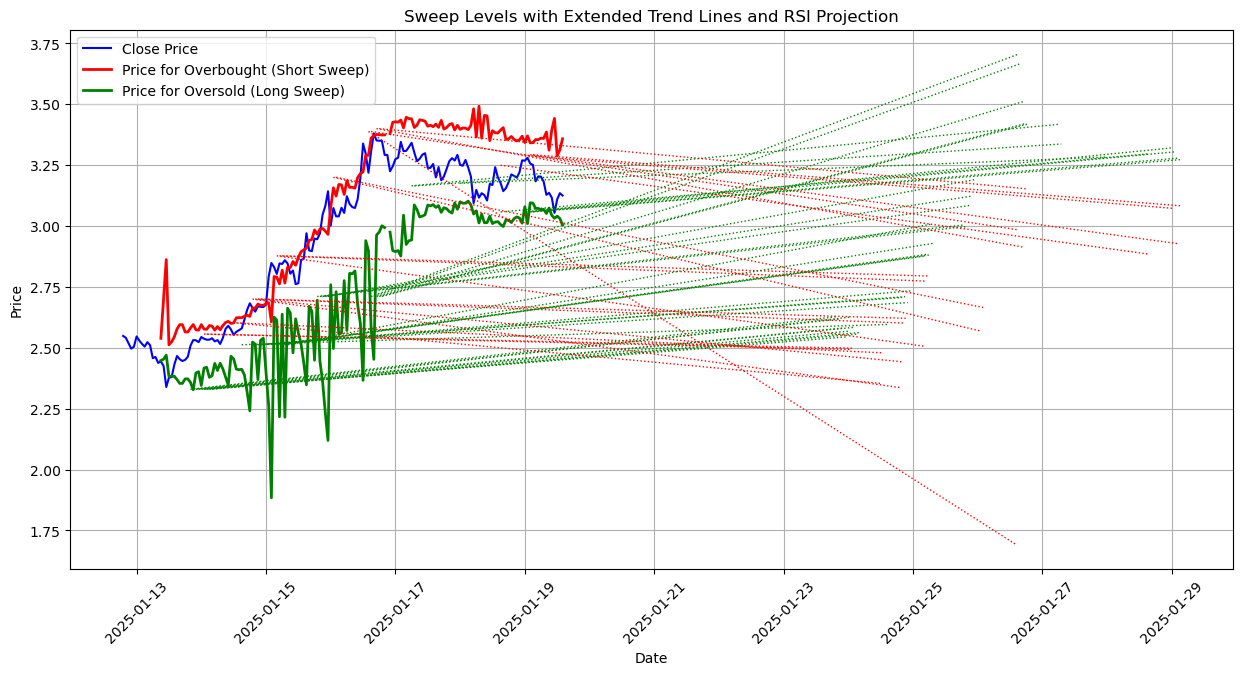

In [333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ta.momentum import RSIIndicator
import datetime
from scipy.stats import linregress

# Function to calculate RSI
def calculate_rsi(df, period, col='Close'):
    rsi_indicator = RSIIndicator(close=df[col], window=period)
    df['RSI'] = rsi_indicator.rsi()
    return df

# Function to compute weighted RSI change
def compute_weighted_rsi_change(df, col='Close'):
    df['PriceChange'] = df[col].diff()
    df['RSIChange'] = df['RSI'].diff()
    df['WeightedRSIChange'] = np.where(df['PriceChange'] != 0,
                                       df['RSIChange'] / df['PriceChange'],
                                       np.nan)
    return df

# Function to calculate sweep levels
def calculate_sweep_levels(df, overbought, oversold, col='Close'):
    df['PriceForOverbought'] = np.nan
    df['PriceForOversold'] = np.nan

    condition = (~df['WeightedRSIChange'].isna()) & (df['WeightedRSIChange'] != 0)
    df.loc[condition, 'PriceForOverbought'] = df[col] + (overbought - df['RSI']) / df['WeightedRSIChange']
    df.loc[condition, 'PriceForOversold'] = df[col] + (oversold - df['RSI']) / df['WeightedRSIChange']

    return df

# Function to find recent highs and lows
def find_recent_high_low(df, lookback_high, lookback_low, h_col='High', l_col='Low'):
    df['RecentHigh'] = df[h_col].rolling(window=lookback_high, min_periods=1).max()
    df['RecentLow'] = df[l_col].rolling(window=lookback_low, min_periods=1).min()
    return df

# Corrected Function to find the start points for trend lines
def find_trend_line_starts(df, lookback_high, lookback_low, h_col='High', l_col='Low'):
    """
    Finds the start indices for resistance and support trend lines based on recent highs and lows.

    Parameters:
    - df (pd.DataFrame): DataFrame containing stock data with 'BarIndex', 'High', 'Low', 'RecentHigh', 'RecentLow' columns.
    - lookback_high (int): Number of bars to look back for recent highs.
    - lookback_low (int): Number of bars to look back for recent lows.
    - h_col (str): Column name for high prices.
    - l_col (str): Column name for low prices.

    Returns:
    - pd.DataFrame: DataFrame with 'ResistanceStartIndex', 'SupportStartIndex', 'TrendLineResistancePrice', 'TrendLineSupportPrice' columns added.
    """

    def get_resistance_start_index(row):
        # Define the window start ensuring it doesn't go below 0
        start = max(row.name - lookback_high + 1, 0)
        window = df[h_col].iloc[start: row.name + 1]
        # Find indices where High == RecentHigh within the window
        matching_indices = df['BarIndex'].iloc[start: row.name + 1][window == row['RecentHigh']]
        if not matching_indices.empty:
            return matching_indices.iloc[-1]
        else:
            return np.nan

    def get_support_start_index(row):
        # Define the window start ensuring it doesn't go below 0
        start = max(row.name - lookback_low + 1, 0)
        window = df[l_col].iloc[start: row.name + 1]
        # Find indices where Low == RecentLow within the window
        matching_indices = df['BarIndex'].iloc[start: row.name + 1][window == row['RecentLow']]
        if not matching_indices.empty:
            return matching_indices.iloc[-1]
        else:
            return np.nan

    # Apply the functions to compute ResistanceStartIndex and SupportStartIndex
    df['ResistanceStartIndex'] = df.apply(get_resistance_start_index, axis=1)
    df['SupportStartIndex'] = df.apply(get_support_start_index, axis=1)

    # Determine the TrendLineResistancePrice and TrendLineSupportPrice
    df['TrendLineResistancePrice'] = df.apply(
        lambda row: row[h_col] if row[h_col] == row['RecentHigh'] else np.nan,
        axis=1
    )
    df['TrendLineSupportPrice'] = df.apply(
        lambda row: row[l_col] if row[l_col] == row['RecentLow'] else np.nan,
        axis=1
    )

    # Forward fill the start indices and prices to propagate the last known values
    df['ResistanceStartIndex'] = df['ResistanceStartIndex'].fillna(method='ffill')
    df['SupportStartIndex'] = df['SupportStartIndex'].fillna(method='ffill')
    df['TrendLineResistancePrice'] = df['TrendLineResistancePrice'].fillna(method='ffill')
    df['TrendLineSupportPrice'] = df['TrendLineSupportPrice'].fillna(method='ffill')

    return df

# Function to calculate trend line projections
def calculate_trend_line_projections(df, projection_bars, col='Close'):
    # Avoid division by zero by replacing zero differences with NaN
    df['BarIndexDiffResistance'] = df['BarIndex'] - df['ResistanceStartIndex']
    df['BarIndexDiffResistance'].replace(0, np.nan, inplace=True)
    df['BarIndexDiffSupport'] = df['BarIndex'] - df['SupportStartIndex']
    df['BarIndexDiffSupport'].replace(0, np.nan, inplace=True)

    # Calculate the slope for resistance and support
    df['ResistanceSlope'] = (df[col] - df['TrendLineResistancePrice']) / df['BarIndexDiffResistance']
    df['SupportSlope'] = (df[col] - df['TrendLineSupportPrice']) / df['BarIndexDiffSupport']

    # Project future prices
    df['FutureResistancePrice'] = df['TrendLineResistancePrice'] + df['ResistanceSlope'] * projection_bars
    df['FutureSupportPrice'] = df['TrendLineSupportPrice'] + df['SupportSlope'] * projection_bars

    return df

# Function to calculate trend line quality scores using correlation
def calculate_trend_line_scores(df, lookback_high, lookback_low, h_col='High', l_col='Low'):
    df['ResistanceScore'] = np.nan
    df['SupportScore'] = np.nan

    for i in range(len(df)):
        # Resistance Score
        start_high = max(i - lookback_high + 1, 0)
        window_high = df[h_col].iloc[start_high:i + 1]
        if len(window_high) >= 2:
            slope, intercept, r_value, p_value, std_err = linregress(range(len(window_high)), window_high)
            df.at[i, 'ResistanceScore'] = r_value  # Pearson correlation coefficient

        # Support Score
        start_low = max(i - lookback_low + 1, 0)
        window_low = df[l_col].iloc[start_low:i + 1]
        if len(window_low) >= 2:
            slope, intercept, r_value, p_value, std_err = linregress(range(len(window_low)), window_low)
            df.at[i, 'SupportScore'] = r_value  # Pearson correlation coefficient

    return df

# Function to plot the indicator
def plot_indicator(df, overbought, oversold, projection_bars, high_quality_threshold, col='Close'):
    fig, ax = plt.subplots(figsize=(15, 7))

    # Plot Close price
    ax.plot(df['Date'], df[col], label='Close Price', color='blue')

    # Plot RSI sweep levels
    ax.plot(df['Date'], df['PriceForOverbought'], label='Price for Overbought (Short Sweep)', color='red', linewidth=2)
    ax.plot(df['Date'], df['PriceForOversold'], label='Price for Oversold (Long Sweep)', color='green', linewidth=2)

    # Plot trend lines
    for idx, row in df.iterrows():
        # Plot resistance trend line if score > threshold
        if not np.isnan(row['ResistanceScore']) and row['ResistanceScore'] > high_quality_threshold:
            start_date = row['Date']
            end_date = start_date + datetime.timedelta(days=projection_bars)
            ax.plot([start_date, end_date],
                    [row['TrendLineResistancePrice'], row['FutureResistancePrice']],
                    color='red', linestyle='dotted', linewidth=1)

        # Plot support trend line if score > threshold
        if not np.isnan(row['SupportScore']) and row['SupportScore'] > high_quality_threshold:
            start_date = row['Date']
            end_date = start_date + datetime.timedelta(days=projection_bars)
            ax.plot([start_date, end_date],
                    [row['TrendLineSupportPrice'], row['FutureSupportPrice']],
                    color='green', linestyle='dotted', linewidth=1)

    # Formatting
    ax.set_title('Sweep Levels with Extended Trend Lines and RSI Projection')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True)

    # Improve date formatting
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)

    plt.show()

# -------------------------------
# Main Execution Script
# -------------------------------

# Parameters (you can adjust these as needed)
rsi_length = 14
overbought = 70
oversold = 30
lookback_high = 10
lookback_low = 10
projection_bars = 10
high_quality_threshold = 0.8

# Load your data into a pandas DataFrame
# The DataFrame should have at least 'Date', 'Open', 'High', 'Low', 'Close' columns
# For example, you can load data from a CSV file:
# df = pd.read_csv('your_data.csv', parse_dates=['Date'])

# Assuming df_tr is your existing DataFrame
# Replace 'df_tr' with your actual DataFrame variable if different
df = df_tr.copy()  # Use .copy() to avoid SettingWithCopyWarning

# Ensure column names are correctly capitalized
df.rename(columns={
    'close': 'Close',
    'high': 'High',
    'low': 'Low',
    'open': 'Open',
    'time': 'Date'
}, inplace=True)

# Assign a bar index
df.reset_index(inplace=True)
df.rename(columns={'index': 'BarIndex'}, inplace=True)

# Calculate RSI
df = calculate_rsi(df, rsi_length, col='Close')

# Compute Weighted RSI Change
df = compute_weighted_rsi_change(df, col='Close')

# Calculate Sweep Levels
df = calculate_sweep_levels(df, overbought, oversold, col='Close')

# Find Recent Highs and Lows
df = find_recent_high_low(df, lookback_high, lookback_low, h_col='High', l_col='Low')

# Find Trend Line Start Points
df = find_trend_line_starts(df, lookback_high, lookback_low, h_col='High', l_col='Low')

# Calculate Trend Line Projections
df = calculate_trend_line_projections(df, projection_bars, col='Close')

# Calculate Trend Line Quality Scores using correlation
df = calculate_trend_line_scores(df, lookback_high, lookback_low, h_col='High', l_col='Low')

# Plot the indicator
plot_indicator(df, overbought, oversold, projection_bars, high_quality_threshold, col='Close')


In [334]:
df

,BarIndex,Date,Open,High,Low,Close,volume,SUPPORT_1,SUPPORT_2,SUPPORT_3,...,TrendLineResistancePrice,TrendLineSupportPrice,BarIndexDiffResistance,BarIndexDiffSupport,ResistanceSlope,SupportSlope,FutureResistancePrice,FutureSupportPrice,ResistanceScore,SupportScore
0,0,2025-01-12 19:00:00,2.5438,2.5550,2.5349,2.5487,6933108.0,NaN,NaN,NaN,...,2.5550,2.5349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2025-01-12 20:00:00,2.5488,2.5492,2.5272,2.5412,6018458.0,NaN,NaN,NaN,...,2.5550,2.5272,1.0,NaN,-0.013800,NaN,2.417000,NaN,-1.000000,-1.000000
2,2,2025-01-12 21:00:00,2.5412,2.5431,2.5141,2.5192,8593103.0,NaN,NaN,NaN,...,2.5550,2.5141,2.0,NaN,-0.017900,NaN,2.376000,NaN,-0.999894,-0.988952
3,3,2025-01-12 22:00:00,2.5192,2.5201,2.4892,2.4964,12273541.0,NaN,NaN,NaN,...,2.5550,2.4892,3.0,NaN,-0.019533,NaN,2.359667,NaN,-0.935383,-0.967921
4,4,2025-01-12 23:00:00,2.4963,2.5098,2.4847,2.5046,6783591.0,NaN,NaN,NaN,...,2.5550,2.4847,4.0,NaN,-0.012600,NaN,2.429000,NaN,-0.968212,-0.977320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,171,2025-01-19 22:00:00,NaN,NaN,NaN,NaN,NaN,2.949103,2.994933,2.7544,...,3.2929,3.0351,8.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
172,172,2025-01-19 23:00:00,NaN,NaN,NaN,NaN,NaN,2.946064,2.993100,2.7467,...,3.2929,3.0351,9.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
173,173,2025-01-20 00:00:00,NaN,NaN,NaN,NaN,NaN,2.943024,2.991267,2.7390,...,3.2929,3.0351,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
174,174,2025-01-20 01:00:00,NaN,NaN,NaN,NaN,NaN,2.939985,2.989433,2.7313,...,3.2929,3.0351,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN


In [335]:
len(df_tr)

176

In [336]:
len(df)

176

In [337]:
df.columns

Index(['BarIndex', 'Date', 'Open', 'High', 'Low', 'Close', 'volume',
       'SUPPORT_1', 'SUPPORT_2', 'SUPPORT_3', 'SUPPORT_4', 'SUPPORT_5',
       'SUPPORT_6', 'SUPPORT_7', 'SUPPORT_8', 'SUPPORT_9', 'SUPPORT_10',
       'SUPPORT_11', 'SUPPORT_12', 'SUPPORT_13', 'SUPPORT_14', 'SUPPORT_15',
       'SUPPORT_16', 'SUPPORT_17', 'SUPPORT_18', 'SUPPORT_19', 'SUPPORT_20',
       'SUPPORT_21', 'SUPPORT_22', 'SUPPORT_23', 'SUPPORT_24', 'SUPPORT_25',
       'RESISTANCE_1', 'RESISTANCE_2', 'RESISTANCE_3', 'RESISTANCE_4',
       'RESISTANCE_5', 'RESISTANCE_6', 'RESISTANCE_7', 'RESISTANCE_8', 'RSI',
       'PriceChange', 'RSIChange', 'WeightedRSIChange', 'PriceForOverbought',
       'PriceForOversold', 'RecentHigh', 'RecentLow', 'ResistanceStartIndex',
       'SupportStartIndex', 'TrendLineResistancePrice',
       'TrendLineSupportPrice', 'BarIndexDiffResistance',
       'BarIndexDiffSupport', 'ResistanceSlope', 'SupportSlope',
       'FutureResistancePrice', 'FutureSupportPrice', 'ResistanceScore'

In [338]:
for col in ['PriceForOverbought',
       'PriceForOversold']:

    df_tr[col] = df[col]

In [339]:
line_data_l = []
for res_sup_line in all_resistance_support_lines_l+ ['PriceForOverbought',
       'PriceForOversold']:
    line_data = [
    {
        "time": int(time.mktime(row["time"].timetuple())),
        "value": row[[res_sup_line]].values[0]
    }
    for _, row in df_tr[[res_sup_line] + ["time"]].iterrows()
    if pd.notna(row[[res_sup_line]].values[0]) and row[[res_sup_line]].values[0] is not np.datetime64('NaT')
    ]

    line_data_l.append(line_data)
    print(f"Finished adding {res_sup_line}")

Finished adding SUPPORT_1
Finished adding SUPPORT_2
Finished adding SUPPORT_3
Finished adding SUPPORT_4
Finished adding SUPPORT_6
Finished adding RESISTANCE_1
Finished adding RESISTANCE_2
Finished adding RESISTANCE_3
Finished adding RESISTANCE_4
Finished adding RESISTANCE_3
Finished adding RESISTANCE_7
Finished adding PriceForOverbought
Finished adding PriceForOversold


In [340]:
seriesOptions_l = []
for res_sup_line in all_resistance_support_lines_l:
    if "RESISTANCE_" in res_sup_line:
        serOpt = {
            'priceLineVisible': False,  # Hides the vertical dashed line
            'lastValueVisible': False,  # Hides the price label on the y-axis
            'title': '' , #res_sup_line,
            'color': 'red',
            'lineWidth': 2,  # Optional: set the line width
            'lineStyle': 0,  # Optional: solid line; 0: solid, 1: dotted, 2: dashed
        }
    elif "SUPPORT_" in res_sup_line:
        serOpt = {
            'priceLineVisible': False,  # Hides the vertical dashed line
            'lastValueVisible': False,  # Hides the price label on the y-axis
            'title': '', #res_sup_line,
            'color': 'blue',
            'lineWidth': 2,  # Optional: set the line width
            'lineStyle': 0,  # Optional: solid line; 0: solid, 1: dotted, 2: dashed
        }

    seriesOptions_l.append(serOpt)
    
for rsi_line in ['PriceForOverbought',
       'PriceForOversold']:
    if "Overbought" in rsi_line:
        serOpt = {
            'priceLineVisible': False,  # Hides the vertical dashed line
            'lastValueVisible': False,  # Hides the price label on the y-axis
            'title': '' , #res_sup_line,
            'color': 'red',
            'lineWidth': 2,  # Optional: set the line width
            'lineStyle': 0,  # Optional: solid line; 0: solid, 1: dotted, 2: dashed
        }
    elif "Oversold" in rsi_line:
        serOpt = {
            'priceLineVisible': False,  # Hides the vertical dashed line
            'lastValueVisible': False,  # Hides the price label on the y-axis
            'title': '', #res_sup_line,
            'color': 'blue',
            'lineWidth': 2,  # Optional: set the line width
            'lineStyle': 0,  # Optional: solid line; 0: solid, 1: dotted, 2: dashed
        }

    seriesOptions_l.append(serOpt)
    
for i in range(0, len(trendline_orderbook_intersection_points)):

    serOpt = {
        'priceLineVisible': False,  # Hides the vertical dashed line
        'lastValueVisible': False,  # Hides the price label on the y-axis
        'title': '',
        'color': trendline_orderbook_intersection_points.loc[i, 'color'],
        'lineWidth': 4,  # Optional: set the line width
        'lineStyle': 0,  # Optional: solid line; 0: solid, 1: dotted, 2: dashed
    }

    seriesOptions_l.append(serOpt)





seriesOptions_l =  [{}] + seriesOptions_l
seriesOptions_l

[{},
 {'priceLineVisible': False,
  'lastValueVisible': False,
  'title': '',
  'color': 'blue',
  'lineWidth': 2,
  'lineStyle': 0},
 {'priceLineVisible': False,
  'lastValueVisible': False,
  'title': '',
  'color': 'blue',
  'lineWidth': 2,
  'lineStyle': 0},
 {'priceLineVisible': False,
  'lastValueVisible': False,
  'title': '',
  'color': 'blue',
  'lineWidth': 2,
  'lineStyle': 0},
 {'priceLineVisible': False,
  'lastValueVisible': False,
  'title': '',
  'color': 'blue',
  'lineWidth': 2,
  'lineStyle': 0},
 {'priceLineVisible': False,
  'lastValueVisible': False,
  'title': '',
  'color': 'blue',
  'lineWidth': 2,
  'lineStyle': 0},
 {'priceLineVisible': False,
  'lastValueVisible': False,
  'title': '',
  'color': 'red',
  'lineWidth': 2,
  'lineStyle': 0},
 {'priceLineVisible': False,
  'lastValueVisible': False,
  'title': '',
  'color': 'red',
  'lineWidth': 2,
  'lineStyle': 0},
 {'priceLineVisible': False,
  'lastValueVisible': False,
  'title': '',
  'color': 'red',
  '

In [341]:
import dash
from dash import html
import dash_tvlwc
import pandas as pd

# Assuming candlestick_data, line_data_l, and orderbook_data_l are already defined
# Add additional configuration or loading logic here if needed

# Assuming whale_alert_df is defined and contains whale transaction data
def calculate_scores(df):
    # Placeholder function to calculate scores (implement as needed)
    return df.assign(Buy_Sell_ratio_score=df["amount"] * 0.1)  # Example logic

whale_alert_df = pd.DataFrame({
    "amount": [1000, 5000, 2000, 8000],
    "transaction": ["tx1", "tx2", "tx3", "tx4"],
    "from": ["wallet1", "wallet2", "wallet3", "wallet4"],
    "to": ["wallet5", "wallet6", "wallet7", "wallet8"]
})  # Example data

xrp_to_usdt_conversion_rate = 50000  # Example XRP to USDT conversion rate
whale_alert_df["amount_usdt"] = whale_alert_df["amount"] * xrp_to_usdt_conversion_rate

# Define wallet type mapping
wallet_type_mapping = {
    "wallet1": "Ledger (Unknown)",
    "wallet2": "Ledger (Unknown)",
    "wallet3": "Ledger (Unknown)",
    "wallet4": "Ledger (Unknown)",
    "wallet5": "Exchange (Binance)",
    "wallet6": "Exchange (Coinbase)",
    "wallet7": "Exchange (Kraken)",
    "wallet8": "Exchange (Bitfinex)"
}

# Map wallet types
whale_alert_df["from_type"] = whale_alert_df["from"].map(wallet_type_mapping)
whale_alert_df["to_type"] = whale_alert_df["to"].map(wallet_type_mapping)

bullish_bearish_score = calculate_scores(whale_alert_df).Buy_Sell_ratio_score.max()
max_transaction = whale_alert_df.loc[whale_alert_df["amount"].idxmax()]

# Define a threshold for sentiment classification
sentiment_threshold = 5000  # Example threshold

# Determine sentiment based on the score
if bullish_bearish_score > sentiment_threshold:
    whale_sentiment = "Bullish"
else:
    whale_sentiment = "Bearish"

# Simulated LunarCrush sentiment data
lunarcrush_sentiment_data = {
    "symbol": "XRP",
    "name": "Ripple",
    "social_sentiment": "Bullish",  # Example: "Bullish" or "Bearish"
    "score": 85.2  # Example sentiment score
}

app = dash.Dash(__name__, suppress_callback_exceptions=True)
app.layout = html.Div(
    style={"backgroundColor": "#121212", "padding": "20px", "fontFamily": "Andale Mono"},
    children=[
        html.H1(f"XRP Hourly", style={"color": "#F5B041", "textAlign": "center", "fontFamily": "Andale Mono", "fontWeight": "bold"}),

        dash_tvlwc.Tvlwc(
            id="chart",  # Added id for callback reference
            seriesData=[candlestick_data] + line_data_l + orderbook_data_l,
            seriesTypes=['candlestick'] + ['line' for _ in line_data_l] + ['line' for _ in orderbook_data_l],
            seriesOptions=seriesOptions_l,
            seriesMarkers=[markers],  # Add markers for annotations
            chartOptions={
                'layout': {
                    'background': {'type': 'solid', 'color': '#121212'},
                    'textColor': '#F5B041',
                },
                'grid': {
                    'vertLines': {'visible': True, 'color': 'rgba(255,255,255,0.2)'},
                    'horzLines': {'visible': True, 'color': 'rgba(255,255,255,0.2)'},
                },
                'timeScale': {
                    'timeVisible': True,
                    'secondsVisible': False,  # Adjust as needed
                },
                'priceScale': {
                    'position': 'right',
                    'borderVisible': False,
                },
                'crosshair': {
                    'mode': 1,
                },
                'handleScale': {
                    'axisPressedMouseMove': True,
                    'mouseWheel': True,
                    'pinch': True,
                },
            },
            width='100%',
            height=700,
        ),

        html.Div(
            style={"marginTop": "20px", "textAlign": "center"},
            children=[
                html.Label("Custom Chart Controls", style={"color": "#F5B041", "fontFamily": "Andale Mono", "fontWeight": "bold"}),
                html.Div(
                    style={"display": "flex", "justifyContent": "center", "gap": "10px"},
                    children=[
                        html.Button("Zoom In", id="zoom-in", n_clicks=0, style={"padding": "10px", "fontFamily": "Andale Mono", "color": "#121212", "backgroundColor": "#F5B041", "border": "none", "borderRadius": "5px"}),
                        html.Button("Zoom Out", id="zoom-out", n_clicks=0, style={"padding": "10px", "fontFamily": "Andale Mono", "color": "#121212", "backgroundColor": "#F5B041", "border": "none", "borderRadius": "5px"}),
                        html.Button("Reset View", id="reset-view", n_clicks=0, style={"padding": "10px", "fontFamily": "Andale Mono", "color": "#121212", "backgroundColor": "#F5B041", "border": "none", "borderRadius": "5px"}),
                    ],
                ),
            ],
        ),

        # Banner for Whale Sentiment
        html.Div(
            style={"backgroundColor": "#2E4053", "padding": "15px", "marginTop": "20px", "borderRadius": "10px", "color": "#F5B041", "fontFamily": "Andale Mono", "boxShadow": "0px 4px 6px rgba(0, 0, 0, 0.1)"},
            children=[
                html.H3("Whale Sentiment", style={"marginBottom": "10px", "fontWeight": "bold"}),
                html.P(f"Sentiment: {whale_sentiment}"),
                html.P(f"Bullish/Bearish Score: {bullish_bearish_score:.2f}"),
            ],
        ),

        # Banner for Largest Transaction
        html.Div(
            style={"backgroundColor": "#34495E", "padding": "15px", "marginTop": "10px", "borderRadius": "10px", "color": "#F5B041", "fontFamily": "Andale Mono", "boxShadow": "0px 4px 6px rgba(0, 0, 0, 0.1)"},
            children=[
                html.H3("Largest Transaction", style={"marginBottom": "10px", "fontWeight": "bold"}),
                html.P(f"Transaction: {max_transaction['transaction']}"),
                html.P(f"Amount: {max_transaction['amount']} XRP (${max_transaction['amount_usdt']:.2f} USDT)"),
                html.P(f"From: {max_transaction['from']} ({max_transaction['from_type']})"),
                html.P(f"To: {max_transaction['to']} ({max_transaction['to_type']})"),
            ],
        ),
       
        # LunarCrush Sentiment Banner
        html.Div(style={"backgroundColor": "#283747", "padding": "15px", "marginTop": "10px", "borderRadius": "10px", "color": "#F5B041", "fontFamily": "Andale Mono", "boxShadow": "0px 4px 6px rgba(0, 0, 0, 0.1)"},
            children=[
                html.H3("LunarCrush Sentiment", style={"marginBottom": "10px", "fontWeight": "bold"}),
                html.P(f"Symbol: {lunarcrush_sentiment_data['symbol']}"),
                html.P(f"Name: {lunarcrush_sentiment_data['name']}"),
                html.P(f"Sentiment: {lunarcrush_sentiment_data['social_sentiment']}"),
                html.P(f"Score: {lunarcrush_sentiment_data['score']}%"),
            ],
        ),
    ],
)

# Add interactivity for custom controls
@app.callback(
    dash.dependencies.Output('chart', 'chartOptions'),
    [
        dash.dependencies.Input('zoom-in', 'n_clicks'),
        dash.dependencies.Input('zoom-out', 'n_clicks'),
        dash.dependencies.Input('reset-view', 'n_clicks')
    ]
)
def update_chart_options(zoom_in, zoom_out, reset_view):
    # Adjust chart options based on button clicks
    return {
        'timeScale': {
            'timeVisible': True,
            'secondsVisible': False,
        },
        'layout': {
            'background': {'type': 'solid', 'color': '#121212'},
            'textColor': '#F5B041',
        },
    }

if __name__ == '__main__':
    app.run_server(debug=True, port=8701)









